An implementation of expanded-ensemble (Wang-Landau) sampling in a simple harmonic bias system

In [1]:
import numpy as np
import os, sys
from matplotlib import pyplot as plt
sys.path.append('/Users/nguyendung/git/codes')
from all_basic_functions import make_dir

#proj_path = '/Users/nguyendung/git/toy-ee/sampling'
#proj_path = '/Users/nguyendung/git/one_over_t_project'
proj_path = '/Volumes/empty/one_over_t_project'
make_dir(f'{proj_path}/trajectories')
make_dir(f'{proj_path}/plots')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [92]:
def u_i(x, k, x0, c):
    """Returns the (reduced) energy of the harmonic potential in units kT."""
    return 0.5*k*(x-x0)**2 + c

def delta_f_harmonic(k_i, k_j, dims=1):
    """Returns the difference in free energy f_ij = f_j - f_i (in units kT) of two harmonic potentials
    with force constants k_i and k_j.  For  $n$-dimensional harmonic potentials,

    -\ln (Z_j/Z_i) = - (n/2) * \ln [ (k_i/k_j) ]"""
    
    return -1.0*(float(dims)/2.0) * np.log( k_i/k_j )

def plot_wl_trajectories(nstep=10000000, c_1_over_t='no'):
    # Load data
    wl_increment_traj = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_{c_1_over_t}constant.npy') 
    step_traj = np.load(f'{proj_path}/trajectories/step_traj_{nstep}steps_1constant.npy')
    free_energy_traj = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_{c_1_over_t}constant.npy')
    x_traj = np.load(f'{proj_path}/trajectories/x_traj_{nstep}steps_{c_1_over_t}constant.npy')
    i_traj = np.load(f'{proj_path}/trajectories/i_traj_{nstep}steps_{c_1_over_t}constant.npy')
    T_counts = np.load(f'{proj_path}/trajectories/T_counts_reconstructed_{nstep}steps_{c_1_over_t}constant.npy')
 
    # Create 3x2 subplots
    fig, axs = plt.subplots(3, 2, figsize=(12, 10), dpi=300)
 
    # First subplot (WL increment)
    axs[0, 0].plot(step_traj, wl_increment_traj, color='darkblue')
    axs[0, 0].set_yscale('log')  # Log scale for y-axis
    axs[0, 0].set_xlabel('Number of steps', fontsize=12)
    axs[0, 0].set_ylabel('WL increment (kT)', fontsize=12)
 
    # Second subplot (Free energy)
    axs[1, 0].plot(step_traj, free_energy_traj, label='WL', color='darkblue')
    axs[1, 0].set_xscale('log')
    axs[1, 0].set_xlim(1e3, nstep)
    axs[1, 0].set_ylim(-10, 10)
    axs[1, 0].set_yticks(np.arange(-10, 11, 5))  # Set y-axis ticks with interval of 5
    axs[1, 0].set_xlabel('Number of steps', fontsize=12)
    axs[1, 0].set_ylabel('Estimated $\Delta G$', fontsize=12)
 
    # third subplot (x position vs. number of steps)
    axs[0, 1].plot(step_traj, x_traj, color='darkblue',linewidth=0.05)
    axs[0, 1].set_ylim(0, 10)
    axs[0, 1].set_xlabel('Number of steps', fontsize=12)
    axs[0, 1].set_ylabel('x position', fontsize=12)
 
    # forth subplot (thermodynamic index vs. number of steps)
    axs[1, 1].plot(step_traj, i_traj, color='darkblue',linewidth=0.05)
    axs[1, 1].set_ylim(0, 10)
    axs[1, 1].set_xlabel('Number of steps', fontsize=12)
    axs[1, 1].set_ylabel('Thermodynamic index', fontsize=12)
 
    # fifth subplot (absolute error))
    axs[2, 0].plot(step_traj, np.abs(free_energy_traj),color='darkblue')
    axs[2, 0].set_xscale('log')
    axs[2, 0].set_yscale('log')
    axs[2, 0].set_xlabel('Number of steps',fontsize=12)
    axs[2, 0].set_ylabel('Absolute error $|\epsilon|$',fontsize=12)
 
    # sixth subplot: transition probability matrix
    T = np.zeros( T_counts.shape )
    for i in range(T.shape[0]):
        row_sum = T_counts[i, :].sum()
        T[i, :] = T_counts[i, :] / row_sum if row_sum > 0 else 0  # Avoid division by zero
    axs[2, 1].set_xlabel('Thermodynamic Index', fontsize=12)
    axs[2, 1].set_ylabel('Thermodynamic Index', fontsize=12)
    im = axs[2, 1].pcolormesh(T, cmap='Blues')
    axs[2, 1].grid(False)  # No grid for heatmap

 
 
    # Adjust layout to prevent overlap
    plt.tight_layout()
 
    # Save the combined plot
    plt.savefig(f'{proj_path}/plots/combined_plots_{nstep}steps.png', dpi=300, bbox_inches='tight')
 
    # Show the plot
    plt.show()

def free_energy_of_multiple_traces(free_energy_files, colors, step_traj, nstep,save_label,plot_labels, show_legend = False, t_over_mixing_time=False):
    """
    Plot free energy trajectory from Wang-Landau sampling.
    """
    # Create the plot
    plt.figure(figsize=(8, 4))
    
    # Loop through suffixes to load and plot trajectories
    #for file, color in zip(free_energy_files, colors):
    plt.xscale('log')
    if t_over_mixing_time:
        for fe,step_over_mixing,label in zip (free_energy_files,step_traj, plot_labels):
            fe_traj = np.load(fe)
            step_mixing = np.load(step_over_mixing)
            plt.plot(step_mixing, fe_traj ,label=label)#, color=color)
        plt.xlabel('steps/mixing time', fontsize=12) 
    else:
        for fe,label in zip(free_energy_files,plot_labels):
            free_energy_traj = np.load(fe)
            #free_energy_traj_nonzero = replace_zeros_with_neighbor_average(free_energy_traj, n_neighbors=6)
            plt.plot(step_traj, free_energy_traj,label=label)#, color=color)
        plt.xlim(1e4, 1e9)
        plt.xlabel("Number of steps", fontsize=12)
    
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1.1, 0.5))  # Adjusted y-axis ticks for the specified ylim
    plt.ylabel('Estimated $\Delta G$', fontsize=12)
    if show_legend:
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
    plt.show()


def WL_increment_of_multiple_traces(wl_files, colors, step_traj, nstep,save_label, plot_labels, show_legend = False,t_over_mixing_time = False):
    """
    Plot free energy trajectory from Wang-Landau sampling.
    """

    # Create the plot
    plt.figure(figsize=(8, 4))
    
    # Loop through the provided WL increment files, labels, and colors
    #for file, color in zip(wl_files, colors):
    plt.yscale('log')
    plt.xscale('log')
    if t_over_mixing_time:
        for wl,step_over_mixing,label in zip (wl_files,step_traj, plot_labels):
            wl_increment_traj = np.load(wl)
            step_mixing = np.load(step_over_mixing)
            plt.plot(step_mixing, wl_increment_traj,label=label)#, color=color)
        plt.xlabel('steps/mixing time', fontsize=12)
    else:
        for file,label in zip (wl_files,plot_labels):
            wl_increment_traj = np.load(file)
            plt.plot(step_traj, wl_increment_traj,label=label)#, color=color)
        plt.xlabel('Number of steps', fontsize=12)
    plt.ylabel('WL increment (kT)', fontsize=12)
    if show_legend:
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
    plt.show()

def average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False):
    """
    Plot the free energy trajectory with zeros replaced by neighbor averages.
    """
    # Create the plot
    plt.figure(figsize=(8, 4))
    
    # Loop through the provided WL increment files, labels, and colors
    #for file, color in zip(free_energy_files, colors):
    plt.xscale("log")
    plt.yscale("log")

    # Load the free energy arrays from files and stack them
    fe_data = np.array([np.load(f) for f in free_energy_files])  # Shape: (num_files, len_per_file)
    abs_error = np.abs(fe_data) 

    # Mean and std across clones
    mean_abs_error = np.mean(abs_error, axis=0)
    
    if t_over_mixing_time:
        plt.plot(step_traj,mean_abs_error)
        plt.xlabel('Steps/mixing time', fontsize=12) 
    else:
        plt.plot(step_traj,mean_abs_error)
        plt.xlabel("Number of steps", fontsize=12)
    plt.ylabel('Average absolute error $|\epsilon|$',fontsize=12)
    if show_legend:
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')

def rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False):
    """
    Compute and plot the RMSE of different traces of free energy trajectory.
    """
    
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.xscale("log")
    plt.yscale("log")

    if t_over_mixing_time:
        #rmse_traj = np.load(rmse_file)
        step_mixing = np.load(step_traj)
        plt.plot(step_mixing, rmse)  
        plt.xlabel('steps/mixing time', fontsize=12)
    else:
        #rmse_traj = np.load(rmse_file)
        plt.plot(step_traj, rmse)
        plt.xlabel("Number of steps", fontsize=12)

    plt.ylabel('RMSE ', fontsize=12)
    if show_legend:
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/RMSE_of_multiple_traces_{save_label}.png', dpi=300, bbox_inches='tight')
    

def calculate_free_energy_sdt(free_energy_files,save_label):
    # Load the free energy arrays from files and stack them
    fe_data = np.array([np.load(f) for f in free_energy_files])  # Shape: (num_files, len_per_file)

    # Mean and std across clones
    mean = np.mean(fe_data, axis=0)
    std = np.std(fe_data, axis=0)

    # Calculate mean of free energy from step 1e8 to 1e9
    # 1e9 steps, saved every 100 steps = 10,000,000 data points
    # Step 1e8 = index 1,000,000 (1e8 / 100)
    mean_from_1e8_to_1e9 = np.mean(mean[1000000:]) if len(mean) >= 1000000 else np.mean(mean)
    
    # Calculate mean of each trace from step 1e8 to 1e9
    mean_of_each_trace_from_1e8 = np.mean(fe_data[:, 1000000:], axis=1) if fe_data.shape[1] >= 1000000 else np.mean(fe_data, axis=1)
    std_ofeach_trace_from1e8 = np.std(fe_data[:, 1000000:], axis=1) if fe_data.shape[1] >= 1000000 else np.std(fe_data, axis=1) 

    # Save mean and std to files
    np.save(f'{proj_path}/trajectories/mean_free_energy_of_multiple_traces_0axis_{save_label}.npy', mean)
    np.save(f'{proj_path}/trajectories/std_free_energy_of_multiple_traces_0axis_{save_label}.npy', std)

    np.save(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_{save_label}.npy', mean_of_each_trace_from_1e8)
    np.save(f'{proj_path}/trajectories/std_free_energy_of_each_traces_from1e8{save_label}.npy', mean_of_each_trace_from_1e8)
    np.save(f'{proj_path}/trajectories/mean_free_energy_of_all_1e8_to_1e9_{save_label}.npy', mean_from_1e8_to_1e9)

def calculate_rmse(free_energy_files,save_label):
    fe_data = np.array([np.load(f) for f in free_energy_files])
    # Assuming fe_data is already loaded as a 2D array (n_files, n_times)
    mean_fe = np.mean(fe_data, axis=0)  # Ensemble mean across files for each time point

    # Squared errors: (data - mean)^2, then mean across files
    squared_errors = (fe_data - mean_fe) ** 2
    mse = np.mean(squared_errors, axis=0)  # Mean squared error per time point
    
    # RMSE
    rmse = np.sqrt(mse)  # Root mean squared error per time point

    # Save rmse to files 
    np.save(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy', rmse) 

def plot_free_energy_std_or_rmse(fe_mean_files, fe_std_or_rmse_files, step_traj,plot_labels, save_label,colors):

    # Loop through suffixes to load and plot trajectories
    # for file, color in zip(free_energy_files, colors):
    for mean, error,label,color in zip(fe_mean_files, fe_std_or_rmse_files,plot_labels, colors):
        fe_mean = np.load(mean)
        fe_error = np.load(error)
        plt.plot(step_traj, fe_mean,label=label,color=color)
        plt.fill_between(step_traj, fe_mean - fe_error, fe_mean + fe_error, alpha=0.3)

     # Labels
    plt.xscale("log")
    plt.xlabel("Number of steps", fontsize=14)
    plt.ylabel("Free Energy (ΔG)", fontsize=14)
    plt.legend(loc='upper right')
    plt.xlim(1e6, 1e8)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{proj_path}/plots/{save_label}.png', dpi=600, bbox_inches='tight')
    plt.close()


def plot_std_or_rmse_free_energy_vs_steps(step_traj, fe_std_or_rmse_files, plot_labels, save_label, show_legend = False,std= False, rmse = False):
    """Plot standard deviation of free energy vs steps"""
    plt.figure(figsize=(8, 4))
    for error,label in zip(fe_std_or_rmse_files,plot_labels):
        fe_error = np.load(error)
        plt.plot(step_traj, fe_error, label = label) 
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of steps', fontsize=12)
    if std:
        plt.ylabel('Std Dev of $\Delta G$', fontsize=12)
    if rmse:
       plt.ylabel('RMSE of $\Delta G$', fontsize=12) 
    if show_legend:
        plt.legend()
    plt.ylim(5e-3, 5)
    plt.xlim(1e6, 1e9)
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/{save_label}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_mean_of_stds_vs_c_constants(fe_std_files, a):
    # Calculate mean of stds
    mean_of_stds = []
    for std_file in fe_std_files:
        fe_std = np.load(std_file)
        # Calculate mean of std from step 1e8 onward (index 1000000 assuming traj_every=100)
        mean_of_std = np.mean(fe_std[1000000:])
        mean_of_stds.append(mean_of_std)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(a, mean_of_stds)
    plt.xlabel('c Values', fontsize=12)
    plt.ylabel('Mean of Standard Deviation (from 1e8)', fontsize=12)
    plt.xticks(rotation=45)
    for i, v in enumerate(mean_of_stds):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom' if v >= 0 else 'top')
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/mean_of_stds_vs_c.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_transition_probability_matrix(T_counts, cmap='Blues'):
    # Normalize T_counts to create transition probability matrix
    T = np.zeros(T_counts.shape)
    for i in range(T.shape[0]):
        row_sum = T_counts[i, :].sum()
        T[i, :] = T_counts[i, :] / row_sum if row_sum > 0 else 0  # Avoid division by zero

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(T)
    print('eigenvalues: ',eigenvalues)

    # Plot transition probability matrix
    plt.figure()  # Create a new figure
    plt.xlabel('Thermodynamic Index', fontsize=12)
    plt.ylabel('Thermodynamic Index', fontsize=12)
    im = plt.pcolormesh(T, cmap=cmap, vmin=0, vmax=1)  # Set vmin and vmax for probability range
    plt.colorbar(im, label='Transition Probability')  # Add colorbar
    plt.grid(False)  # No grid for heatmap
    plt.tight_layout()
    plt.savefig(f'{proj_path}/plots/transition_probability_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def get_mixing_time_from_transition_matrix(T_counts, tau=10, epsilon=0.25):
    # Normalize T_counts to create transition probability matrix
    T = np.zeros(T_counts.shape)
    for i in range(T.shape[0]):
        row_sum = T_counts[i, :].sum()
        T[i, :] = T_counts[i, :] / row_sum if row_sum > 0 else 0  # Avoid division by zero

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(T)

    # Sort eigenvalues by magnitude (absolute value) and get the second largest
    eigenvals_magnitude = np.abs(eigenvalues)
    sorted_indices = np.argsort(eigenvals_magnitude)[::-1]  # Descending order
    # The first eigenvalue should be 1 (principal eigenvalue)
    second_largest_idx = sorted_indices[1]  # Index of second-largest magnitude
    second_largest_eigenvalue = eigenvalues[second_largest_idx]
    relaxation_time = tau / (-np.log(np.abs(second_largest_eigenvalue)))  # Assuming t=1

    print('relaxation_time',relaxation_time)
    return relaxation_time

def plot_wl_decrement_steps(step_traj, wl_traj, proj_path=None, show_plot=True, save_fig=False, fig_name='wl_decrement_steps.png'):
    """
    Compute the lengths of plateaus in WL increments (decrements) from given trajectories,
    and plot the number of steps per plateau vs. decrement number.
    """
    # Find indices where the value changes (decrements)
    change_indices = np.where(np.diff(wl_traj) != 0)[0]
    
    if len(change_indices) == 0:
        # No changes: single plateau spanning all steps
        lengths = [step_traj[-1] - step_traj[0]]
        decrement_numbers = np.arange(1)
        print('No decrements found; single plateau of {} steps.'.format(lengths[0]))
    else:
        # Define plateau boundaries (array indices)
        plateau_starts = np.concatenate(([0], change_indices + 1))
        plateau_ends = np.concatenate((change_indices, [len(wl_traj) - 1]))
        
        # Step values at boundaries
        step_starts = step_traj[plateau_starts]
        step_ends = step_traj[plateau_ends]
        
        # Steps per plateau
        lengths = step_ends - step_starts
        decrement_numbers = np.arange(len(lengths))
    
    print('change_indices:', change_indices)
    print('Step lengths per plateau:', lengths)
    
    # Plot
    if show_plot or save_fig:
        plt.figure(figsize=(8, 6))
        plt.plot(decrement_numbers, lengths, marker='o')  # Line with markers; use plt.bar() for bars
        plt.xlabel('Number of WL Decrement', fontsize=12)
        plt.ylabel('Number of Steps to Next WL Decrement', fontsize=12)
        plt.title('Steps Between WL Decrements')
        plt.yscale('log')
        plt.tight_layout()
        if save_fig and proj_path:
            plt.savefig(f'{proj_path}/plots/{fig_name}', dpi=300, bbox_inches='tight')
        if show_plot:
            plt.show()
        plt.close()
    
    # Print details
    print("Decrement | Steps")
    print("----------|-------")
    for dec, steps in zip(decrement_numbers, lengths):
        print(f"{dec:9} | {steps}")
        
    


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:169: SyntaxWarning: invalid escape sequence '\e'
<>:275: SyntaxWarning: invalid escape sequence '\D'
<>:277: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:169: SyntaxWarning: invalid escape sequence '\e'
<>:275: SyntaxWarning: invalid escape sequence '\D'
<>:277: SyntaxWarning: invalid escape sequence '\D'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_41751/3626236985.py:6: SyntaxWarning: invalid escape sequence '\l'
  """Returns the difference in free energy f_ij = f_j - f_i (in units kT) of two harmonic potentials
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipyk

# simple 1 well harmonic potential is used as toy model

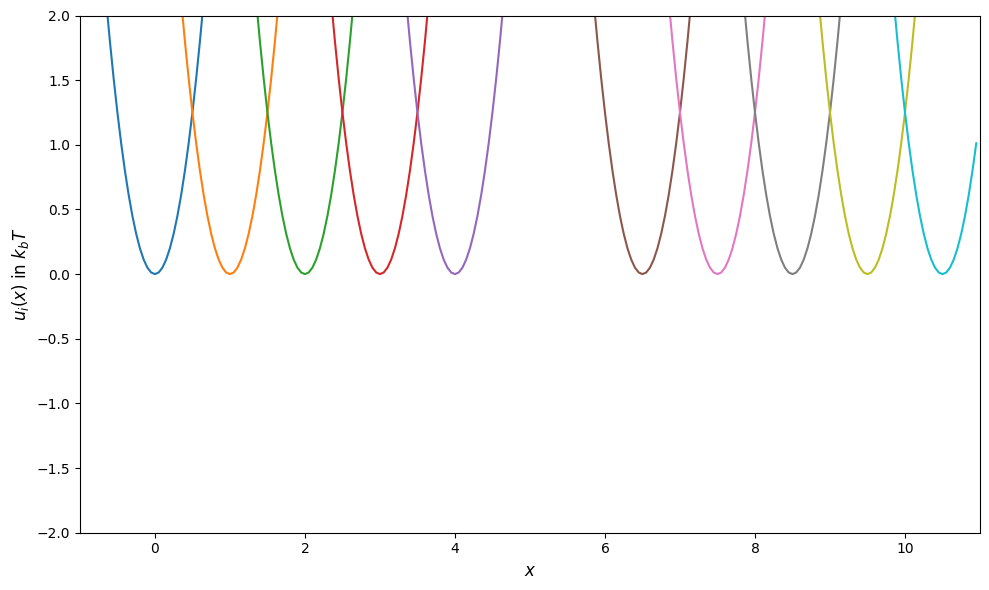

In [7]:

# Data from user
xshift = 0.5
x_i = np.array([0., 1., 2., 3., 4., 5.+xshift, 6.+xshift, 7.+xshift, 8.+xshift, 9.+xshift])  # length (unitless)
ka, kb = 10.0, 500.0
k_i = np.array([ka, ka, ka, ka, ka, ka, ka, ka, ka, ka])  # kT/(length)^2
c_i = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # kT/(length)^2
n_ensembles = len(x_i)

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size and high DPI for quality
xvalues = np.arange(-2., 11., 0.05)
for i in range(n_ensembles):
    plt.plot(xvalues, u_i(xvalues, k_i[i], x_i[i], c_i[i]))

# Add labels and title
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u_i (x)$ in $k_b T$', fontsize=12)
plt.xlim(-1,11)
plt.ylim(-2,2)

# Ensure tight layout to prevent clipping
plt.tight_layout()

# Save the plot in high quality
plt.savefig(f'{proj_path}/plots/harmonic_potential.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()

# Plots for WL with no 1/t implement

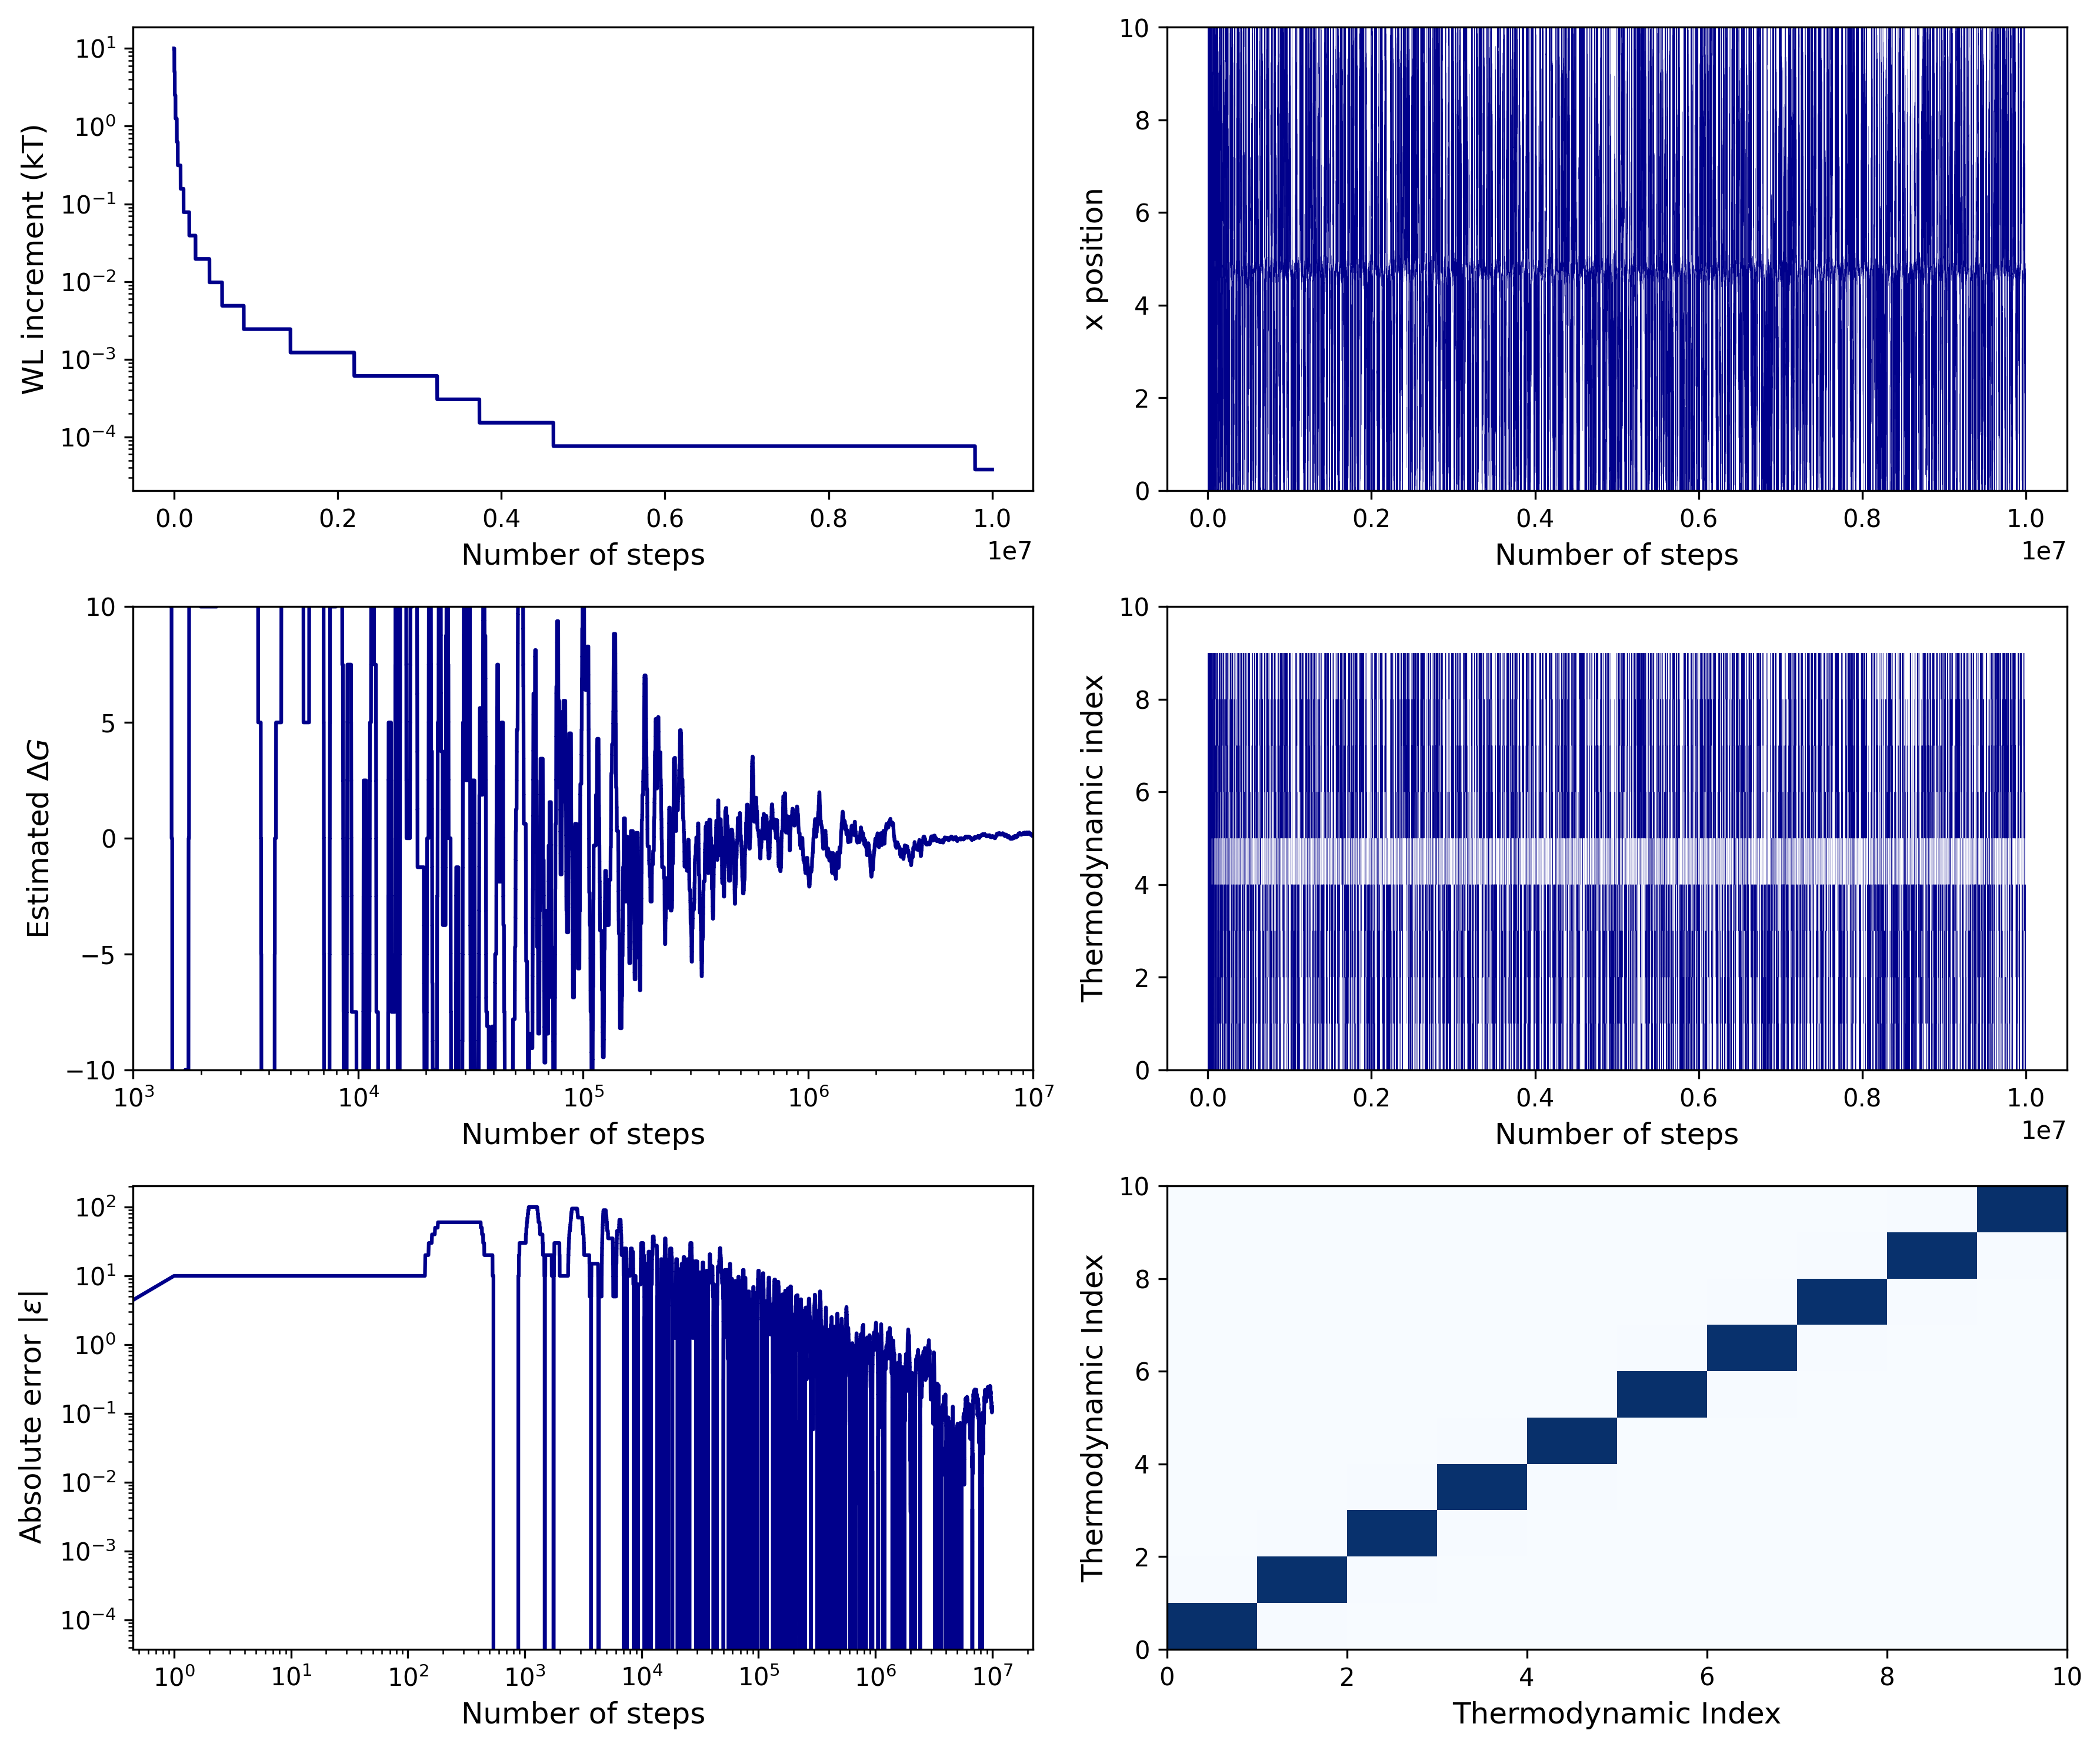

In [25]:
plot_wl_trajectories(nstep=10000000, c_1_over_t='no')

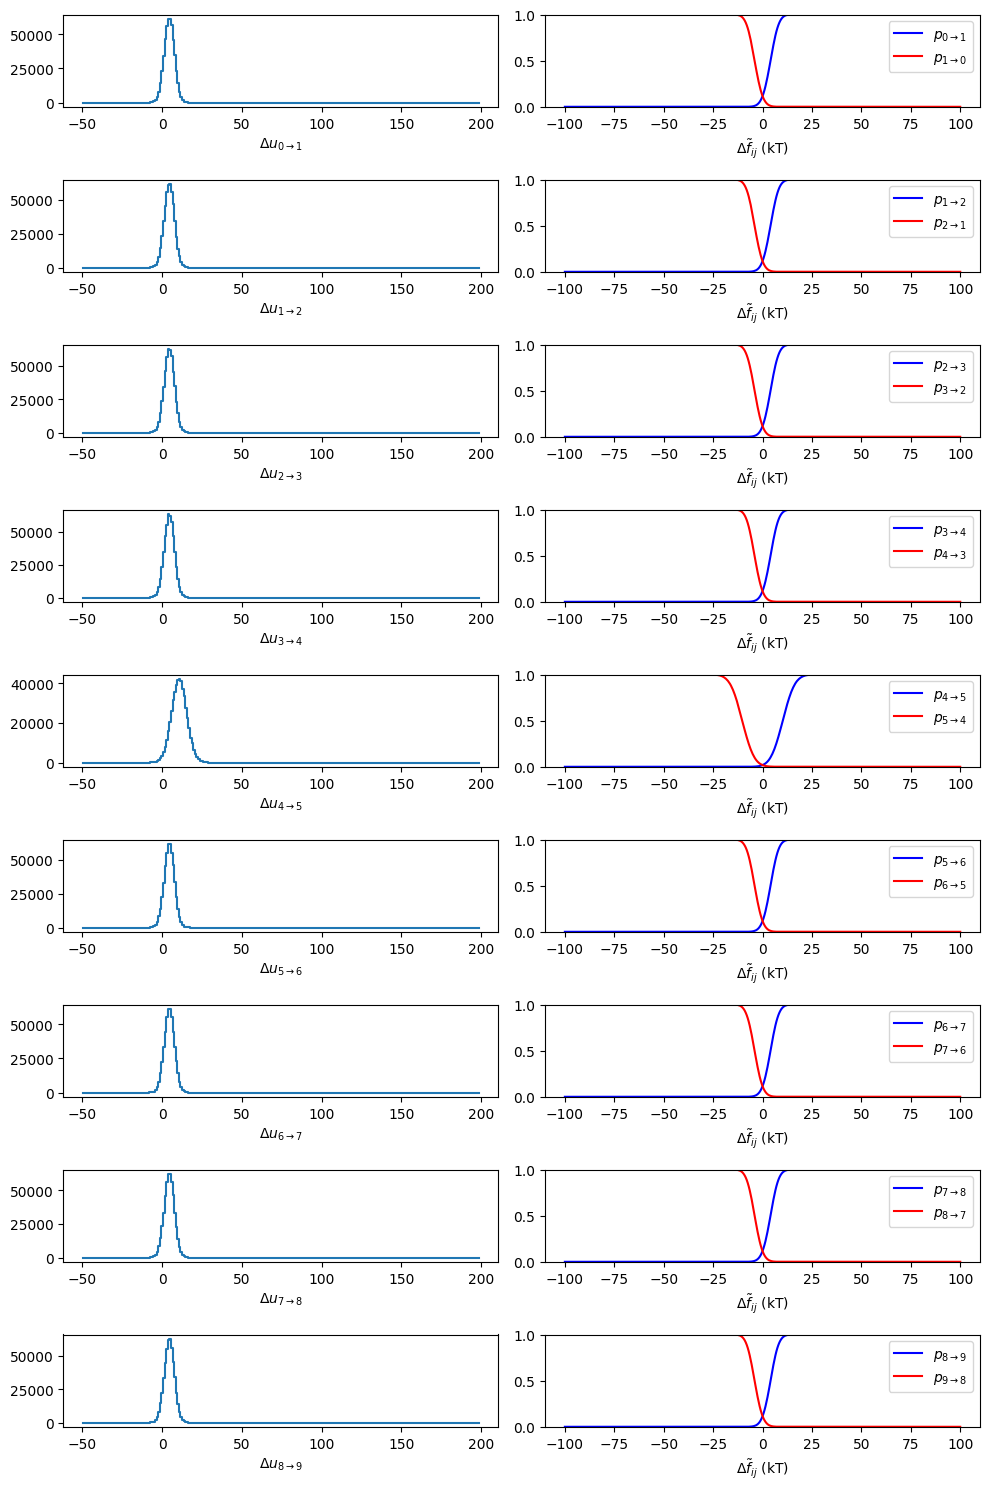

In [32]:
plot_delta_energy_distribution(nstep=10000000, n_ensembles= 10, c_1_over_t='no')

# Plots for WL with 1/t implement

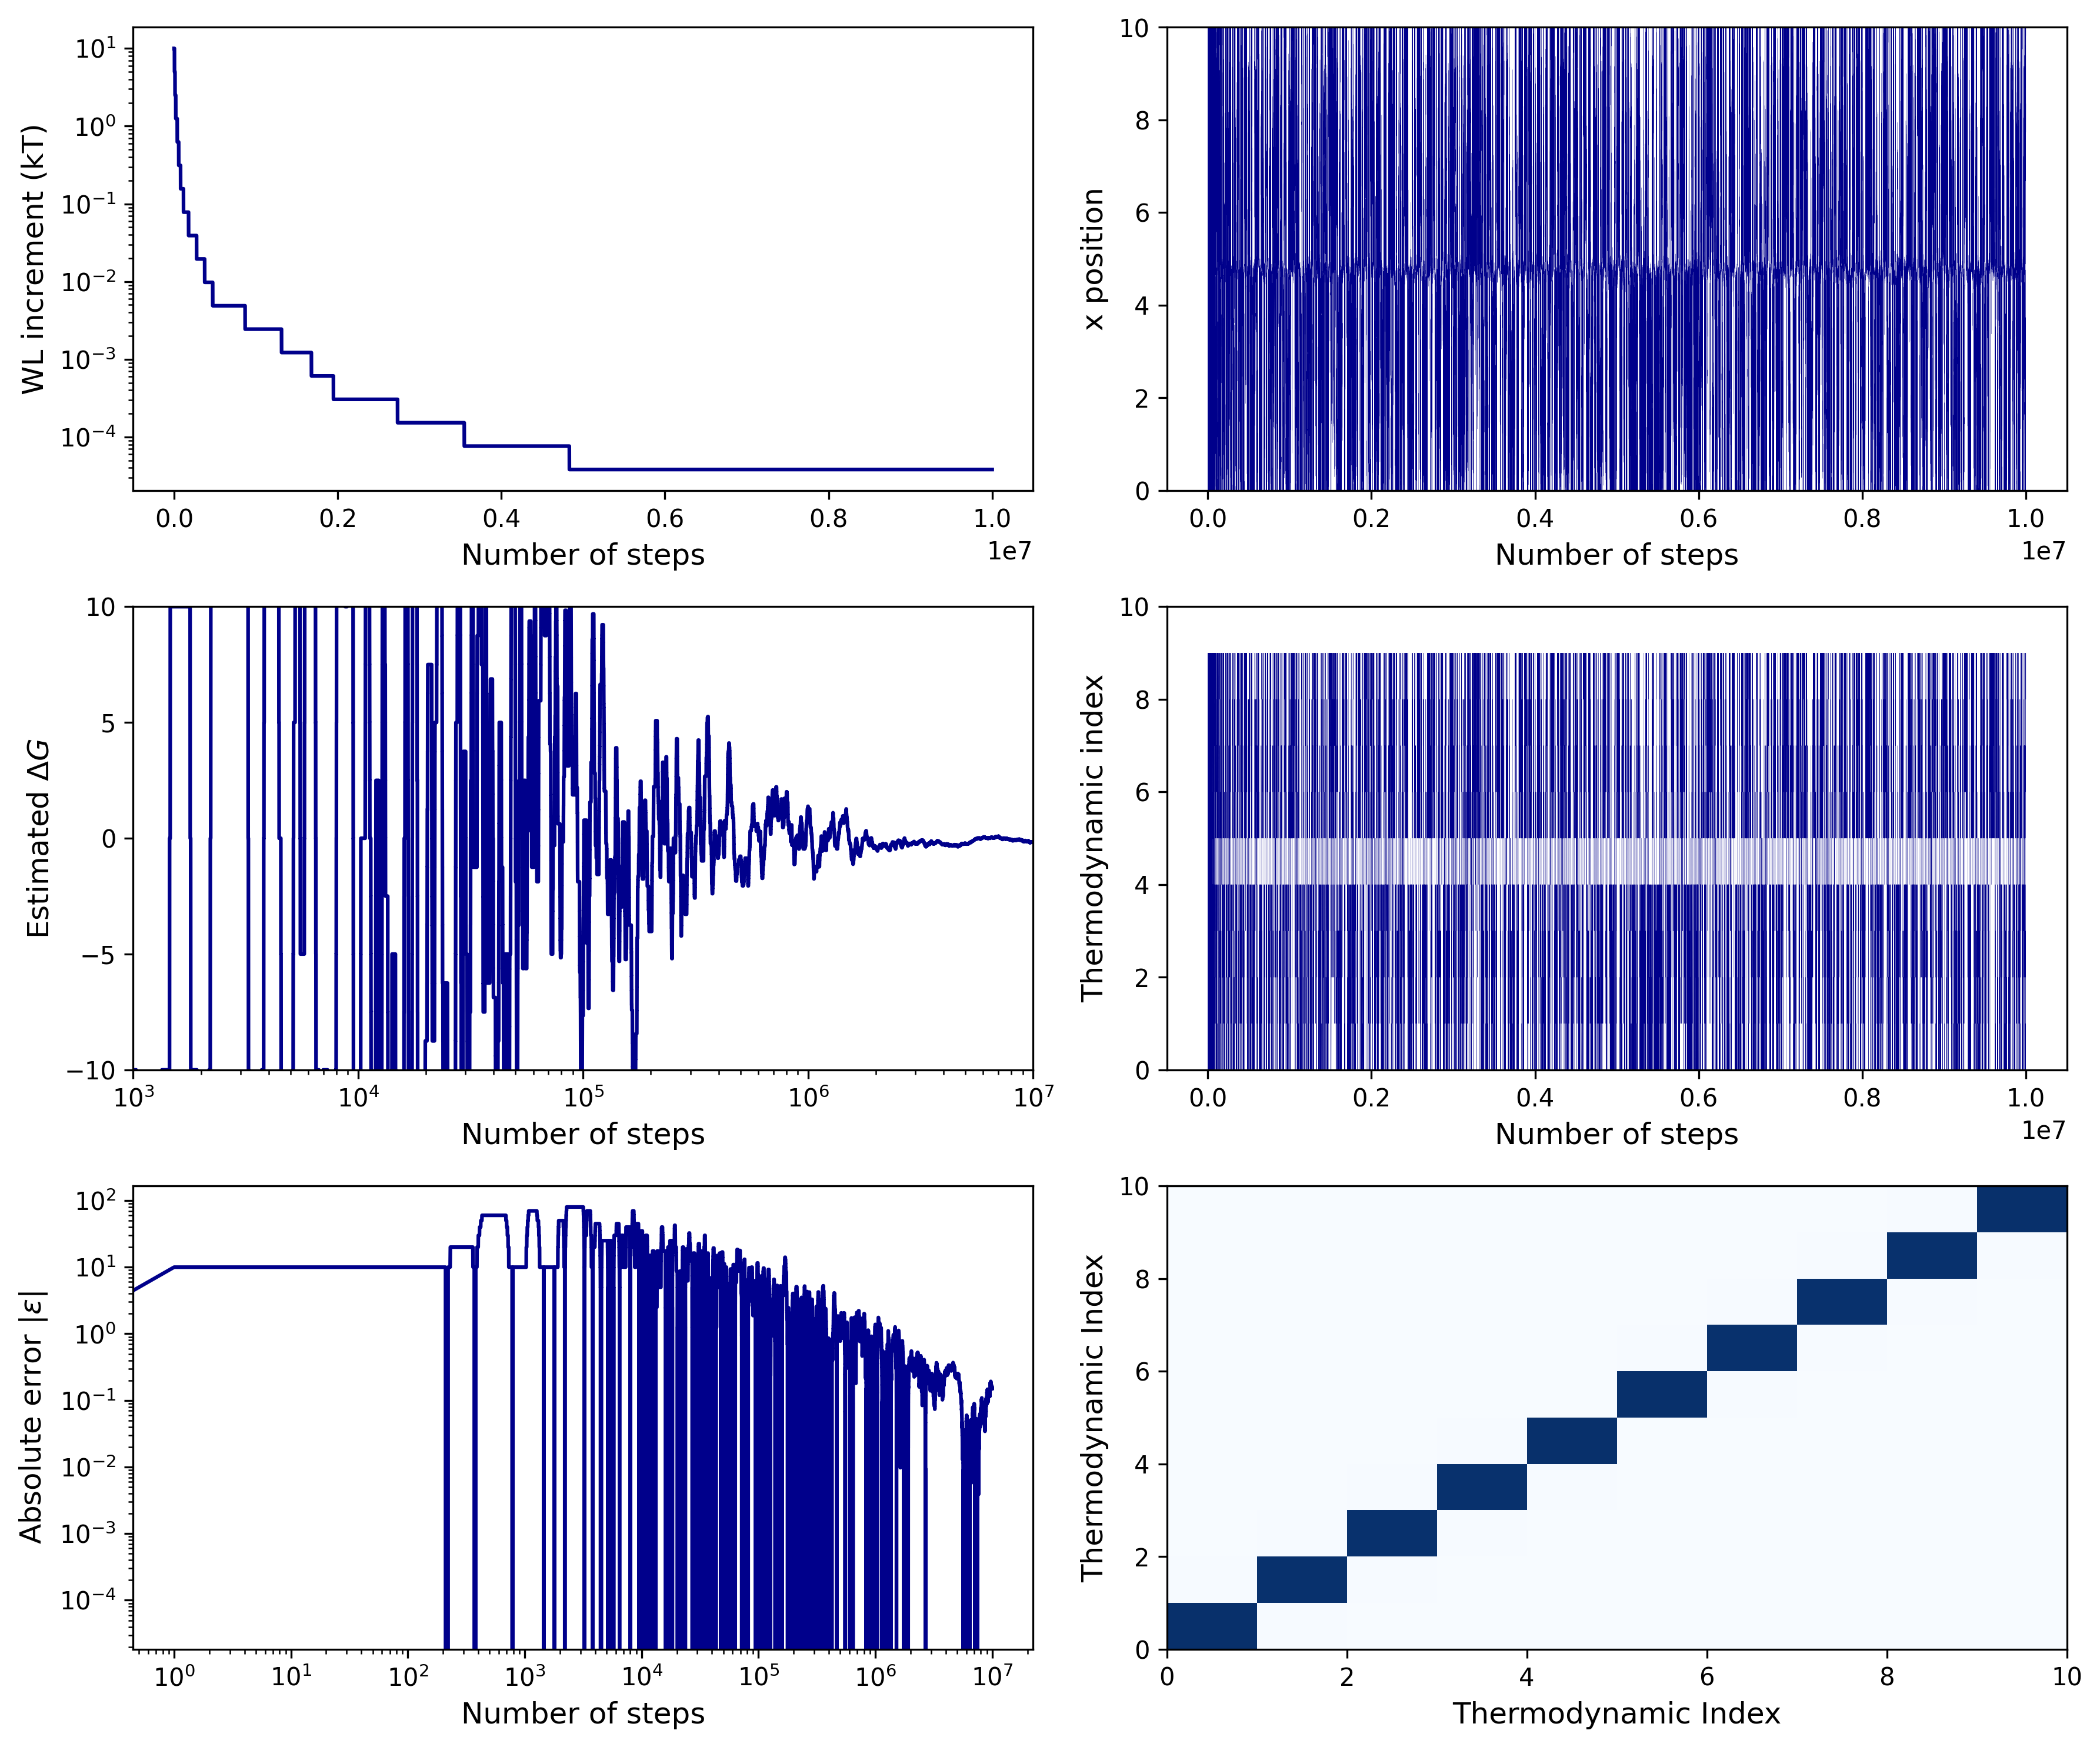

In [29]:
plot_wl_trajectories(nstep=10000000, c_1_over_t='1')

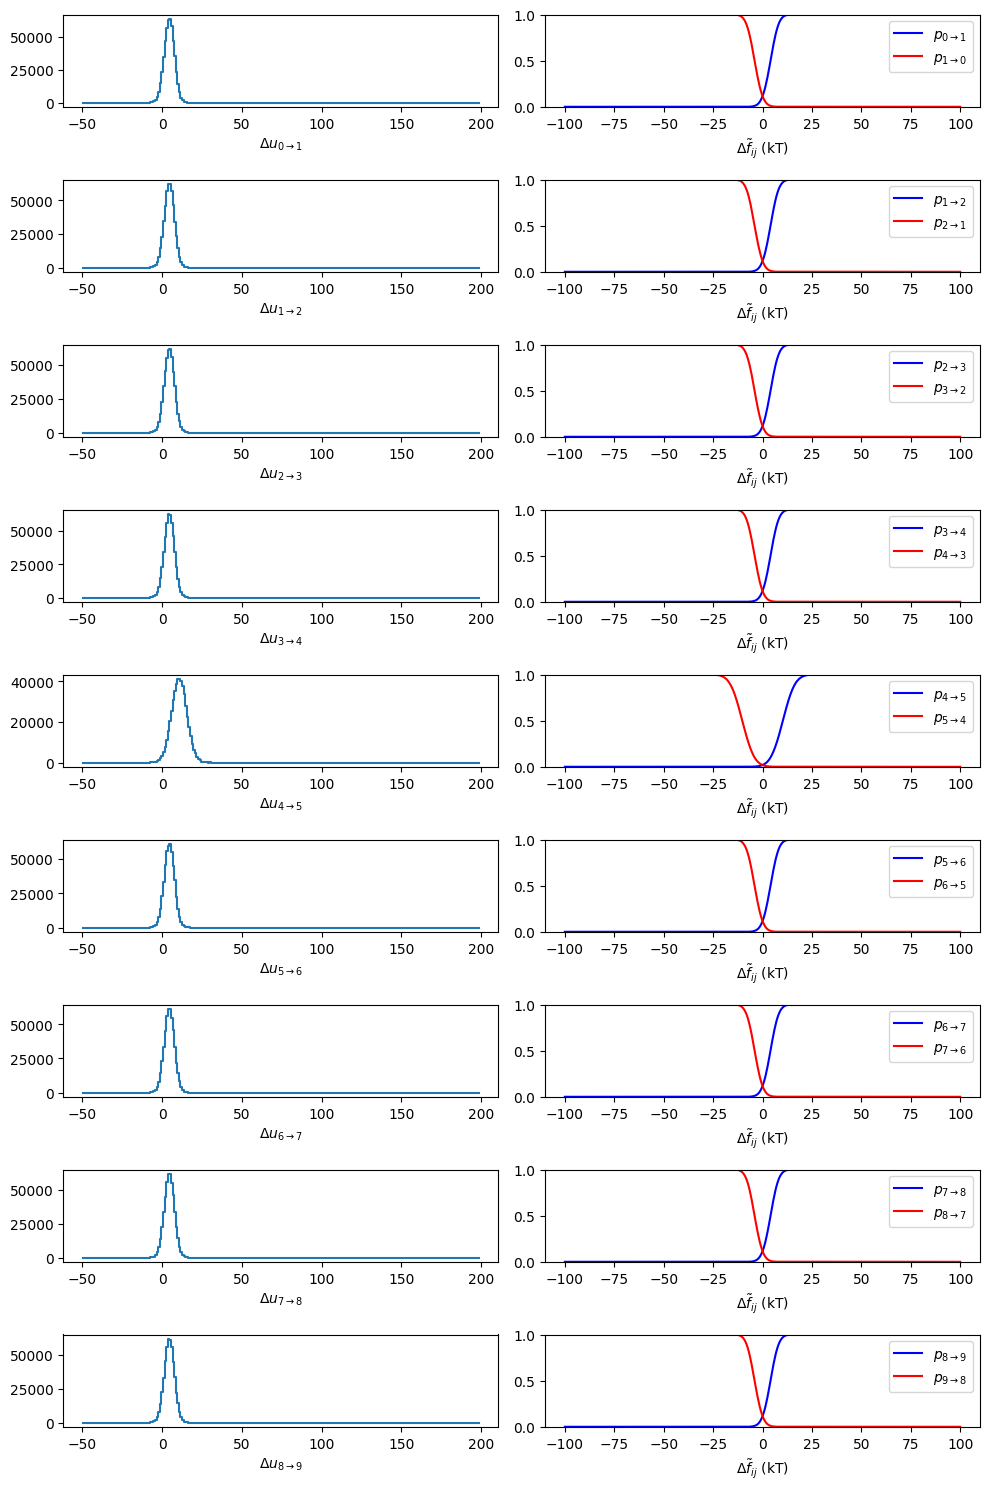

In [33]:
plot_delta_energy_distribution(nstep=10000000, n_ensembles= 10, c_1_over_t='1')

# showing the saturation error happen in toy model

# C = 0.01

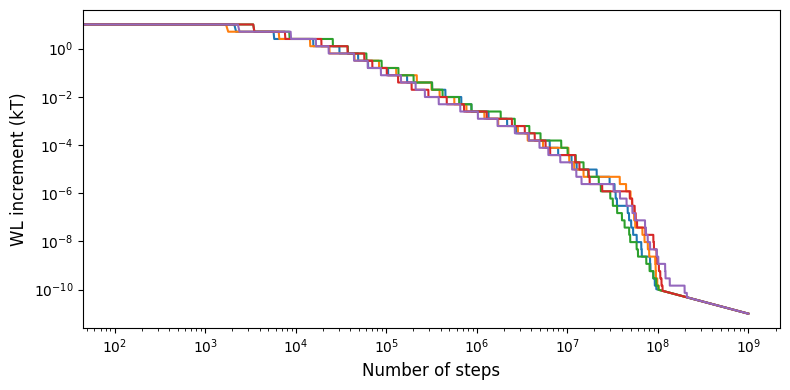

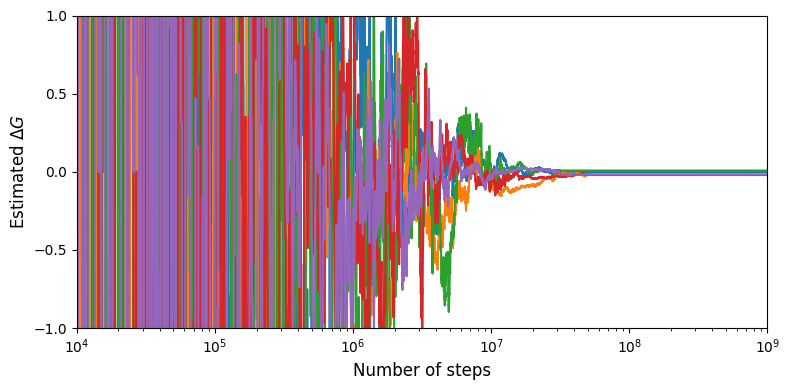

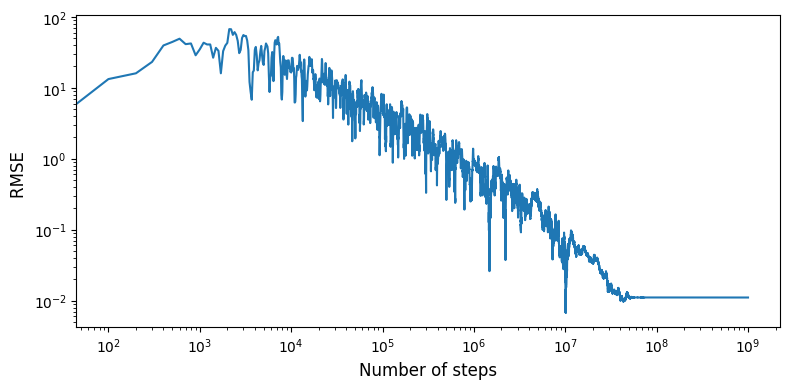

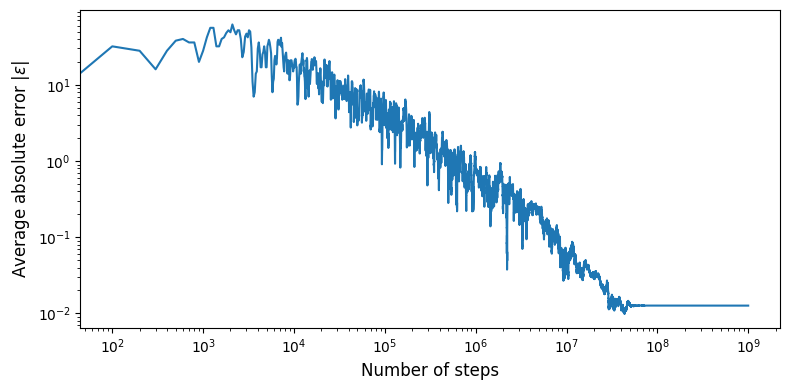

In [91]:
nstep=int(1e9)
save_label='0.01constant_switchlto_c_equal0.01_no_histogramflat_5traces'
plot_labels = ['2nd','3rd','6th','7th','9th'] #2  6  3  9  7
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
calculate_rmse(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)

rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)

relaxation_time 3989.85792832818
change_indices: [    23     82    145    298    438    627    877   1381   2011   3006
   4874   8302  11520  15845  36211  48763  64478  90233 113204 145365
 161039 232805 246537 322933 390136]
Step lengths per plateau: [   2300    5800    6200   15200   13900   18800   24900   50300   62900
   99400  186700  342700  321700  432400 2036500 1255100 1571400 2575400
 2297000 3216000 1567300 7176500 1373100 7639500 6720200 1986200]


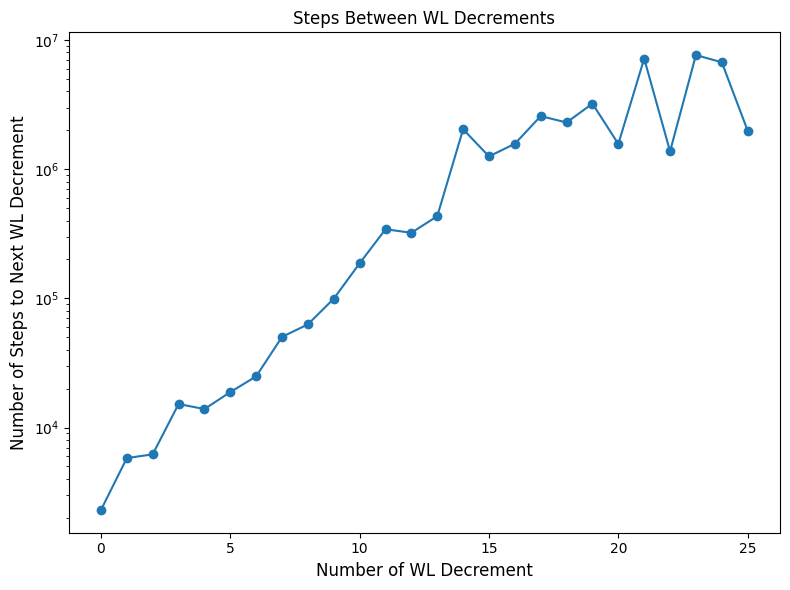

Decrement | Steps
----------|-------
        0 | 2300
        1 | 5800
        2 | 6200
        3 | 15200
        4 | 13900
        5 | 18800
        6 | 24900
        7 | 50300
        8 | 62900
        9 | 99400
       10 | 186700
       11 | 342700
       12 | 321700
       13 | 432400
       14 | 2036500
       15 | 1255100
       16 | 1571400
       17 | 2575400
       18 | 2297000
       19 | 3216000
       20 | 1567300
       21 | 7176500
       22 | 1373100
       23 | 7639500
       24 | 6720200
       25 | 1986200


In [93]:
plot_labels = ['2nd'] #,'3rd','4th','5th','6th','7th','8th','9th'] #2  6  3  9  7
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')

for suffix in plot_labels:
    T_counts = np.load(f'{proj_path}/trajectories/T_counts_at1000000000step_10constant_switchlto_c_equal10_no_histogramflat_{suffix}.npy')
    #plot_transition_probability_matrix(T_counts)
    mixing_time = get_mixing_time_from_transition_matrix(T_counts)
    step_over_mixing_time = step_traj/mixing_time
    np.save(f'{proj_path}/trajectories/step_traj_0-1000000000step_10constant_switchlto_c_equal10_no_histogramflat_step_over_mixing_time_{suffix}.npy',step_over_mixing_time)

step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')[:410000]
wl_traj = np.load(f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_10constant_switchlto_c_equal10_no_histogramflat_2nd.npy')[:410000]
plot_wl_decrement_steps(step_traj, wl_traj)

change_indices: [     25      67     135     229     378     589    1075    1410    1774
    2956    3835    5715    9059   12488   16922   31632   55436   71631
  102936  109671  159718  179525  281433  293290  325365  333983  364211
  386727  477267  536513  571209  655570  670773  689011  762803  779853
  811846  991568 1023653 1052578 1066636 1085923 1128507 1149614 1156892
 1172864 1368837 1382512 1536034 1588103 1626812 1806314 1930296 1943980
 1979370 2226720 2238114 2331099 2339276 2370125 2406309 2475155 2936455
 3056134 3060972 3072706 3139551 3143968 3167917 3221568 3276606 4106236
 4125210 4168545 4179190 4220022 4239800 4256687 4281710 4353899 4531442
 4582918 4601872 4809428 4896103 4906381 4938423 4956426 4974011 4985030
 5093168 5174513 5601703 5706245 5761863 5776584 5782895 5950924 5962650
 6098391 6157716 6176853 6268304 6329373 6352787 6392048 6433778 6458046
 6490712 6728101 6751736 6816568 6852829 6904971 6985003 7042847 7061934
 7101485 7108554 7176592 7261594 72

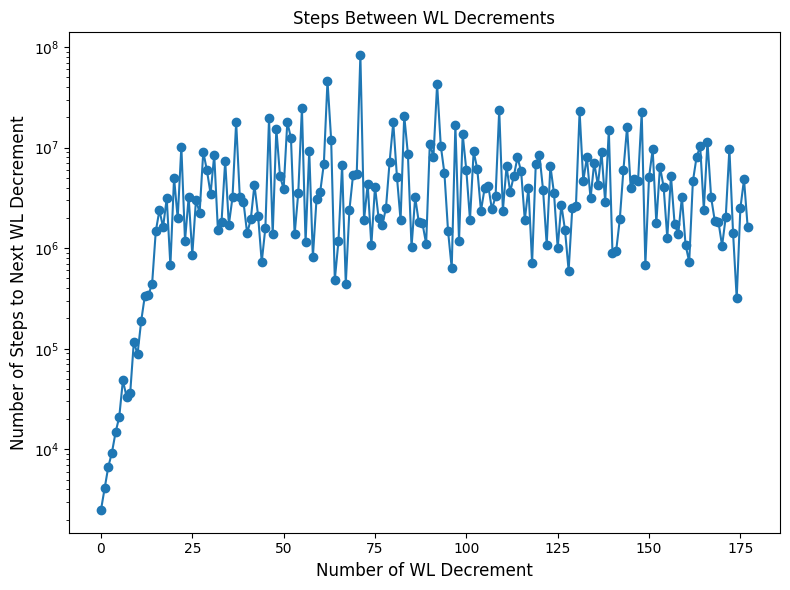

Decrement | Steps
----------|-------
        0 | 2500
        1 | 4100
        2 | 6700
        3 | 9300
        4 | 14800
        5 | 21000
        6 | 48500
        7 | 33400
        8 | 36300
        9 | 118100
       10 | 87800
       11 | 187900
       12 | 334300
       13 | 342800
       14 | 443300
       15 | 1470900
       16 | 2380300
       17 | 1619400
       18 | 3130400
       19 | 673400
       20 | 5004600
       21 | 1980600
       22 | 10190700
       23 | 1185600
       24 | 3207400
       25 | 861700
       26 | 3022700
       27 | 2251500
       28 | 9053900
       29 | 5924500
       30 | 3469500
       31 | 8436000
       32 | 1520200
       33 | 1823700
       34 | 7379100
       35 | 1704900
       36 | 3199200
       37 | 17972100
       38 | 3208400
       39 | 2892400
       40 | 1405700
       41 | 1928600
       42 | 4258300
       43 | 2110600
       44 | 727700
       45 | 1597100
       46 | 19597200
       47 | 1367400
       48 | 15352100
       49 |

In [94]:
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_traj = np.load(f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_noconstant_noswitch_wL_only_2nd.npy')
plot_wl_decrement_steps(step_traj, wl_traj)

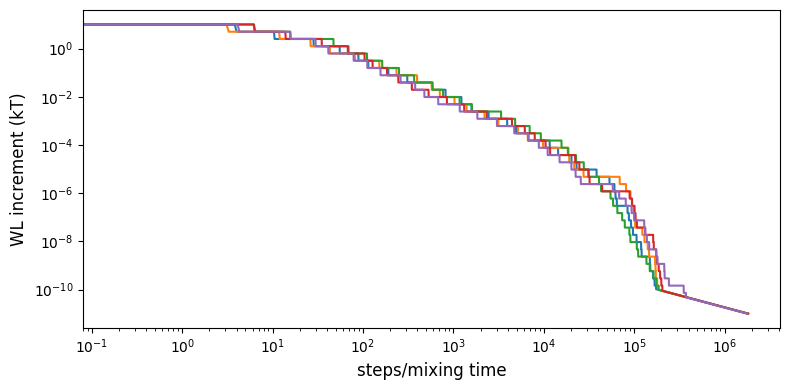

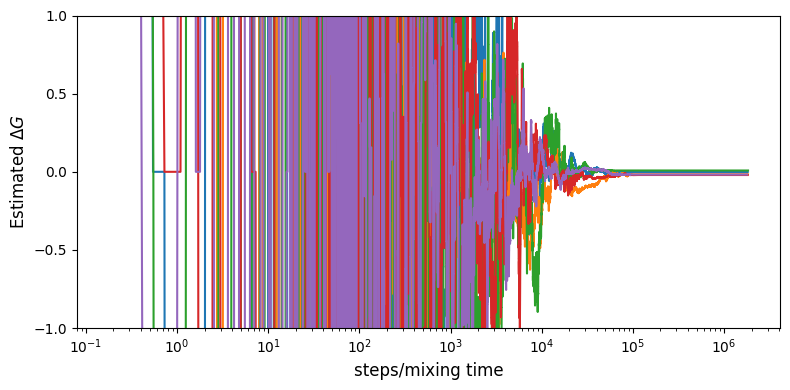

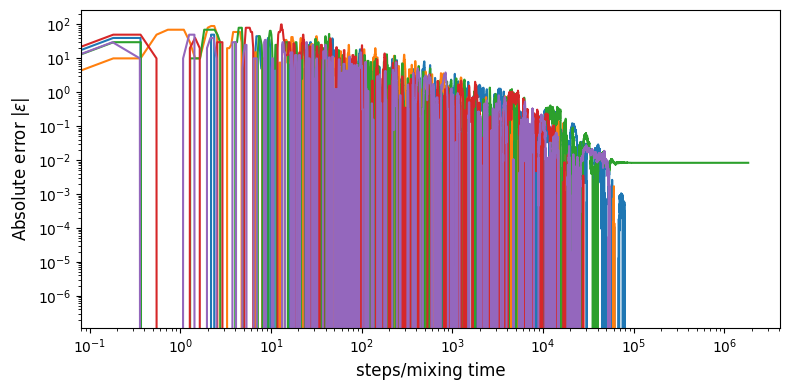

In [ ]:
nstep=int(1e9)
save_label='0.01constant_switchlto_c_equal0.01_no_histogramflat_5traces'
plot_labels = ['2nd','3rd','6th','7th','9th'] #2  6  3  9  7
step_traj = [f'{proj_path}/trajectories/step_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_step_over_mixing_time_{suffix}.npy'
    for suffix in plot_labels]
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
#calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False,t_over_mixing_time=True)
free_energy_of_multiple_traces(free_energy_files step_traj,nstep,save_label,show_legend = False,t_over_mixing_time= True)
abs_error_of_multiple_traces_nonzero(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False, t_over_mixing_time = True)

eigenvalues:  [0.79242408 0.79320401 0.84780776 0.8506959  0.91563325 0.92088519
 1.         0.99751736 0.97176396 0.97825149]


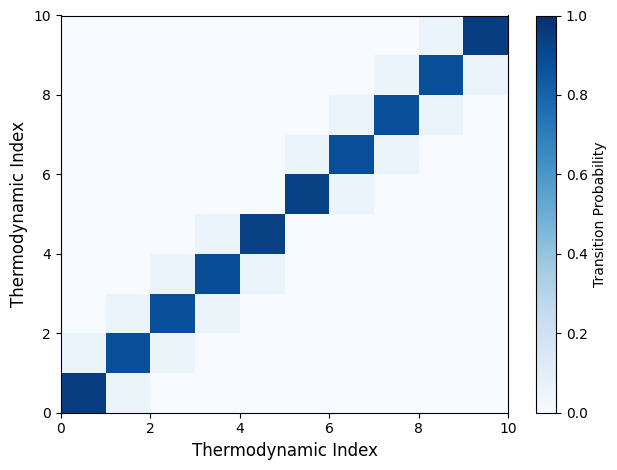

mixing_time, second_largest_eigenvalue: 558.3949948081945 0.9975173589054177
relaxation_time 402.2966377895252
mixing_time 558.3949948081945


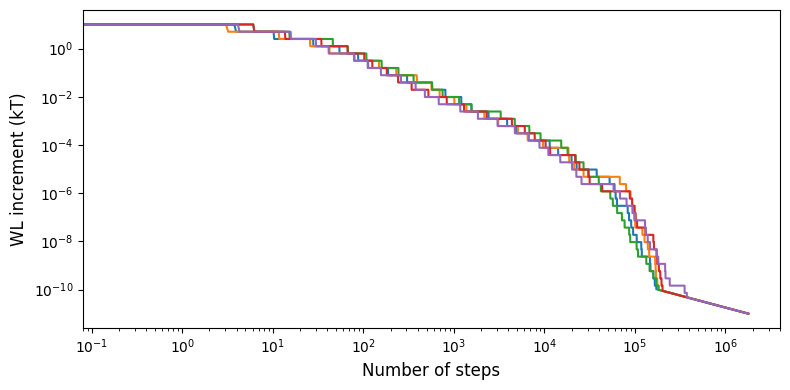

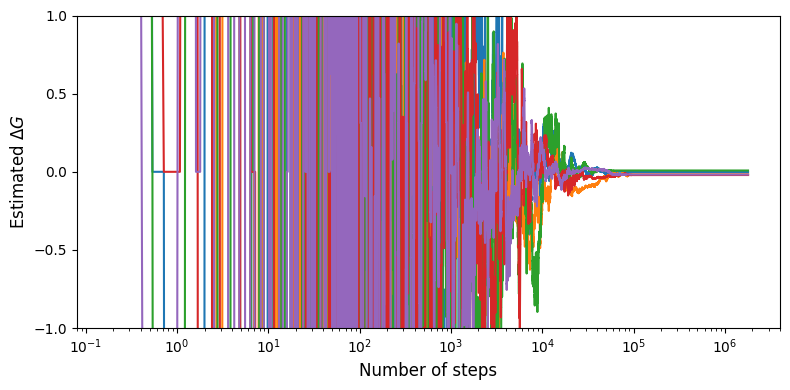

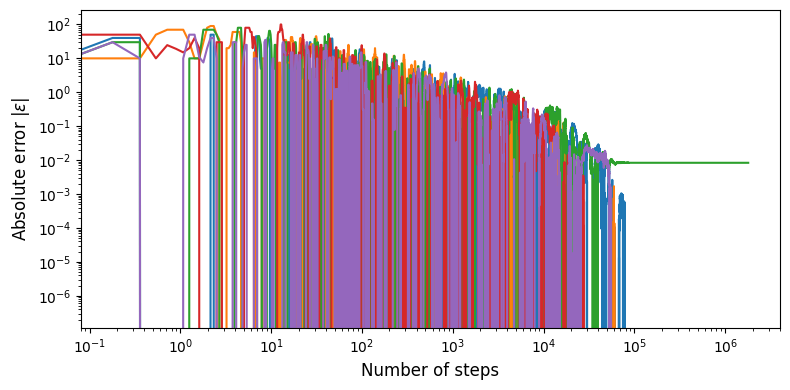

In [ ]:
T_counts = np.load(f'{proj_path}/trajectories/T_counts_at1000000000step_noconstant_noswitch_wL_only_1st.npy')
plot_transition_probability_matrix(T_counts)
mixing_time = get_mixing_time_from_transition_matrix(T_counts)
print('mixing_time',mixing_time)
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
step_over_mixing_time = step_traj/mixing_time 

# C = 0.1

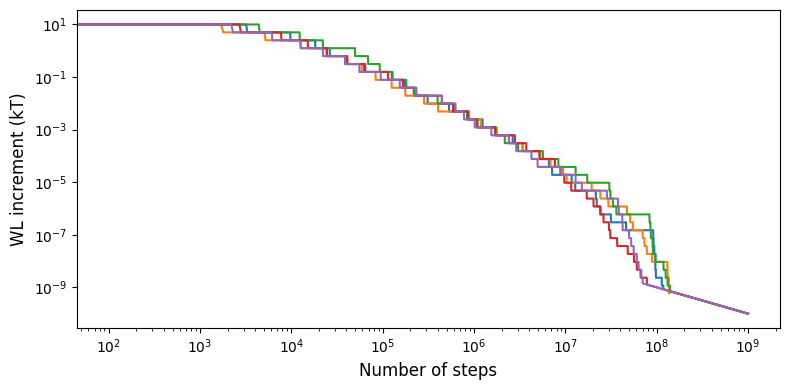

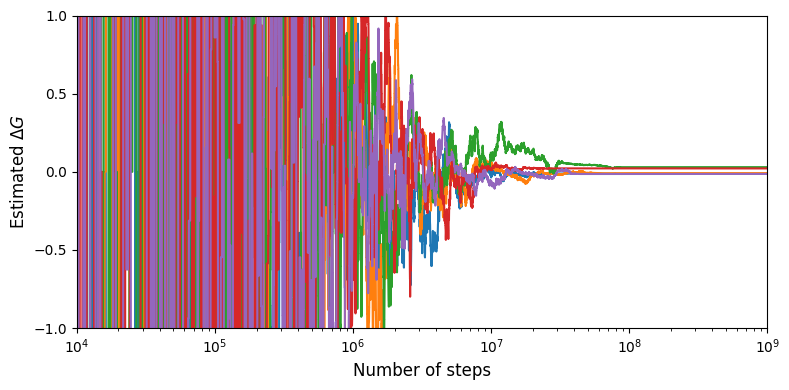

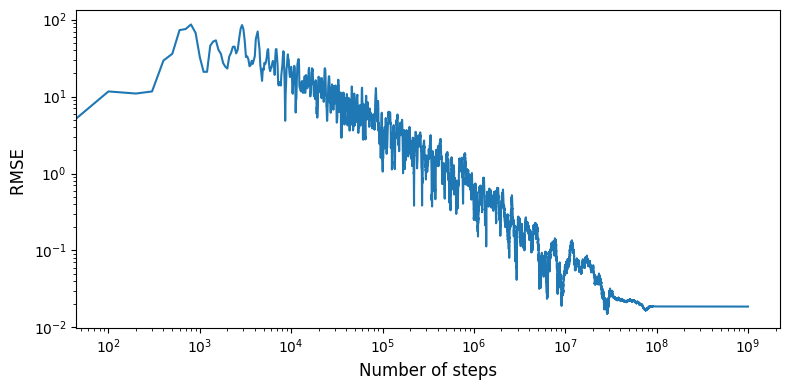

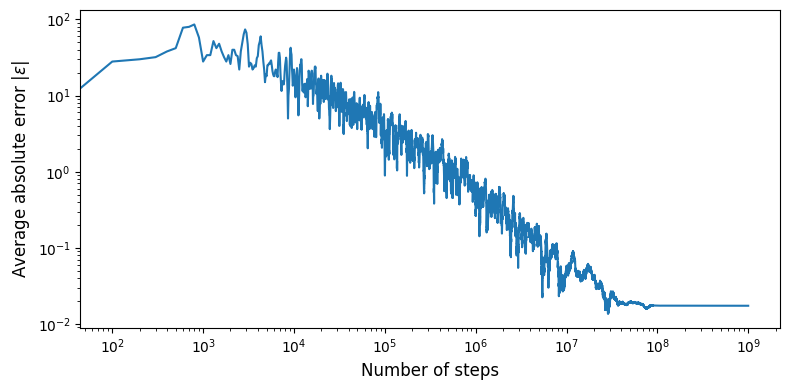

In [95]:
nstep=int(1e9)
save_label='0.1constant_switchlto_c_equal0.1_no_histogramflat_5traces'
plot_labels = ['1st','4th','5th','6th','10th'] #4  1 10  6  5
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.1constant_switchlto_c_equal0.1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.1constant_switchlto_c_equal0.1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)
calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)

change_indices: [     25      67     135     229     378     589    1075    1410    1774
    2956    3835    5715    9059   12488   16922   31632   55436   71631
  102936  109671  159718  179525  281433  293290  325365  333983  364211
  386727  477267  536513  571209  655570  670773  689011  762803  779853
  811846  991568 1023653 1052578 1066636 1085923 1128507 1149614 1156892
 1172864 1368837 1382512 1536034 1588103 1626812 1806314 1930296 1943980
 1979370 2226720 2238114 2331099 2339276 2370125 2406309 2475155 2936455
 3056134 3060972 3072706 3139551 3143968 3167917 3221568 3276606 4106236
 4125210 4168545 4179190 4220022 4239800 4256687 4281710 4353899 4531442
 4582918 4601872 4809428 4896103 4906381 4938423 4956426 4974011 4985030
 5093168 5174513 5601703 5706245 5761863 5776584 5782895 5950924 5962650
 6098391 6157716 6176853 6268304 6329373 6352787 6392048 6433778 6458046
 6490712 6728101 6751736 6816568 6852829 6904971 6985003 7042847 7061934
 7101485 7108554 7176592 7261594 72

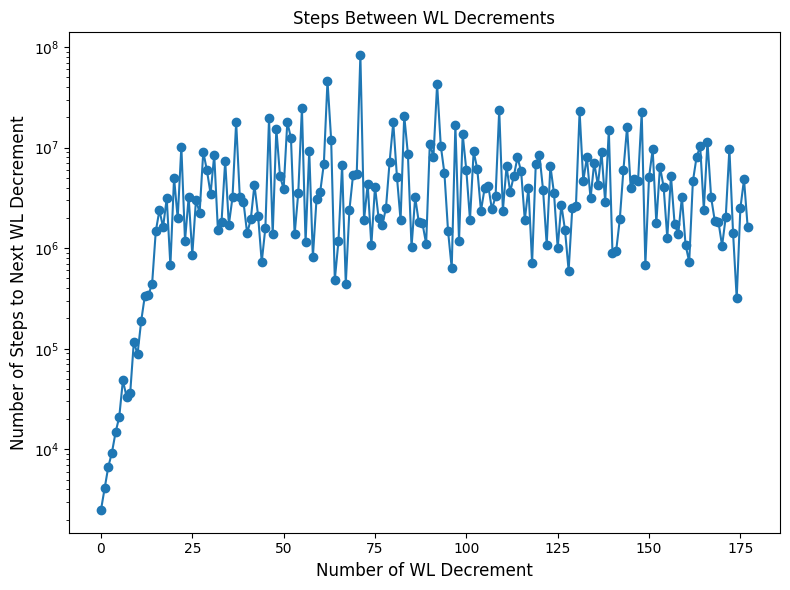

Decrement | Steps
----------|-------
        0 | 2500
        1 | 4100
        2 | 6700
        3 | 9300
        4 | 14800
        5 | 21000
        6 | 48500
        7 | 33400
        8 | 36300
        9 | 118100
       10 | 87800
       11 | 187900
       12 | 334300
       13 | 342800
       14 | 443300
       15 | 1470900
       16 | 2380300
       17 | 1619400
       18 | 3130400
       19 | 673400
       20 | 5004600
       21 | 1980600
       22 | 10190700
       23 | 1185600
       24 | 3207400
       25 | 861700
       26 | 3022700
       27 | 2251500
       28 | 9053900
       29 | 5924500
       30 | 3469500
       31 | 8436000
       32 | 1520200
       33 | 1823700
       34 | 7379100
       35 | 1704900
       36 | 3199200
       37 | 17972100
       38 | 3208400
       39 | 2892400
       40 | 1405700
       41 | 1928600
       42 | 4258300
       43 | 2110600
       44 | 727700
       45 | 1597100
       46 | 19597200
       47 | 1367400
       48 | 15352100
       49 |

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [80]:
import numpy as np
import matplotlib.pyplot as plt

    
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_traj = np.load(f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_noconstant_noswitch_wL_only_2nd.npy')
plot_wl_decrement_steps(step_traj, wl_traj)


# C = 0

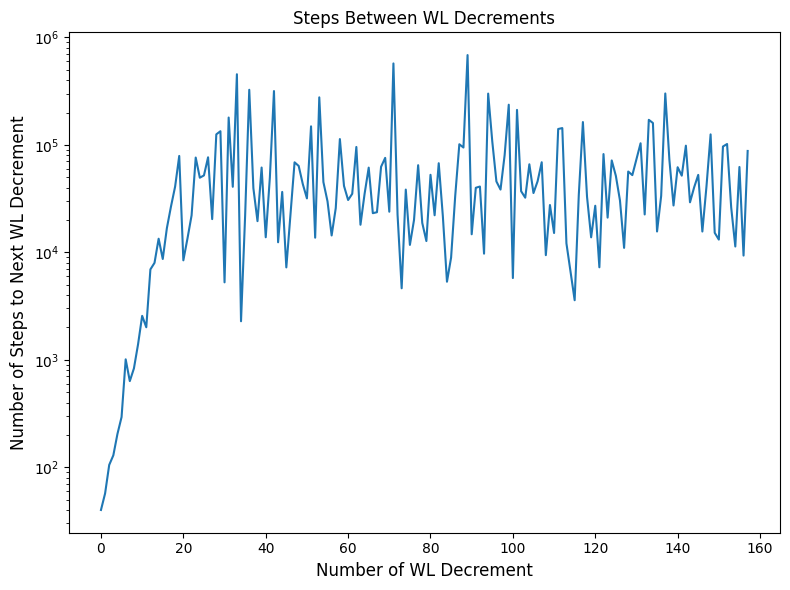

Decrement | Steps
----------|-------
        0 | 40
        1 | 57
        2 | 105
        3 | 129
        4 | 204
        5 | 293
        6 | 1009
        7 | 633
        8 | 831
        9 | 1390
       10 | 2562
       11 | 2006
       12 | 6934
       13 | 7979
       14 | 13385
       15 | 8671
       16 | 16790
       17 | 26725
       18 | 40875
       19 | 78854
       20 | 8421
       21 | 13441
       22 | 22069
       23 | 76162
       24 | 49457
       25 | 51944
       26 | 76559
       27 | 20368
       28 | 125221
       29 | 133951
       30 | 5253
       31 | 179540
       32 | 40710
       33 | 454019
       34 | 2282
       35 | 22009
       36 | 325498
       37 | 39539
       38 | 19496
       39 | 61505
       40 | 13803
       41 | 49512
       42 | 316705
       43 | 12397
       44 | 36465
       45 | 7236
       46 | 22243
       47 | 68787
       48 | 63632
       49 | 43130
       50 | 31759
       51 | 148701
       52 | 13680
       53 | 276731
       54 | 

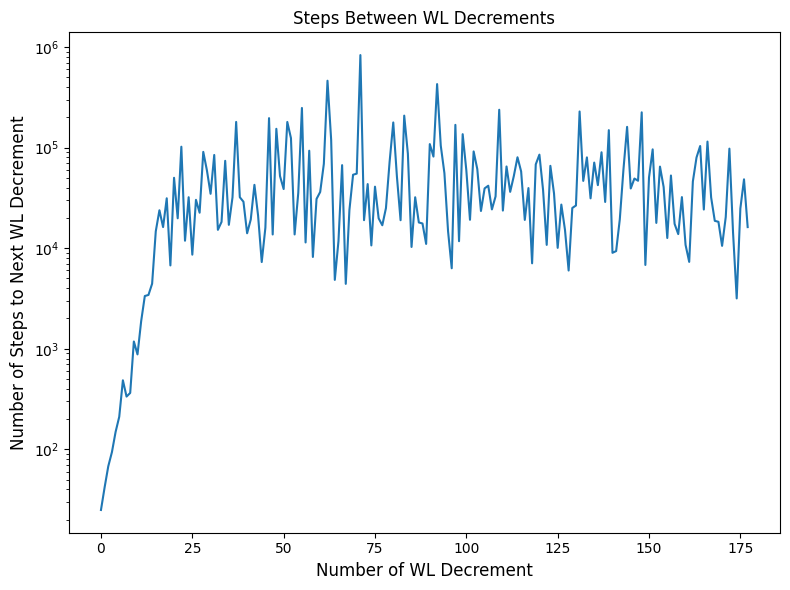

Decrement | Steps
----------|-------
        0 | 25
        1 | 42
        2 | 68
        3 | 94
        4 | 149
        5 | 211
        6 | 486
        7 | 335
        8 | 364
        9 | 1182
       10 | 879
       11 | 1880
       12 | 3344
       13 | 3429
       14 | 4434
       15 | 14710
       16 | 23804
       17 | 16195
       18 | 31305
       19 | 6735
       20 | 50047
       21 | 19807
       22 | 101908
       23 | 11857
       24 | 32075
       25 | 8618
       26 | 30228
       27 | 22516
       28 | 90540
       29 | 59246
       30 | 34696
       31 | 84361
       32 | 15203
       33 | 18238
       34 | 73792
       35 | 17050
       36 | 31993
       37 | 179722
       38 | 32085
       39 | 28925
       40 | 14058
       41 | 19287
       42 | 42584
       43 | 21107
       44 | 7278
       45 | 15972
       46 | 195973
       47 | 13675
       48 | 153522
       49 | 52069
       50 | 38709
       51 | 179502
       52 | 123982
       53 | 13684
       54 | 35390

In [29]:

nstep=int(1e9)
plot_labels = ['1st','2nd']#,'3rd','4th','5th','6th','7th','8th','9th'] #2  6  3  9  7

for suffix in plot_labels:
    wl_traj = np.load(f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_noconstant_noswitch_wL_only_{suffix}.npy')
    plot_wl_decrement_steps(wl_traj)

In [13]:
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th'] #2  6  3  9  7
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')

for suffix in plot_labels:
    T_counts = np.load(f'{proj_path}/trajectories/T_counts_at1000000000step_noconstant_noswitch_wL_only_{suffix}.npy')
    #plot_transition_probability_matrix(T_counts)
    mixing_time = get_mixing_time_from_transition_matrix(T_counts)
    step_over_mixing_time = step_traj/mixing_time
    np.save(f'{proj_path}/trajectories/step_traj_0-1000000000step_10constant_switchlto_c_equal10_no_histogramflat_step_over_mixing_time_{suffix}.npy',step_over_mixing_time)

mixing_time, second_largest_eigenvalue: 558.3949948081945 0.9975173589054177
relaxation_time 402.2966377895252
mixing_time, second_largest_eigenvalue: 557.6745965907481 0.9975141518555897
relaxation_time 401.77698005371803
mixing_time, second_largest_eigenvalue: 551.9858969707909 0.9974885330064995
relaxation_time 397.6734485480572
mixing_time, second_largest_eigenvalue: 553.9635313002777 0.9974974988734981
relaxation_time 399.10001091701156
mixing_time, second_largest_eigenvalue: 559.4482913134943 0.9975220330767923
relaxation_time 403.0564310023987
mixing_time, second_largest_eigenvalue: 545.7293550217778 0.9974597401654075
relaxation_time 393.16030512110115
mixing_time, second_largest_eigenvalue: 545.6593031548466 0.9974594140462653
relaxation_time 393.10977335334195
mixing_time, second_largest_eigenvalue: 553.8801824938287 0.9974971222929874
relaxation_time 399.03988743068703
mixing_time, second_largest_eigenvalue: 554.2444920618798 0.9974987674555634
relaxation_time 399.3026813717

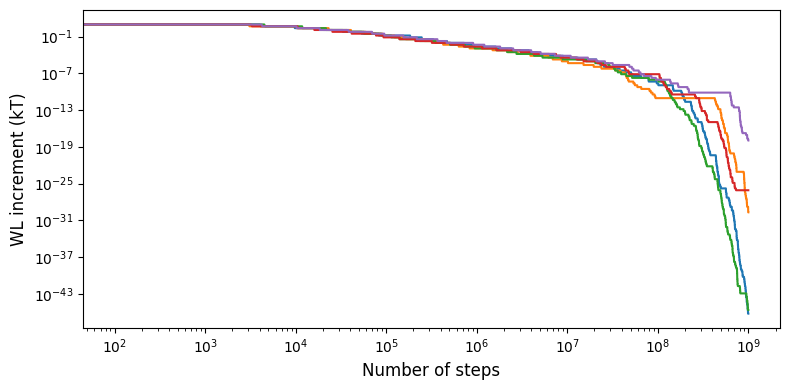

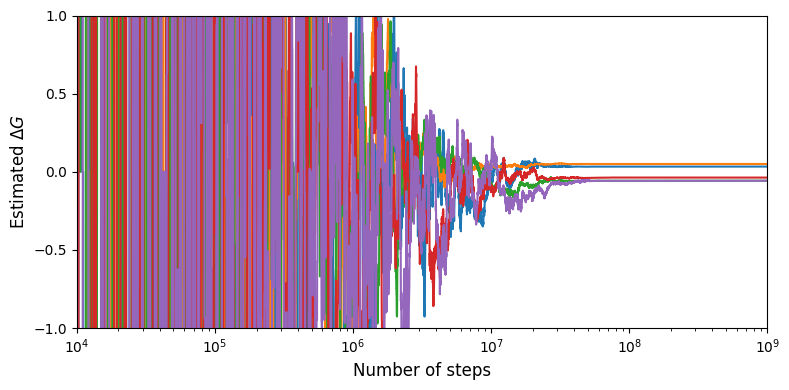

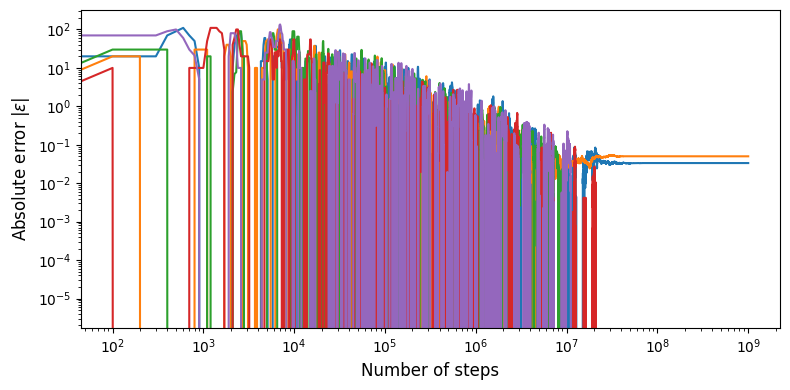

In [ ]:
nstep=int(1e9)
init_step=0
save_label = 'noconstant_noswitch_wL_only_5traces'
plot_labels = ['1st','3rd','4th','9th','10th'] #1  9  3  4 10

step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_noconstant_noswitch_wL_only.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_noconstant_noswitch_wL_only_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_noconstant_noswitch_wL_only_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple', 'red']  # Match the number of files  

calculate_free_energy_sdt(free_energy_files,save_label)
calculate_rmse(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep, save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = False)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, colors, step_traj, save_label, plot_labels, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


# C = 1

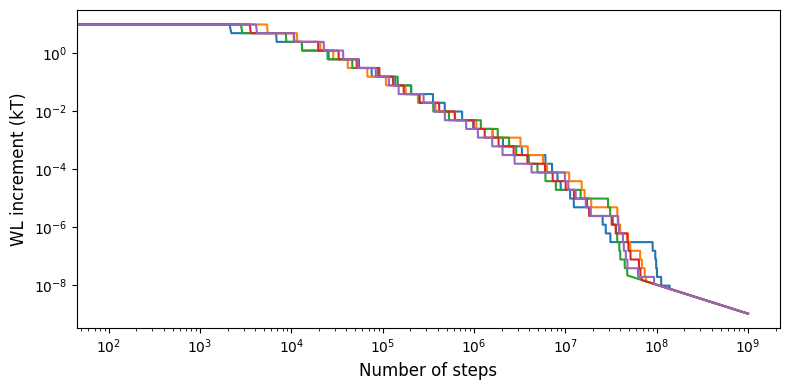

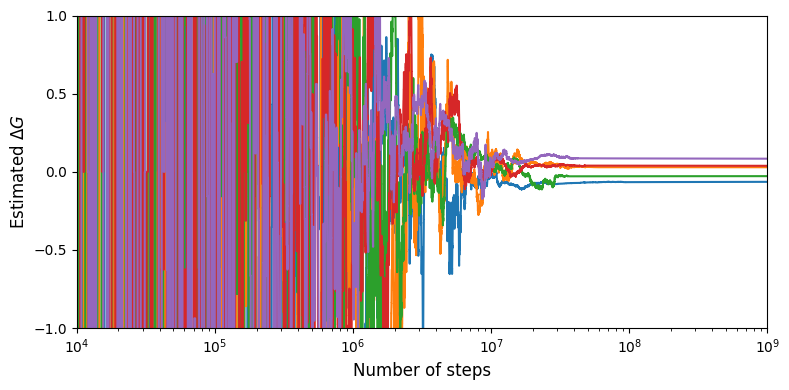

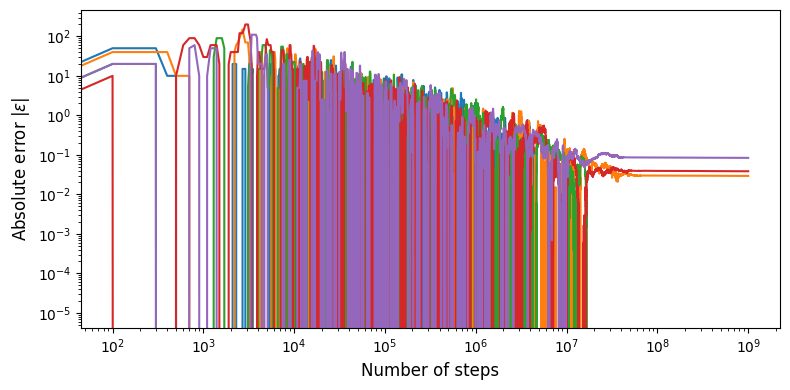

In [ ]:
nstep=int(1e9)
save_label='1constant_switchlto_c_equal1_no_histogramflat_5traces'
plot_labels = ['1st','4th','5th','6th','9th'] #good: 2,3,7,8,10, #bad: 1,4,5,6,9
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, colors, step_traj, save_label, plot_labels, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


# C = 10

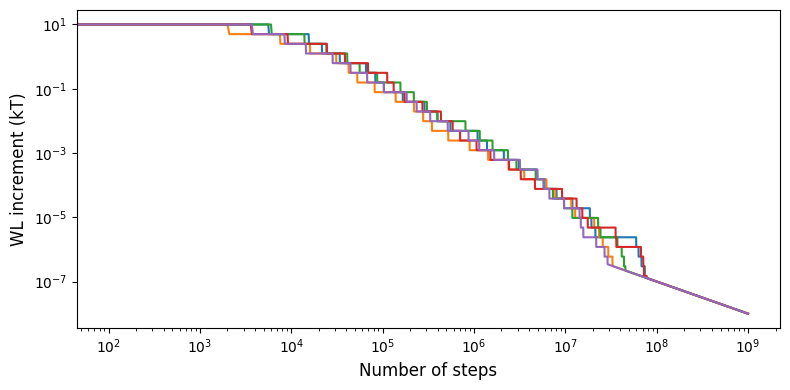

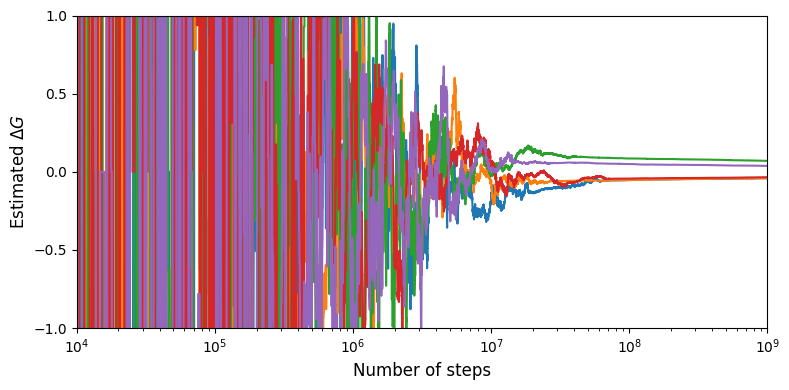

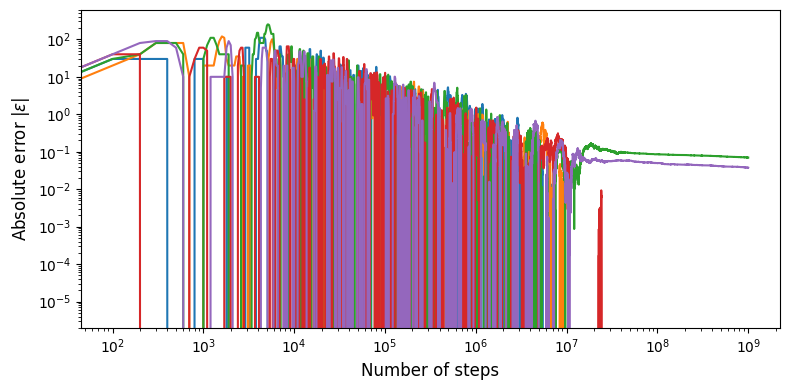

In [ ]:
nstep=int(1e9)
save_label='10constant_switchlto_c_equal10_no_histogramflat_5traces'
plot_labels = ['1st','3rd','7th','9th','10th'] #2  5  4  8  6  #bad:1,3,7,9,10
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_10constant_switchlto_c_equal10_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_10constant_switchlto_c_equal10_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
calculate_rmse(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = False)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)

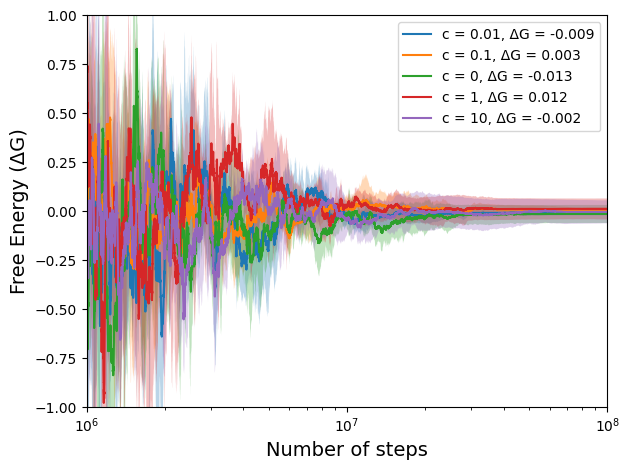

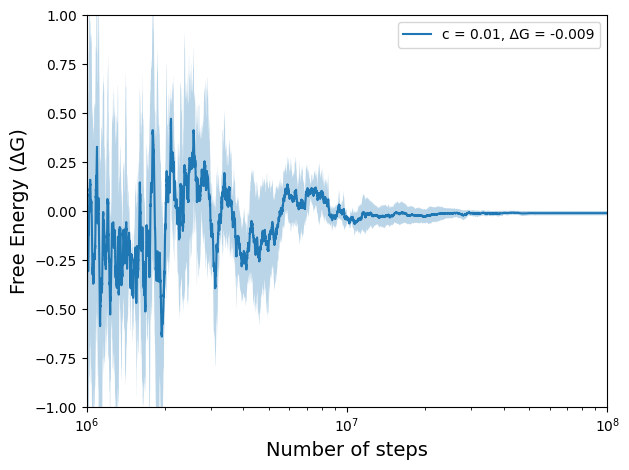

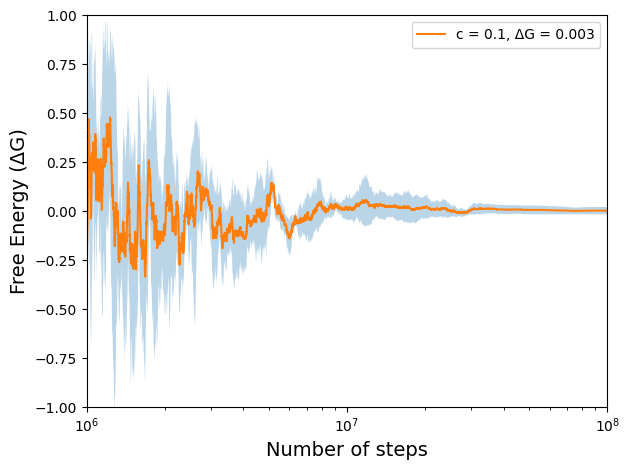

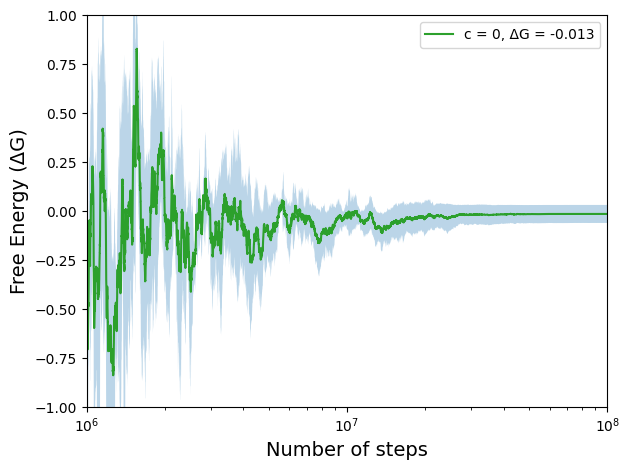

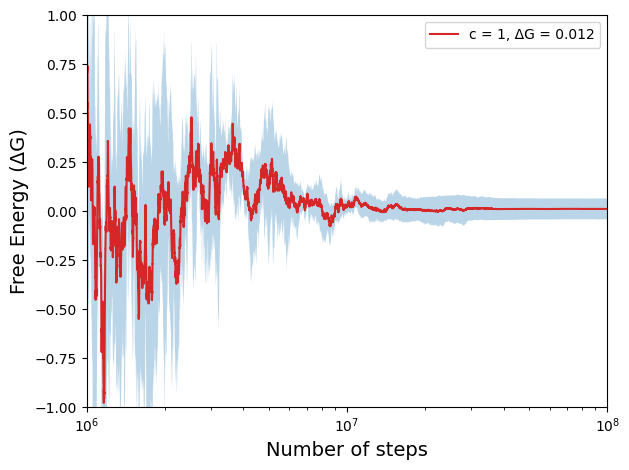

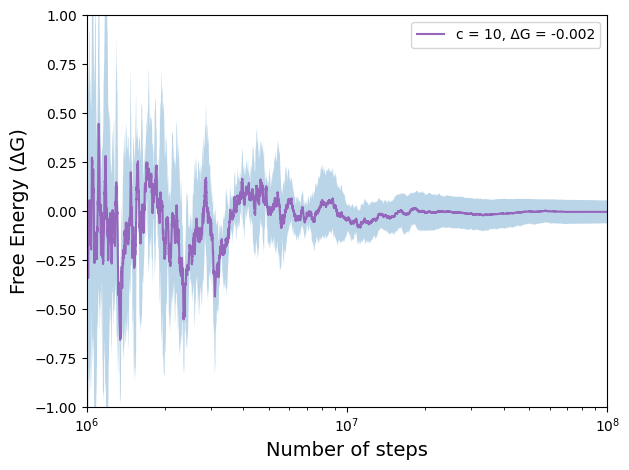

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1365386661.py:256: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1365386661.py:257: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/{save_label}.png', dpi=300, bbox_inches='tight')


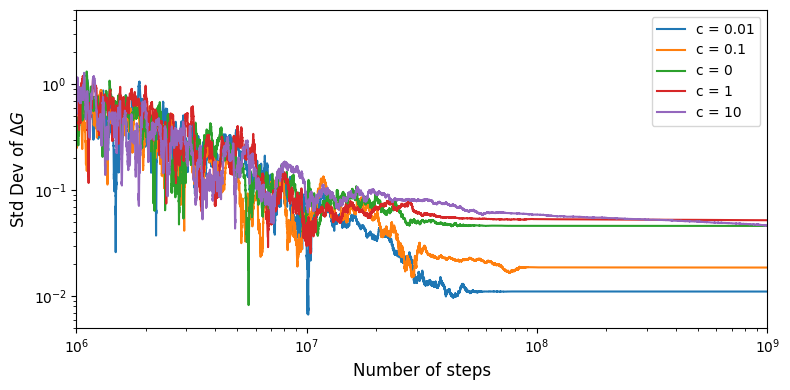

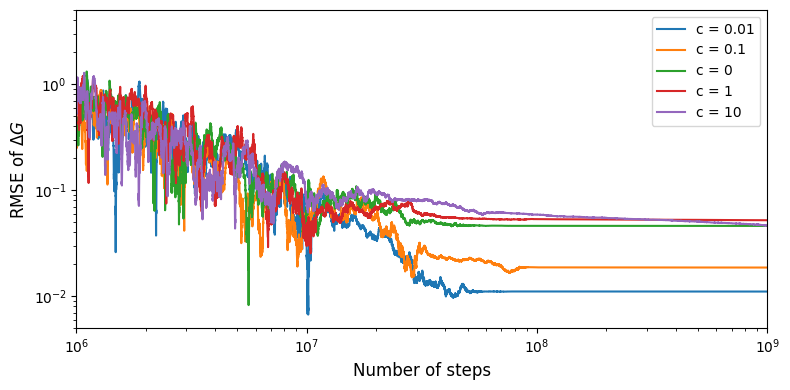

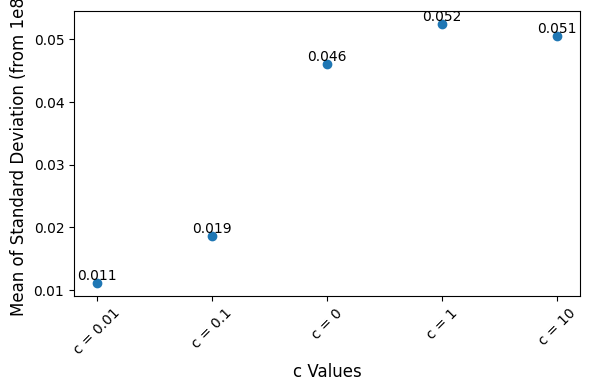

In [156]:
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy')
file_labels = ['0.01constant_switchlto_c_equal0.01_no_histogramflat_5traces','0.1constant_switchlto_c_equal0.1_no_histogramflat_5traces','noconstant_noswitch_wL_only_5traces','1constant_switchlto_c_equal1_no_histogramflat_5traces','10constant_switchlto_c_equal10_no_histogramflat_5traces']
color_codes= ['#1f77b4', '#ff7f0e','#2ca02c','#d62728', '#9467bd']
a = ['c = 0.01','c = 0.1','c = 0','c = 1','c = 10']#,'c = 100']
# Load mean free energy values from 1e8 to 1e9
mean_fe = [np.load(f'{proj_path}/trajectories/mean_free_energy_of_all_1e8_to_1e9_{label}.npy') for label in file_labels]

fe_mean_files = [f'{proj_path}/trajectories/mean_free_energy_of_multiple_traces_0axis_{suffix}.npy' for suffix in file_labels]
fe_std_files = [f'{proj_path}/trajectories/std_free_energy_of_multiple_traces_0axis_{suffix}.npy' for suffix in file_labels]
fe_rmse_files = [f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{suffix}.npy' for suffix in file_labels]

# Create plot labels using mean_fe values
plot_labels = [f'{j}, ΔG = {mean_fe[i]:.3f}' for i,j in zip(range(len(file_labels)),a)]
plot_free_energy_std_or_rmse(fe_mean_files, fe_std_files, step_traj, plot_labels, save_label='free_energy_mean_vs_std_comparision',colors=color_codes)
#plot_free_energy_std_or_rmse(fe_mean_files, fe_rmse_files, step_traj, plot_labels, save_label='free_energy_mean_vs_rmse_comparision',colors=color_codes)

# Plot first three datasets in separate plots
for i in range(5):
    plot_labels = [f'{a[i]}, ΔG = {mean_fe[i]:.3f}' ]
    color = [color_codes[i]]
    plot_free_energy_std_or_rmse([fe_mean_files[i]], [fe_std_files[i]], step_traj, plot_labels, save_label=f'free_energy_mean_vs_std_{file_labels[i]}',colors=color)
    #plot_free_energy_std_or_rmse([fe_mean_files[i]], [fe_rmse_files[i]], step_traj, plot_labels, save_label=f'free_energy_mean_vs_rmse_{file_labels[i]}',colors=color)

# Create plot of free energy standard deviation vs steps
plot_labels = [f'{a[i]}' for i in range(len(a))]
plot_std_or_rmse_free_energy_vs_steps(step_traj, fe_std_files,plot_labels, save_label= 'fe_sdt_vs_steps', show_legend = True,std=True)
plot_std_or_rmse_free_energy_vs_steps(step_traj, fe_rmse_files,plot_labels, save_label= 'fe_rmse_vs_steps', show_legend = True,rmse=True)

# create plot of free energy standard deviation vs variety of c constant
plot_mean_of_stds_vs_c_constants(fe_std_files, a)


With smaller $ c $, the slower decrement may allow the chain to mix more thoroughly, reducing saturation error by ensuring all states are adequately sampled.

With larger $ c $, the faster decrement might lead to a stationary distribution that is less accurate if mixing is incomplete, increasing saturation error.

# For 10 traces

## C = 0.01

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
/Users/nguyendung/opt/anaconda3/envs/AIO_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


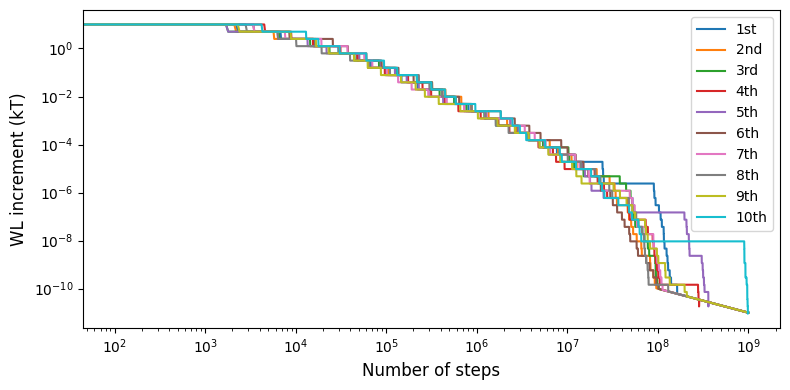

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


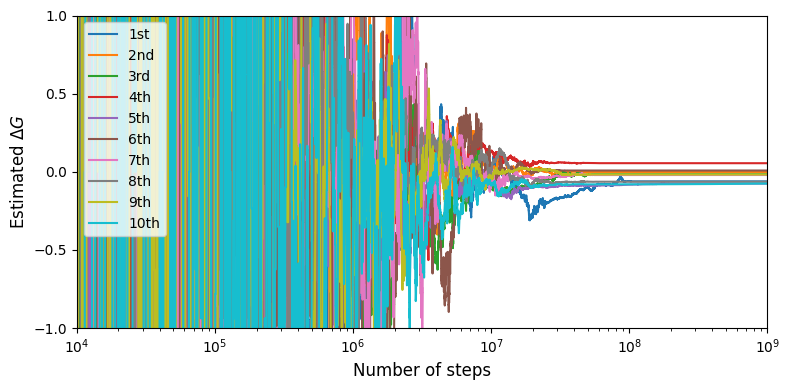

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


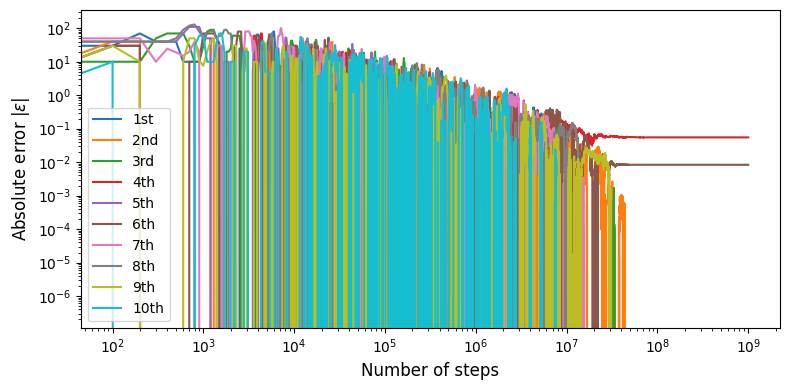

In [ ]:
nstep=int(1e9)
save_label='0.01constant_switchlto_c_equal0.01_no_histogramflat_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


In [78]:
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
# Calculate mean of each trace from step 1e8 to 1e9
for label in plot_labels:
    fe_data = np.load(f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.01constant_switchlto_c_equal0.01_no_histogramflat_{label}.npy')
    mean_of_each_trace_from_1e8 = np.mean(fe_data[1000000:]) 
    std_ofeach_trace_from1e8 = np.std(fe_data[1000000:])
    print(f'for {label}: mean_of_each_trace_from_1e8: {mean_of_each_trace_from_1e8}, std_ofeach_trace_from1e8: {std_ofeach_trace_from1e8}')

fe_mean_file = np.load(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_0.01constant_switchlto_c_equal0.01_no_histogramflat_10traces.npy')
print('fe_mean_file:', fe_mean_file)

# Get indices sorted by absolute value
sorted_indices = np.argsort(np.abs(fe_mean_file))+1
print(sorted_indices)

for 1st: mean_of_each_trace_from_1e8: -0.06106872044817269, std_ofeach_trace_from1e8: 7.359082925083832e-05
for 2nd: mean_of_each_trace_from_1e8: -0.0011766868668108147, std_ofeach_trace_from1e8: 3.0130234301743195e-07
for 3rd: mean_of_each_trace_from_1e8: -0.015664608950057987, std_ofeach_trace_from1e8: 1.4073172493569457e-06
for 4th: mean_of_each_trace_from_1e8: 0.05501493119565516, std_ofeach_trace_from1e8: 5.30983880551215e-06
for 5th: mean_of_each_trace_from_1e8: -0.07589069454259482, std_ofeach_trace_from1e8: 0.001216438491122063
for 6th: mean_of_each_trace_from_1e8: 0.008351283767724925, std_ofeach_trace_from1e8: 1.020629341064252e-06
for 7th: mean_of_each_trace_from_1e8: -0.020496762632951606, std_ofeach_trace_from1e8: 1.440711326361175e-06
for 8th: mean_of_each_trace_from_1e8: -0.06334673375206315, std_ofeach_trace_from1e8: 4.227035040394505e-06
for 9th: mean_of_each_trace_from_1e8: -0.01758161437533989, std_ofeach_trace_from1e8: 1.7383453706819549e-06
for 10th: mean_of_each_t

## C = 0.1

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
/Users/nguyendung/opt/anaconda3/envs/AIO_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


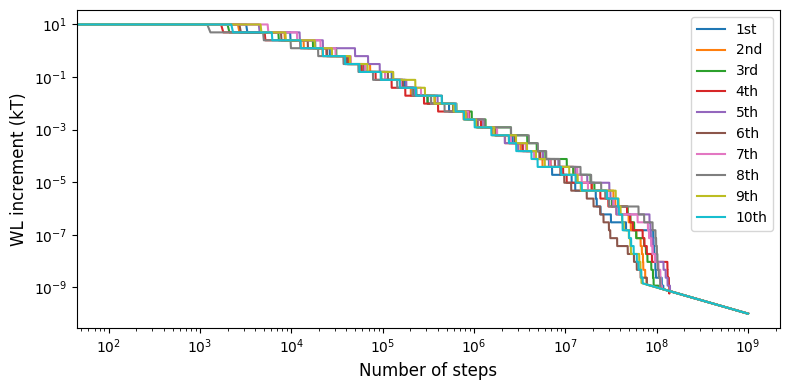

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


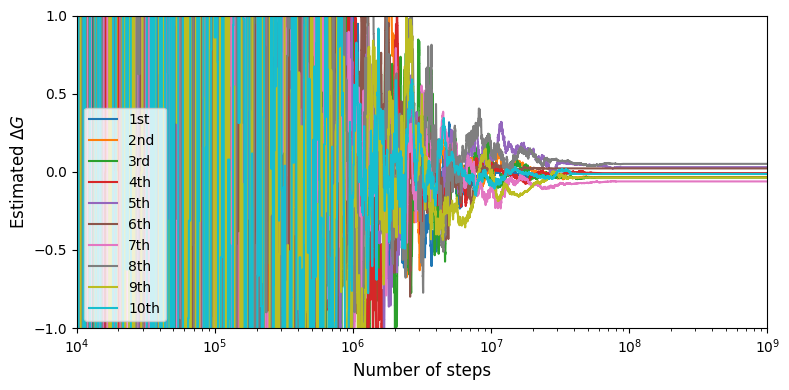

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


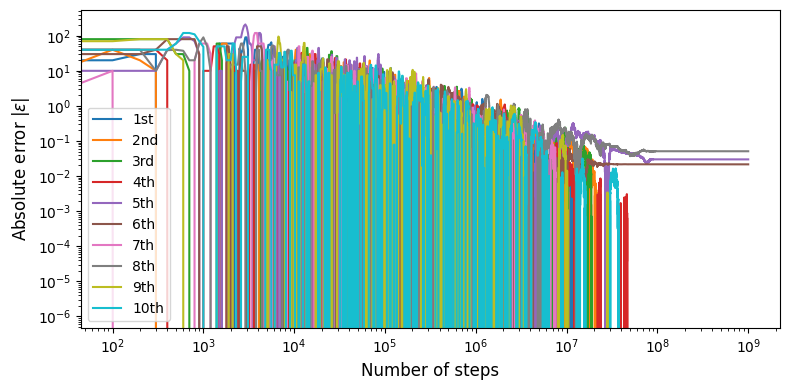

In [ ]:
nstep=int(1e9)
save_label='0.1constant_switchlto_c_equal0.1_no_histogramflat_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.1constant_switchlto_c_equal0.1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.1constant_switchlto_c_equal0.1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


In [76]:
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
# Calculate mean of each trace from step 1e8 to 1e9
for label in plot_labels:
    fe_data = np.load(f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.1constant_switchlto_c_equal0.1_no_histogramflat_{label}.npy')
    mean_of_each_trace_from_1e8 = np.mean(fe_data[1000000:]) 
    std_ofeach_trace_from1e8 = np.std(fe_data[1000000:])
    print(f'for {label}: mean_of_each_trace_from_1e8: {mean_of_each_trace_from_1e8}, std_ofeach_trace_from1e8: {std_ofeach_trace_from1e8}')

fe_mean_file = np.load(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_0.1constant_switchlto_c_equal0.1_no_histogramflat_10traces.npy')
print('fe_mean_file:', fe_mean_file)

# Get indices sorted by absolute value
sorted_indices = np.argsort(np.abs(fe_mean_file))+1
print(sorted_indices)

for 1st: mean_of_each_trace_from_1e8: -0.013334435997536965, std_ofeach_trace_from1e8: 1.2474139455203056e-05
for 2nd: mean_of_each_trace_from_1e8: -0.03296572013495921, std_ofeach_trace_from1e8: 2.6187723900076894e-05
for 3rd: mean_of_each_trace_from_1e8: -0.036791216931376755, std_ofeach_trace_from1e8: 2.2246803743306787e-05
for 4th: mean_of_each_trace_from_1e8: -0.008344747324127249, std_ofeach_trace_from1e8: 9.37498032831821e-06
for 5th: mean_of_each_trace_from_1e8: 0.02988759140852566, std_ofeach_trace_from1e8: 2.5661172321224226e-05
for 6th: mean_of_each_trace_from_1e8: 0.021574289761839907, std_ofeach_trace_from1e8: 1.1798463941979231e-05
for 7th: mean_of_each_trace_from_1e8: -0.06158167664582514, std_ofeach_trace_from1e8: 4.151681918403709e-05
for 8th: mean_of_each_trace_from_1e8: 0.05097481002153868, std_ofeach_trace_from1e8: 2.407250491102793e-05
for 9th: mean_of_each_trace_from_1e8: -0.03764339760046903, std_ofeach_trace_from1e8: 2.9565314972010668e-05
for 10th: mean_of_each

## c = 0

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


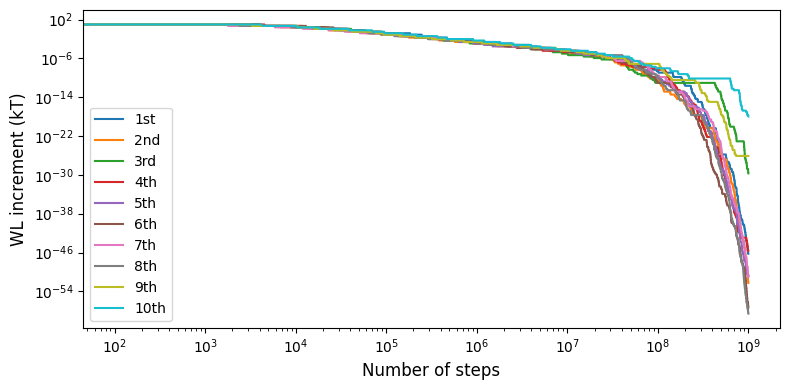

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


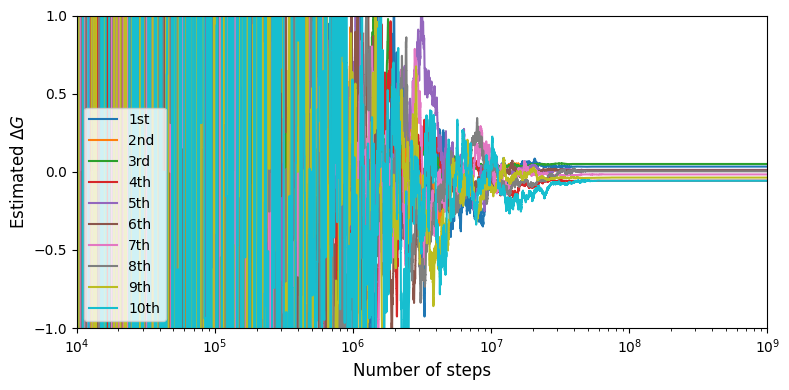

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


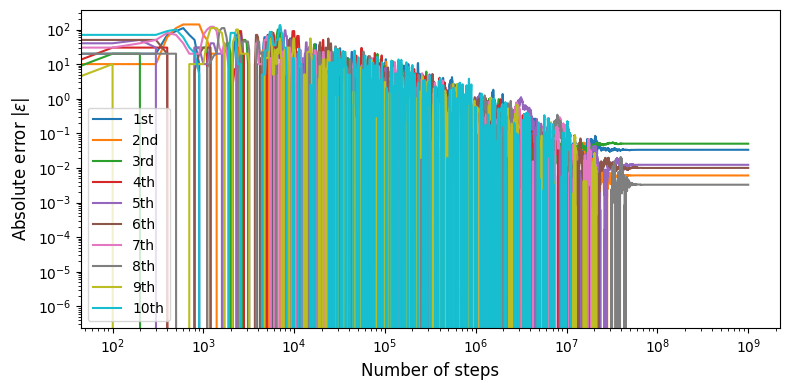

In [ ]:
nstep=int(1e9)
save_label = 'noconstant_noswitch_wL_only_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'] 

step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_noconstant_noswitch_wL_only.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_noconstant_noswitch_wL_only_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_noconstant_noswitch_wL_only_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple', 'red']  # Match the number of files

calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep, save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = True)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)



In [74]:
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
# Calculate mean of each trace from step 1e8 to 1e9
for label in plot_labels:
    fe_data = np.load(f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_noconstant_noswitch_wL_only_{label}.npy')
    mean_of_each_trace_from_1e8 = np.mean(fe_data[1000000:]) 
    std_ofeach_trace_from1e8 = np.std(fe_data[1000000:])
    print(f'for {label}: mean_of_each_trace_from_1e8: {mean_of_each_trace_from_1e8}, std_ofeach_trace_from1e8: {std_ofeach_trace_from1e8}')

fe_mean_file = np.load(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_noconstant_noswitch_wL_only_10traces.npy')
print('fe_mean_file:', fe_mean_file)

# Get indices sorted by absolute value
sorted_indices = np.argsort(np.abs(fe_mean_file))+1
print(sorted_indices)

for 1st: mean_of_each_trace_from_1e8: 0.03347694660146994, std_ofeach_trace_from1e8: 5.216243622190038e-06
for 2nd: mean_of_each_trace_from_1e8: 0.0060498473055094594, std_ofeach_trace_from1e8: 5.858612200672451e-09
for 3rd: mean_of_each_trace_from_1e8: 0.05013807134073496, std_ofeach_trace_from1e8: 4.376255030136507e-07
for 4th: mean_of_each_trace_from_1e8: -0.05671551072399062, std_ofeach_trace_from1e8: 5.198240051833121e-06
for 5th: mean_of_each_trace_from_1e8: 0.012301215493976937, std_ofeach_trace_from1e8: 2.096085214010186e-08
for 6th: mean_of_each_trace_from_1e8: 0.010017248667936823, std_ofeach_trace_from1e8: 1.0410351228979784e-08
for 7th: mean_of_each_trace_from_1e8: -0.016808108440687683, std_ofeach_trace_from1e8: 1.8955075378670465e-07
for 8th: mean_of_each_trace_from_1e8: 0.0032698224310736533, std_ofeach_trace_from1e8: 1.9064729126835615e-08
for 9th: mean_of_each_trace_from_1e8: -0.03690388982060398, std_ofeach_trace_from1e8: 1.3023027088256552e-05
for 10th: mean_of_each_

## C = 1

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
/Users/nguyendung/opt/anaconda3/envs/AIO_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


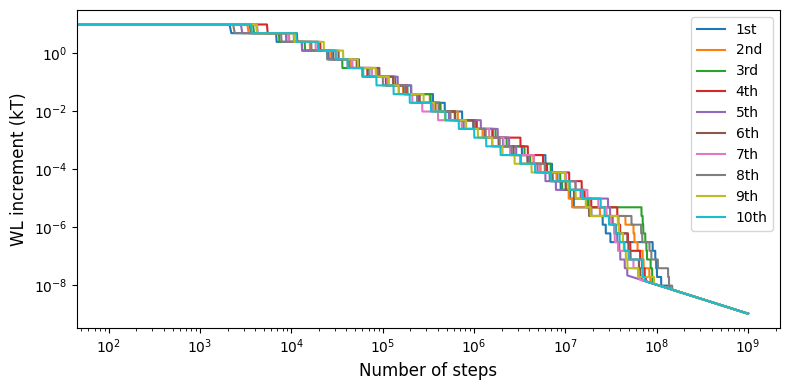

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


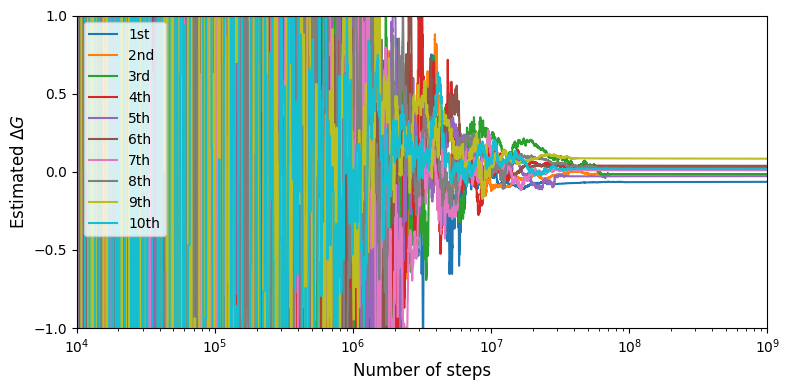

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


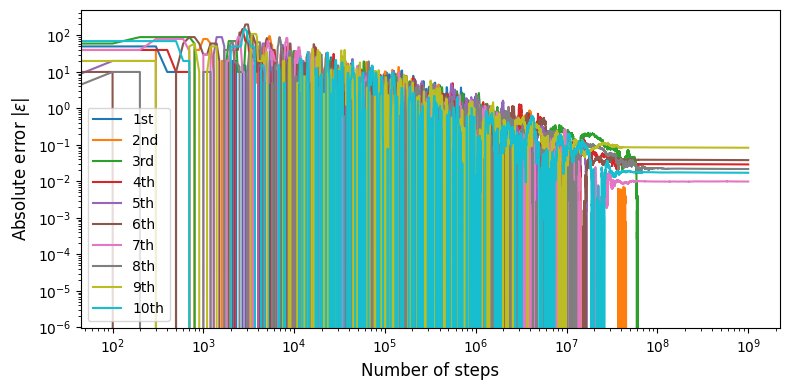

In [ ]:
nstep=int(1e9)
save_label='1constant_switchlto_c_equal1_no_histogramflat_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'] #7  3  2 10  8
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)

calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)

In [70]:
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
# Calculate mean of each trace from step 1e8 to 1e9
for label in plot_labels:
    fe_data = np.load(f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat_{label}.npy')
    mean_of_each_trace_from_1e8 = np.mean(fe_data[1000000:]) 
    std_ofeach_trace_from1e8 = np.std(fe_data[1000000:])
    print(f'for {label}: mean_of_each_trace_from_1e8: {mean_of_each_trace_from_1e8}, std_ofeach_trace_from1e8: {std_ofeach_trace_from1e8}')

fe_mean_file = np.load(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_1constant_switchlto_c_equal1_no_histogramflat_10traces.npy')
print('fe_mean_file:', fe_mean_file)

# Get indices sorted by absolute value
sorted_indices = np.argsort(np.abs(fe_mean_file))+1
print(sorted_indices)


for 1st: mean_of_each_trace_from_1e8: -0.06476025944858586, std_ofeach_trace_from1e8: 0.0004347298377077167
for 2nd: mean_of_each_trace_from_1e8: -0.014575755257874941, std_ofeach_trace_from1e8: 9.779687437565384e-05
for 3rd: mean_of_each_trace_from_1e8: -0.014107444633682922, std_ofeach_trace_from1e8: 5.3407651389866267e-05
for 4th: mean_of_each_trace_from_1e8: 0.029481562614781465, std_ofeach_trace_from1e8: 0.0001754813938164199
for 5th: mean_of_each_trace_from_1e8: -0.027984076251609848, std_ofeach_trace_from1e8: 0.00017894508062300506
for 6th: mean_of_each_trace_from_1e8: 0.0387124909678263, std_ofeach_trace_from1e8: 0.00023446935059783368
for 7th: mean_of_each_trace_from_1e8: 0.009981568938528388, std_ofeach_trace_from1e8: 4.7728645255805656e-05
for 8th: mean_of_each_trace_from_1e8: 0.022109794870989748, std_ofeach_trace_from1e8: 0.00020460417978065862
for 9th: mean_of_each_trace_from_1e8: 0.08441533524731352, std_ofeach_trace_from1e8: 0.00045167520854434896
for 10th: mean_of_each

## C =10

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


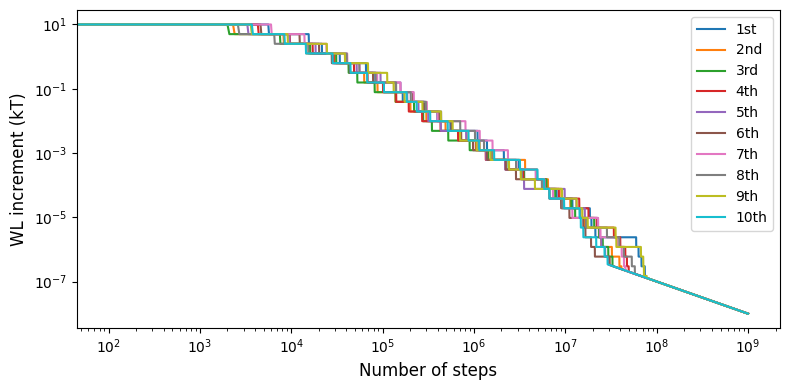

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


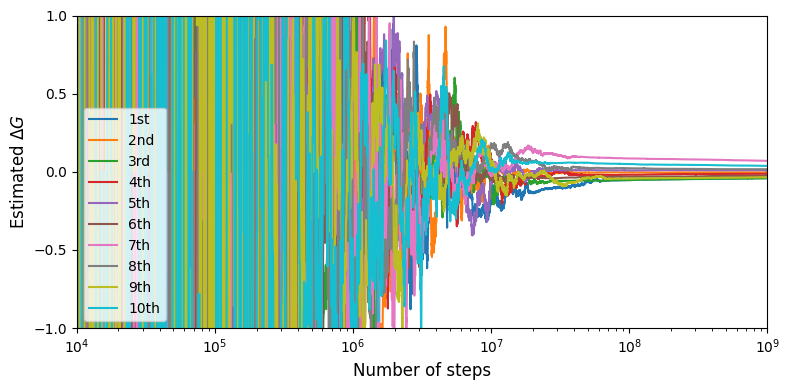

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


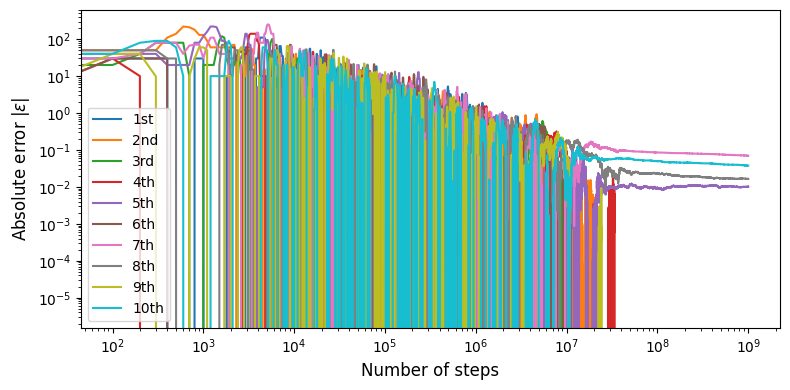

In [ ]:
nstep=int(1e9)
save_label='10constant_switchlto_c_equal10_no_histogramflat_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_10constant_switchlto_c_equal10_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_10constant_switchlto_c_equal10_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, step_traj, save_label, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


In [72]:

plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
# Calculate mean of each trace from step 1e8 to 1e9
for label in plot_labels:
    fe_data = np.load(f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_10constant_switchlto_c_equal10_no_histogramflat_{label}.npy')
    mean_of_each_trace_from_1e8 = np.mean(fe_data[1000000:]) 
    std_ofeach_trace_from1e8 = np.std(fe_data[1000000:])
    print(f'for {label}: mean_of_each_trace_from_1e8: {mean_of_each_trace_from_1e8}, std_ofeach_trace_from1e8: {std_ofeach_trace_from1e8}')

fe_mean_file = np.load(f'{proj_path}/trajectories/mean_free_energy_of_each_traces_from1e8_10constant_switchlto_c_equal10_no_histogramflat_10traces.npy')
print('fe_mean_file:', fe_mean_file)

# Get indices sorted by absolute value
sorted_indices = np.argsort(np.abs(fe_mean_file))+1
print(sorted_indices)

for 1st: mean_of_each_trace_from_1e8: -0.04427547209818801, std_ofeach_trace_from1e8: 0.0028168983883104614
for 2nd: mean_of_each_trace_from_1e8: -0.003729979858533548, std_ofeach_trace_from1e8: 0.00032736490986424777
for 3rd: mean_of_each_trace_from_1e8: -0.044365614422461556, std_ofeach_trace_from1e8: 0.00262437995508157
for 4th: mean_of_each_trace_from_1e8: -0.01421311280028326, std_ofeach_trace_from1e8: 0.0012660753828807885
for 5th: mean_of_each_trace_from_1e8: 0.0102501025194754, std_ofeach_trace_from1e8: 0.00040453213384146144
for 6th: mean_of_each_trace_from_1e8: -0.02729718073177468, std_ofeach_trace_from1e8: 0.0018932080002919726
for 7th: mean_of_each_trace_from_1e8: 0.07567003681195507, std_ofeach_trace_from1e8: 0.0040583052097442
for 8th: mean_of_each_trace_from_1e8: 0.017744309829654397, std_ofeach_trace_from1e8: 0.0014509660101855516
for 9th: mean_of_each_trace_from_1e8: -0.03769022148384357, std_ofeach_trace_from1e8: 0.0020984694356157314
for 10th: mean_of_each_trace_fro

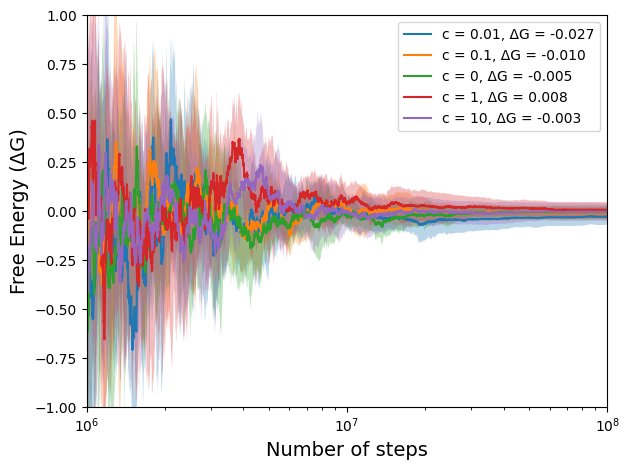

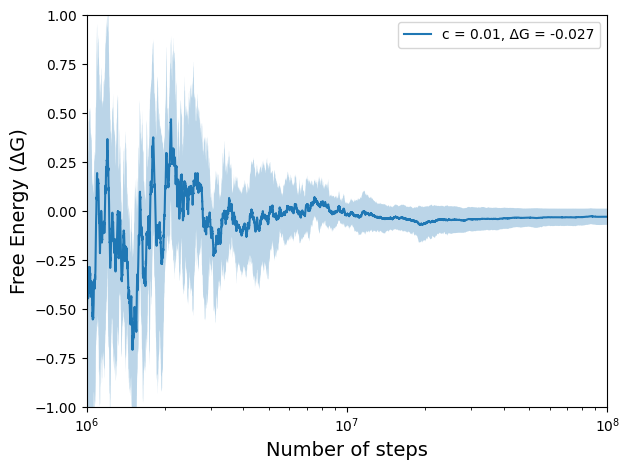

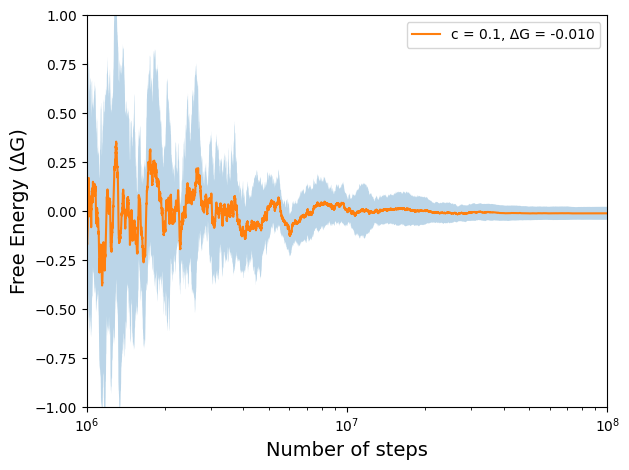

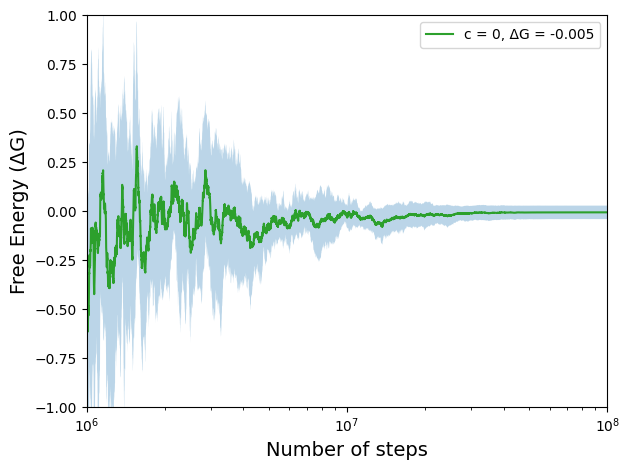

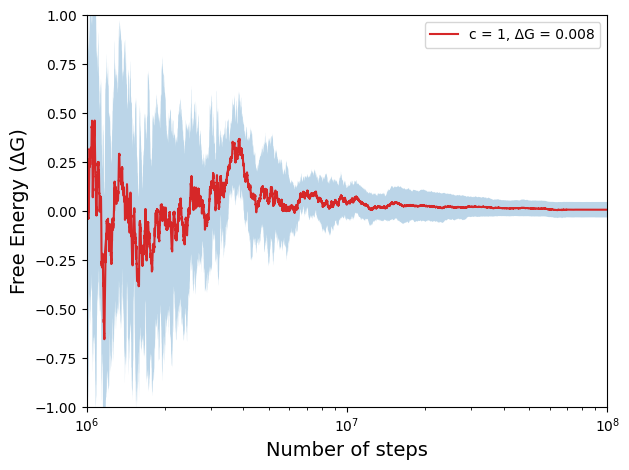

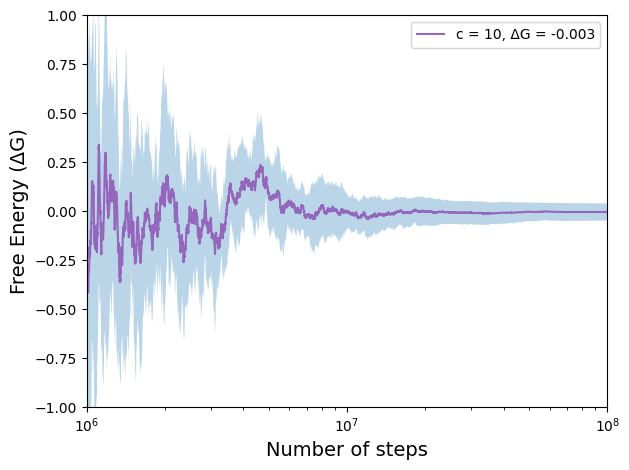

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1219721430.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1219721430.py:236: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/std_free_energy_vs_steps_{save_label}.png', dpi=300, bbox_inches='tight')


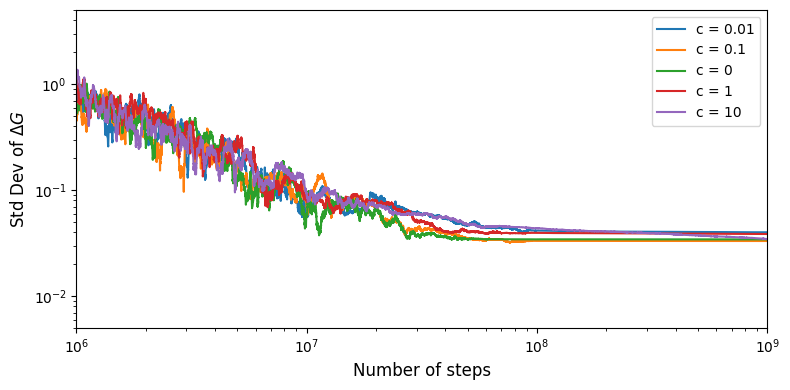

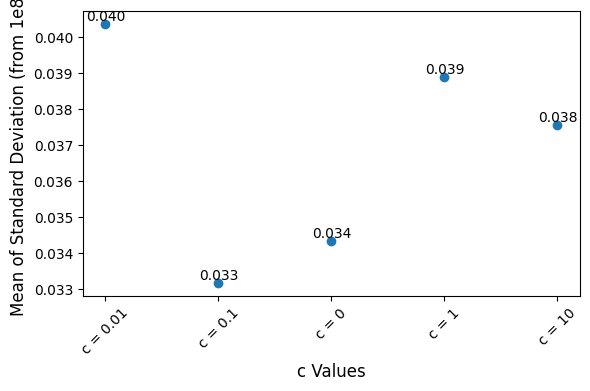

In [ ]:
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy')
file_labels = ['0.01constant_switchlto_c_equal0.01_no_histogramflat_10traces','0.1constant_switchlto_c_equal0.1_no_histogramflat_10traces','noconstant_noswitch_wL_only_10traces','1constant_switchlto_c_equal1_no_histogramflat_10traces','10constant_switchlto_c_equal10_no_histogramflat_10traces']
color_codes= ['#1f77b4', '#ff7f0e','#2ca02c','#d62728', '#9467bd']
a = ['c = 0.01','c = 0.1','c = 0','c = 1','c = 10']#,'c = 100']
# Load mean free energy values from 1e8 to 1e9
mean_fe = [np.load(f'{proj_path}/trajectories/mean_free_energy_of_all_1e8_to_1e9_{label}.npy') for label in file_labels]

fe_mean_files = [f'{proj_path}/trajectories/mean_free_energy_of_multiple_traces_0axis_{suffix}.npy' for suffix in file_labels]
fe_std_files = [f'{proj_path}/trajectories/std_free_energy_of_multiple_traces_0axis_{suffix}.npy' for suffix in file_labels]

# Create plot labels using mean_fe values
plot_labels = [f'{j}, ΔG = {mean_fe[i]:.3f}' for i,j in zip(range(len(file_labels)),a)]
plot_free_energy_std_or_rmse(fe_mean_files, fe_std_files, step_traj, plot_labels, save_label='comparision',colors=color_codes)

# Plot first three datasets in separate plots
for i in range(5):
    plot_labels = [f'{a[i]}, ΔG = {mean_fe[i]:.3f}' ]
    color = [color_codes[i]]
    plot_free_energy_std_or_rmse([fe_mean_files[i]], [fe_std_files[i]], step_traj, plot_labels, file_labels[i],color)

# Create plot of free energy standard deviation vs steps
plot_labels = [f'{a[i]}' for i in range(len(a))]
plot_std_or_rmse_free_energy_vs_steps(step_traj, fe_std_files,plot_labels, save_label= 'fe_sdt_vs_steps', show_legend = True)

# create plot of free energy standard deviation vs variety of c constant
plot_mean_of_stds_vs_c_constants(fe_std_files, a)

## C = 100

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


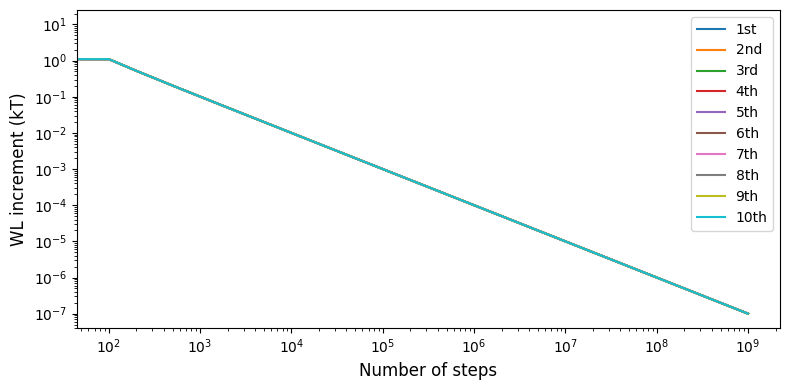

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/free_energy_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')


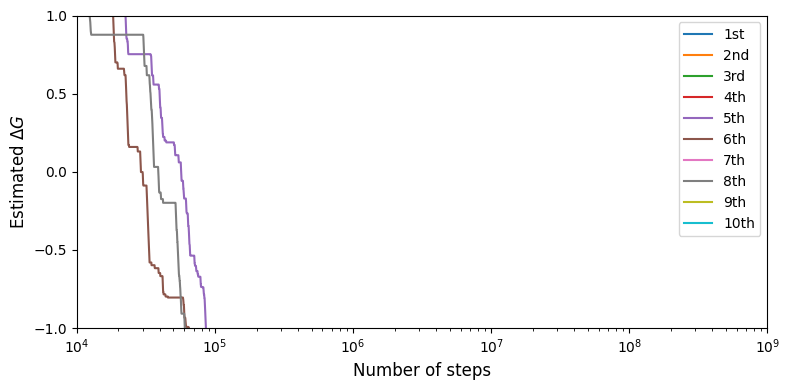

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/2858464479.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


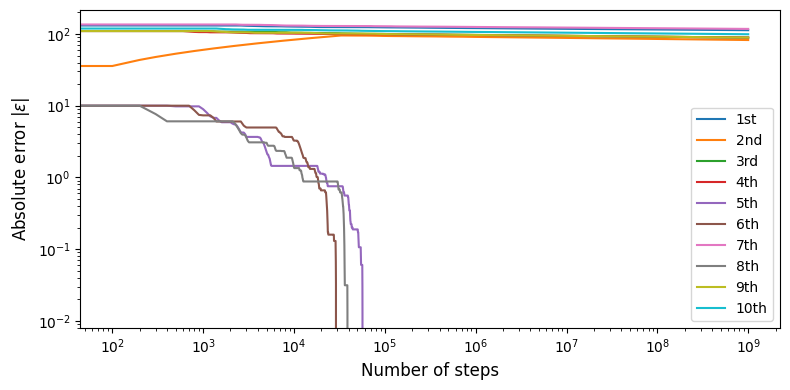

In [ ]:
nstep=int(1e9)
save_label='100constant_switchlto_c_equal100_no_histogramflat_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_1constant_switchlto_c_equal1_no_histogramflat_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_100constant_switchlto_c_equal100_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_100constant_switchlto_c_equal100_no_histogramflat_{suffix}.npy'
    for suffix in plot_labels]

colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep,save_label,plot_labels,show_legend = True)
calculate_rmse(free_energy_files,save_label)
rmse = np.load(f'{proj_path}/trajectories/rmse_free_energy_of_multiple_traces_0axis_{save_label}.npy')
rmse_of_multiple_traces(rmse, colors, step_traj, save_label, plot_labels, show_legend=False, t_over_mixing_time=False)
average_abs_error_of_multiple_traces(free_energy_files, step_traj, save_label, show_legend = False,t_over_mixing_time=False)


## Algorithm 2: changing number of steps to switch from wl to 1/t 

## step limit = 1e6

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_18428/439176293.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_18428/439176293.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_1ylim_{save_label}.png', dpi=300, bbox_inches='tight')
/Users/nguyendung/opt/anaconda3/envs/AIO_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


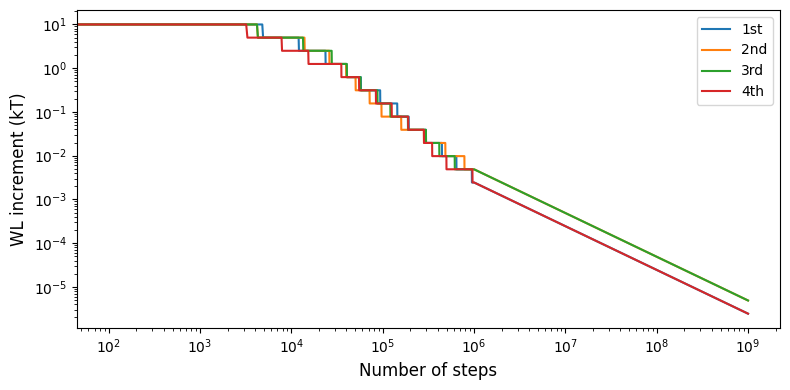

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_18428/439176293.py:149: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_18428/439176293.py:150: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces_nonzero_{save_label}.png', dpi=300, bbox_inches='tight')


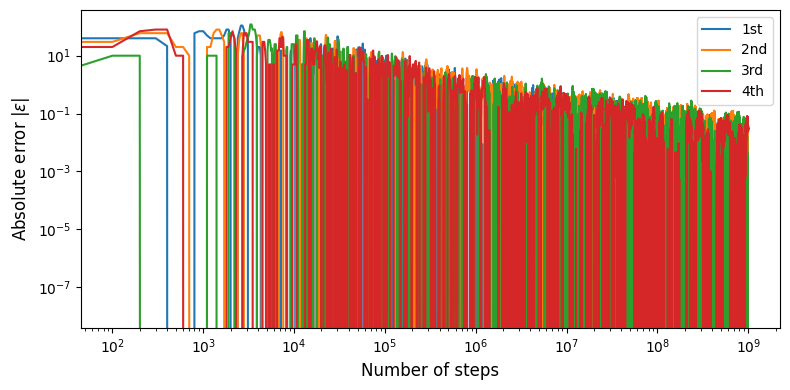

In [ ]:
nstep=int(1e9)
save_label='c_switchlto_c_no_histogramflat_nsteps_limit_e6_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
 
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_2nd.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_3rd.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_4th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_5th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-1000000000step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_6th.npy',

]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_2nd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_3rd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_4th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-1000000000step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_5th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-1000000000step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_6th.npy',
    ]

#colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = False)#free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = True)
abs_error_of_multiple_traces_nonzero(free_energy_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = False)

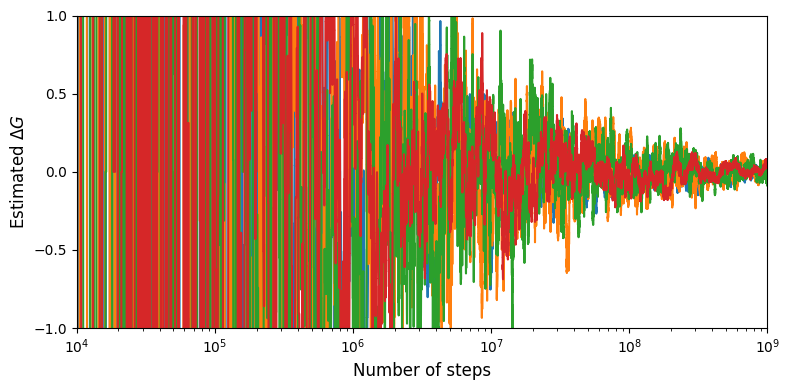

In [22]:
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep, save_label, plot_labels, show_legend = False)

In [ ]:
nstep=int(1e9)
save_label='c_switchlto_c_no_histogramflat_nsteps_limit_5e7_10traces'
plot_labels = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
 
step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy')
wl_files = [
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_1.86264518648386c_switchlto_c_no_histogramflat_nsteps_limit_5e7_1st.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.93132259324193c_switchlto_c_no_histogramflat_nsteps_limit_5e7_2nd.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_3rd.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_4th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_5th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_6th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_7th.npy', 
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_8th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_9th.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_1.86264518648386c_switchlto_c_no_histogramflat_nsteps_limit_5e7_10th.npy',
]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1.86264518648386c_switchlto_c_no_histogramflat_nsteps_limit_5e7_1st.npy',
    f'{proj_path}/trajectories/wl_increment_traj_0-{nstep}step_0.93132259324193c_switchlto_c_no_histogramflat_nsteps_limit_5e7_2nd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_3rd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_4th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_5th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_6th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_7th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_8th.npy',    
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_9th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1.86264518648386c_switchlto_c_no_histogramflat_nsteps_limit_5e7_10th.npy'
    ]

#colors = ['darkblue', 'darkgreen', 'darkorange','purple']  # Match the number of files
calculate_free_energy_sdt(free_energy_files,save_label)
WL_increment_of_multiple_traces(wl_files, colors, step_traj,nstep, save_label,plot_labels,show_legend = False)
free_energy_of_multiple_traces(free_energy_files, colors, step_traj,nstep, save_label, plot_labels, show_legend = False)
abs_error_of_multiple_traces_nonzero(free_energy_files, colors, step_traj,nstep, save_label,plot_labels, show_legend = False)


Points with slope ≈ 1/2 for Trace 1 (step, wl_increment):
  Step: 36700.00, WL Increment: 0.775
  Step: 47400.00, WL Increment: 0.535
  Step: 59600.00, WL Increment: 0.388
  Step: 59700.00, WL Increment: 0.389
  Step: 80600.00, WL Increment: 0.245

Points with slope ≈ 1/2 for Trace 2 (step, wl_increment):
  Step: 32500.00, WL Increment: 0.434
  Step: 40100.00, WL Increment: 0.389
  Step: 50400.00, WL Increment: 0.299
  Step: 64600.00, WL Increment: 0.193
  Step: 64700.00, WL Increment: 0.193

Points with slope ≈ 1/2 for Trace 3 (step, wl_increment):
  Step: 29300.00, WL Increment: 1.189
  Step: 37500.00, WL Increment: 1.030
  Step: 37600.00, WL Increment: 1.032
  Step: 66600.00, WL Increment: 0.366
  Step: 66700.00, WL Increment: 0.366

Points with slope ≈ 1/2 for Trace 4 (step, wl_increment):
  Step: 30500.00, WL Increment: 0.946
  Step: 38600.00, WL Increment: 0.804
  Step: 62800.00, WL Increment: 0.380
  Step: 62900.00, WL Increment: 0.381
  Step: 83900.00, WL Increment: 0.256

Poi

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/3974035517.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


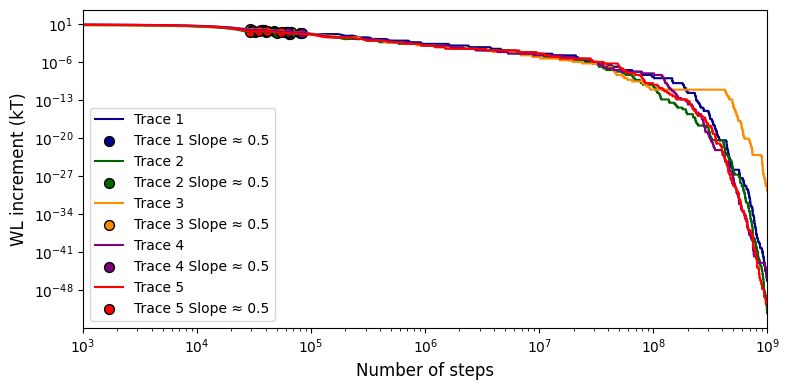

In [115]:
def wl_increment_of_multiple_traces_smoothed(nstep, c_1_over_t, init_step=0, smooth_window=51):
    """
    Plot smoothed Wang-Landau increment trajectories, mark points where slope is 1/2 in log-log scale.

    Parameters:
    -----------
    nstep : int
        Number of steps in the simulation.
    c_1_over_t : str
        String indicating the 1/t constant setting (e.g., 'no').
    proj_path : str
        Path to the project directory containing trajectory files.
    init_step : int, optional
        Initial step number (default: 0).
    smooth_window : int, optional
        Window size for Savitzky-Golay smoothing (default: 51, must be odd).

    Returns:
    --------
    None
    """
    # Ensure smooth_window is odd
    if smooth_window % 2 == 0:
        smooth_window += 1
        print(f"Warning: smooth_window must be odd. Adjusted to {smooth_window}.")

    # Load the step trajectory
    step_traj = np.load(f"{proj_path}/trajectories/step_traj_{init_step}-{nstep}step_noconstant_noswitch_wL_only.npy")

    # Load the five WL increment trajectories
    suffixes = ["", "_2nd", "_3rd", "_4th", "_5th"]
    colors = ["darkblue", "darkgreen", "darkorange", "purple", "red"]
    labels = [f"Trace {i+1}" for i in range(5)]
    wl_increment_trajs = []

    # Create the plot
    plt.figure(figsize=(8, 4))

    for suffix, color, label in zip(suffixes, colors, labels):
        # Load trajectory
        wl_increment_traj = np.load(
            f"{proj_path}/trajectories/wl_increment_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only{suffix}.npy"
        )

        # Check length consistency
        if len(wl_increment_traj) != len(step_traj):
            raise ValueError(f"Trajectory {label} has length {len(wl_increment_traj)}, but step_traj has length {len(step_traj)}")

        # Replace zeros with neighbor averages to avoid log(0) issues
        valid_indices = wl_increment_traj != 0
        if not valid_indices.all():
            for idx in np.where(~valid_indices)[0]:
                start = max(0, idx - 3)
                end = min(len(wl_increment_traj), idx + 4)
                neighbors = wl_increment_traj[start:end]
                neighbors = neighbors[neighbors != 0]
                if len(neighbors) > 0:
                    wl_increment_traj[idx] = np.mean(neighbors)
                else:
                    wl_increment_traj[idx] = 1e-10  # Small positive value as fallback

        # Smooth the trajectory using Savitzky-Golay filter
        if len(wl_increment_traj) >= smooth_window:
            wl_increment_smoothed = savgol_filter(wl_increment_traj, window_length=smooth_window, polyorder=2)
        else:
            wl_increment_smoothed = wl_increment_traj
            print(f"Warning: Trajectory {label} too short for smoothing (length {len(wl_increment_traj)} < {smooth_window}). Using original data.")

        wl_increment_trajs.append(wl_increment_smoothed)

        # Plot smoothed trajectory
        plt.plot(step_traj, wl_increment_smoothed, color=color, label=label)

        # Compute slope in log-log scale (only for positive values)
        valid_mask = (wl_increment_smoothed > 0) & (step_traj > 0)
        log_steps = np.log10(step_traj[valid_mask])
        log_wl_increment = np.log10(wl_increment_smoothed[valid_mask])
        slope = np.gradient(log_wl_increment, log_steps)

        # Find points where slope is approximately 1/2
        slope_tolerance = 0.05
        slope_indices = np.where((np.abs(slope - 0.5) < slope_tolerance) & (step_traj[valid_mask] > 1e3))[0]
        
        # Print and mark slope points
        print(f"\nPoints with slope ≈ 1/2 for {label} (step, wl_increment):")
        if len(slope_indices) > 0:
            for i, idx in enumerate(slope_indices[:5]):  # Limit to first 5 points
                x = step_traj[valid_mask][idx]
                y = wl_increment_smoothed[valid_mask][idx]
                print(f"  Step: {x:.2f}, WL Increment: {y:.3f}")
                # Mark the point on the plot
                plt.scatter(x, y, color=color, marker='o', s=50, edgecolors='black', label=f"{label} Slope ≈ 0.5" if i == 0 else None)
        else:
            print("  No points found with slope ≈ 1/2.")

    # Plot settings
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e3, nstep)
    plt.xlabel("Number of steps", fontsize=12)
    plt.ylabel("WL increment (kT)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"{proj_path}/plots/wl_increment_of_multiple_traces_smoothed_{nstep}steps.png", dpi=300, bbox_inches="tight")
    plt.show()

wl_increment_of_multiple_traces_smoothed(nstep=int(1e9), c_1_over_t='no', init_step=0, smooth_window=551)


Points with slope ≈ 1/2 for Trace 1 (step, wl_increment):
  Step: 382200.00, WL Increment: 0.112
  Step: 382300.00, WL Increment: 0.112
  Step: 382400.00, WL Increment: 0.112
  Step: 382500.00, WL Increment: 0.112
  Step: 382600.00, WL Increment: 0.112


/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/435050685.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/435050685.py:97: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{proj_path}/plots/wl_increment_of_multiple_traces_smoothed_{nstep}steps.png", dpi=300, bbox_inches="tight")


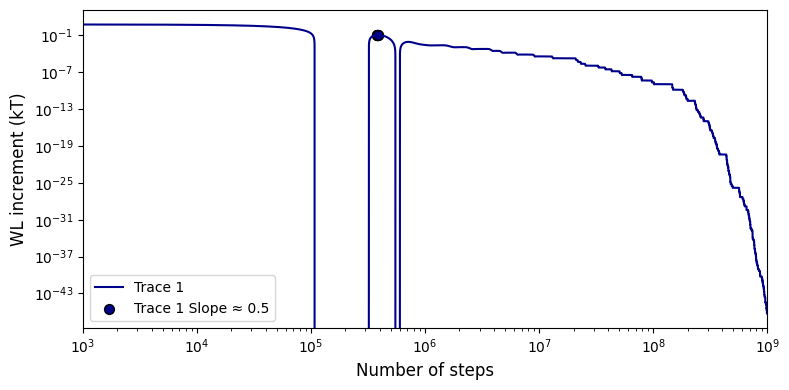

In [120]:
from scipy.signal import savgol_filter

def wl_increment_of_multiple_traces_smoothed(nstep, c_1_over_t, init_step=0, smooth_window=51, smooth_iterations=10):
    """
    Plot smoothed Wang-Landau increment trajectories (smoothed 10 times) and mark points where slope is 1/2 in log-log scale.

    Parameters:
    -----------
    nstep : int
        Number of steps in the simulation.
    c_1_over_t : str
        String indicating the 1/t constant setting (e.g., 'no').
    proj_path : str
        Path to the project directory containing trajectory files.
    init_step : int, optional
        Initial step number (default: 0).
    smooth_window : int, optional
        Window size for Savitzky-Golay smoothing (default: 51, must be odd).
    smooth_iterations : int, optional
        Number of smoothing iterations (default: 10).

    Returns:
    --------
    None
    """
    # Ensure smooth_window is odd
    if smooth_window % 2 == 0:
        smooth_window += 1
        print(f"Warning: smooth_window must be odd. Adjusted to {smooth_window}.")

    # Load the step trajectory
    step_traj = np.load(f"{proj_path}/trajectories/step_traj_{init_step}-{nstep}step_noconstant_noswitch_wL_only.npy")

    # Load the five WL increment trajectories
    suffixes = [""]#, "_2nd", "_3rd", "_4th", "_5th"]
    colors = ["darkblue"]#, "darkgreen", "darkorange", "purple", "red"]
    labels = [f"Trace {i+1}" for i in range(1)]
    wl_increment_trajs = []

    # Create the plot
    plt.figure(figsize=(8, 4))

    for suffix, color, label in zip(suffixes, colors, labels):
        # Load trajectory
        wl_increment_traj = np.load(
            f"{proj_path}/trajectories/wl_increment_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only{suffix}.npy"
        )

        # Check length consistency
        if len(wl_increment_traj) != len(step_traj):
            raise ValueError(f"Trajectory {label} has length {len(wl_increment_traj)}, but step_traj has length {len(step_traj)}")

        # Smooth the trajectory multiple times using Savitzky-Golay filter
        if len(wl_increment_traj) >= smooth_window:
            wl_increment_smoothed = wl_increment_traj
            for _ in range(smooth_iterations):
                wl_increment_smoothed = savgol_filter(wl_increment_smoothed, window_length=smooth_window, polyorder=2)
        else:
            wl_increment_smoothed = wl_increment_traj
            print(f"Warning: Trajectory {label} too short for smoothing (length {len(wl_increment_traj)} < {smooth_window}). Using original data.")

        wl_increment_trajs.append(wl_increment_smoothed)

        # Plot smoothed trajectory
        plt.plot(step_traj, wl_increment_smoothed, color=color, label=label)

        # Compute slope in log-log scale (only for positive values)
        valid_mask = (wl_increment_smoothed > 0) & (step_traj > 0)
        log_steps = np.log10(step_traj[valid_mask])
        log_wl_increment = np.log10(wl_increment_smoothed[valid_mask])
        slope = np.gradient(log_wl_increment, log_steps)

        # Find points where slope is approximately 1/2
        slope_tolerance = 0.05
        slope_indices = np.where((np.abs(slope - 0.5) < slope_tolerance) & (step_traj[valid_mask] > 1e3))[0]
        
        # Print and mark slope points
        print(f"\nPoints with slope ≈ 1/2 for {label} (step, wl_increment):")
        if len(slope_indices) > 0:
            for i, idx in enumerate(slope_indices[:5]):  # Limit to first 5 points
                x = step_traj[valid_mask][idx]
                y = wl_increment_smoothed[valid_mask][idx]
                print(f"  Step: {x:.2f}, WL Increment: {y:.3f}")
                # Mark the point on the plot
                plt.scatter(x, y, color=color, marker='o', s=50, edgecolors='black', label=f"{label} Slope ≈ 0.5" if i == 0 else None)
        else:
            print("  No points found with slope ≈ 1/2.")

    # Plot settings
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e3, nstep)
    plt.xlabel("Number of steps", fontsize=12)
    plt.ylabel("WL increment (kT)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{proj_path}/plots/wl_increment_of_multiple_traces_smoothed_{nstep}steps.png", dpi=300, bbox_inches="tight")
    plt.show()

wl_increment_of_multiple_traces_smoothed(nstep=int(1e9), c_1_over_t='no', init_step=0, smooth_window=501, smooth_iterations=10000)

In [ ]:
def WL_increament_of_multiple_traces_smooth(nstep, c_1_over_t, init_step=0):
    """
    Plot smoothed Wang-Landau increment trajectories and find points where slope is 1/2.

    Parameters:
    -----------
    nstep : int
        Number of steps in the simulation.
    c_1_over_t : str
        String indicating the 1/t constant setting (e.g., 'no').
    proj_path : str
        Path to the project directory containing trajectory files.
    init_step : int, optional
        Initial step number (default: 0).

    Returns:
    --------
    None
    """
    # Load the step trajectory
    step_traj = np.load(f"{proj_path}/trajectories/step_traj_0-{nstep}step_noconstant_noswitch_wL_only.npy")

    # Load the five WL increment trajectories
    suffixes = ["", "_2nd", "_3rd", "_4th", "_5th"]
    colors = ["darkblue", "darkgreen", "darkorange", "purple", "red"]
    labels = ["WL_1st", "WL_2nd", "WL_3rd", "WL_4th", "WL_5th"]
    wl_increment_trajs = [
        np.load(f"{proj_path}/trajectories/wl_increment_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only{suffix}.npy")
        for suffix in suffixes
    ]

    # Check that step_traj and wl_increment_trajs have the same length
    expected_length = len(step_traj)
    for i, traj in enumerate(wl_increment_trajs):
        if len(traj) != expected_length:
            raise ValueError(f"Trajectory {labels[i]} has length {len(traj)}, but step_traj has length {expected_length}")

    # Smoothing parameters
    window_size = 10000  # Adjust for desired smoothness
    window = np.ones(window_size) / window_size  # Moving average kernel

    # Create the plot
    plt.figure(figsize=(8, 4))

    # Process each trajectory
    for traj, label, color in zip(wl_increment_trajs, labels, colors):
        # Smooth the trajectory
        smoothed_traj = np.convolve(traj, window, mode="valid")
        # Adjust step_traj to match smoothed_traj length
        trim = window_size - 1  # Number of elements lost in convolution
        start_idx = trim // 2
        end_idx = len(step_traj) - (trim - start_idx)
        smoothed_step_traj = step_traj[start_idx:end_idx]

        # Ensure shapes match
        if len(smoothed_step_traj) != len(smoothed_traj):
            min_len = min(len(smoothed_step_traj), len(smoothed_traj))
            smoothed_step_traj = smoothed_step_traj[:min_len]
            smoothed_traj = smoothed_traj[:min_len]

        # Plot original and smoothed trajectories
        plt.plot(step_traj, traj, label=label, color=color, alpha=0.3)  # Original (faded)
        plt.plot(smoothed_step_traj, smoothed_traj, label=f"{label} (Smoothed)", color=color)

        # Compute slope in log-log space
        log_step = np.log10(smoothed_step_traj)
        log_traj = np.log10(smoothed_traj)
        slope = np.gradient(log_traj, log_step)  # Numerical derivative

        # Find points where slope is approximately 1/2
        slope_target = 0.5
        tolerance = 0.01
        slope_indices = np.where(np.abs(slope - slope_target) < tolerance)[0]
        
        if len(slope_indices) > 0:
            print(f"\n{label} - Points where slope ≈ {slope_target}:")
            for idx in slope_indices[:5]:  # Limit to first 5 for brevity
                x = smoothed_step_traj[idx]
                y = smoothed_traj[idx]
                print(f"  (x={x:.1f}, y={y:.3f})")
        else:
            print(f"\n{label} - No points found where slope ≈ {slope_target}")

    # Plot settings
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Number of steps", fontsize=12)
    plt.ylabel("WL increment (kT)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"{proj_path}/plots/wl_increment_of_multiple_traces_{nstep}steps_smoothed.png", dpi=300, bbox_inches="tight")
    plt.show()
WL_increament_of_multiple_traces(nstep=int(1e9), c_1_over_t='no', init_step=0)


# showing the saturation error could be solved in toy model

<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/1013188732.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Absolute error $|\epsilon|$',fontsize=12)


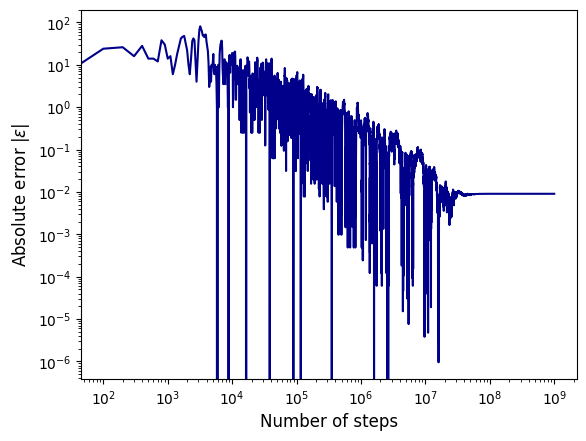

In [62]:
def average_absolute_error(nstep, c_1_over_t, label="WL", init_step=0):
    """
    Plot the average free energy trajectory from multiple Wang-Landau runs and compute its statistics.
    """

    # Load the step trajectory
    step_traj = np.load(f"{proj_path}/trajectories/step_traj_{init_step}-{nstep}step_noconstant_noswitch_wL_only.npy")

    # Load the five free energy trajectories
    suffixes = ["", "_2nd", "_3rd", "_4th", "_5th"]
    free_energy_trajs = [
        np.load(f"{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only{suffix}.npy")
        for suffix in suffixes
    ]

    # Compute the average free energy across the five trajectories (per step)
    avg_free_energy = np.mean(free_energy_trajs, axis=0)

    # Compute the standard deviation across the five trajectories (per step)
    std_free_energy = np.std(free_energy_trajs, axis=0, ddof=1)

    # plot absolute error
    plt.plot(step_traj, np.abs(avg_free_energy), label='WL', color='darkblue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Absolute error $|\epsilon|$',fontsize=12)
    
    plt.savefig(f'{proj_path}/plots/average_absolute_error.png', dpi=300, bbox_inches='tight')
    plt.show()

average_absolute_error(nstep=int(1e9), c_1_over_t='no',label="WL_only", init_step=0)

<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/4214318556.py:17: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Absolute error $|\epsilon|$',fontsize=12)


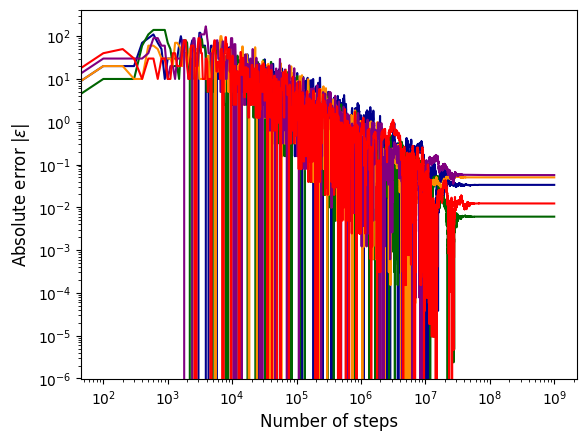

In [ ]:
def absolute_error_of_multiple_traces(nstep, c_1_over_t, init_step=0):
    step_traj = np.load(f"{proj_path}/trajectories/step_traj_{init_step}-{nstep}step_noconstant_noswitch_wL_only.npy")
    free_energy_traj_1st = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only.npy')
    free_energy_traj_2nd = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_2nd.npy') 
    free_energy_traj_3rd = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_3rd.npy')
    free_energy_traj_4th = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_4th.npy')
    free_energy_traj_5th = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_5th.npy')

    plt.plot(step_traj, np.abs(free_energy_traj_1st), color='darkblue')
    plt.plot(step_traj, np.abs(free_energy_traj_2nd), color='darkgreen')
    plt.plot(step_traj, np.abs(free_energy_traj_3rd), color='darkorange')
    plt.plot(step_traj, np.abs(free_energy_traj_4th), color='purple')
    plt.plot(step_traj, np.abs(free_energy_traj_5th), color='red')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Absolute error $|\epsilon|$',fontsize=12)
    plt.savefig(f'{proj_path}/plots/absolute_error_of_multiple_traces.png', dpi=300, bbox_inches='tight')
    plt.show()

absolute_error_of_traces(nstep=int(1e9), c_1_over_t='no', init_step=0)

# Comparision between with and without 1/t sampling

/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_7826/2391861522.py:154: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{proj_path}/plots/compared_with_without_1overt.png', dpi=300, bbox_inches='tight')
/Users/nguyendung/opt/anaconda3/envs/AIO_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


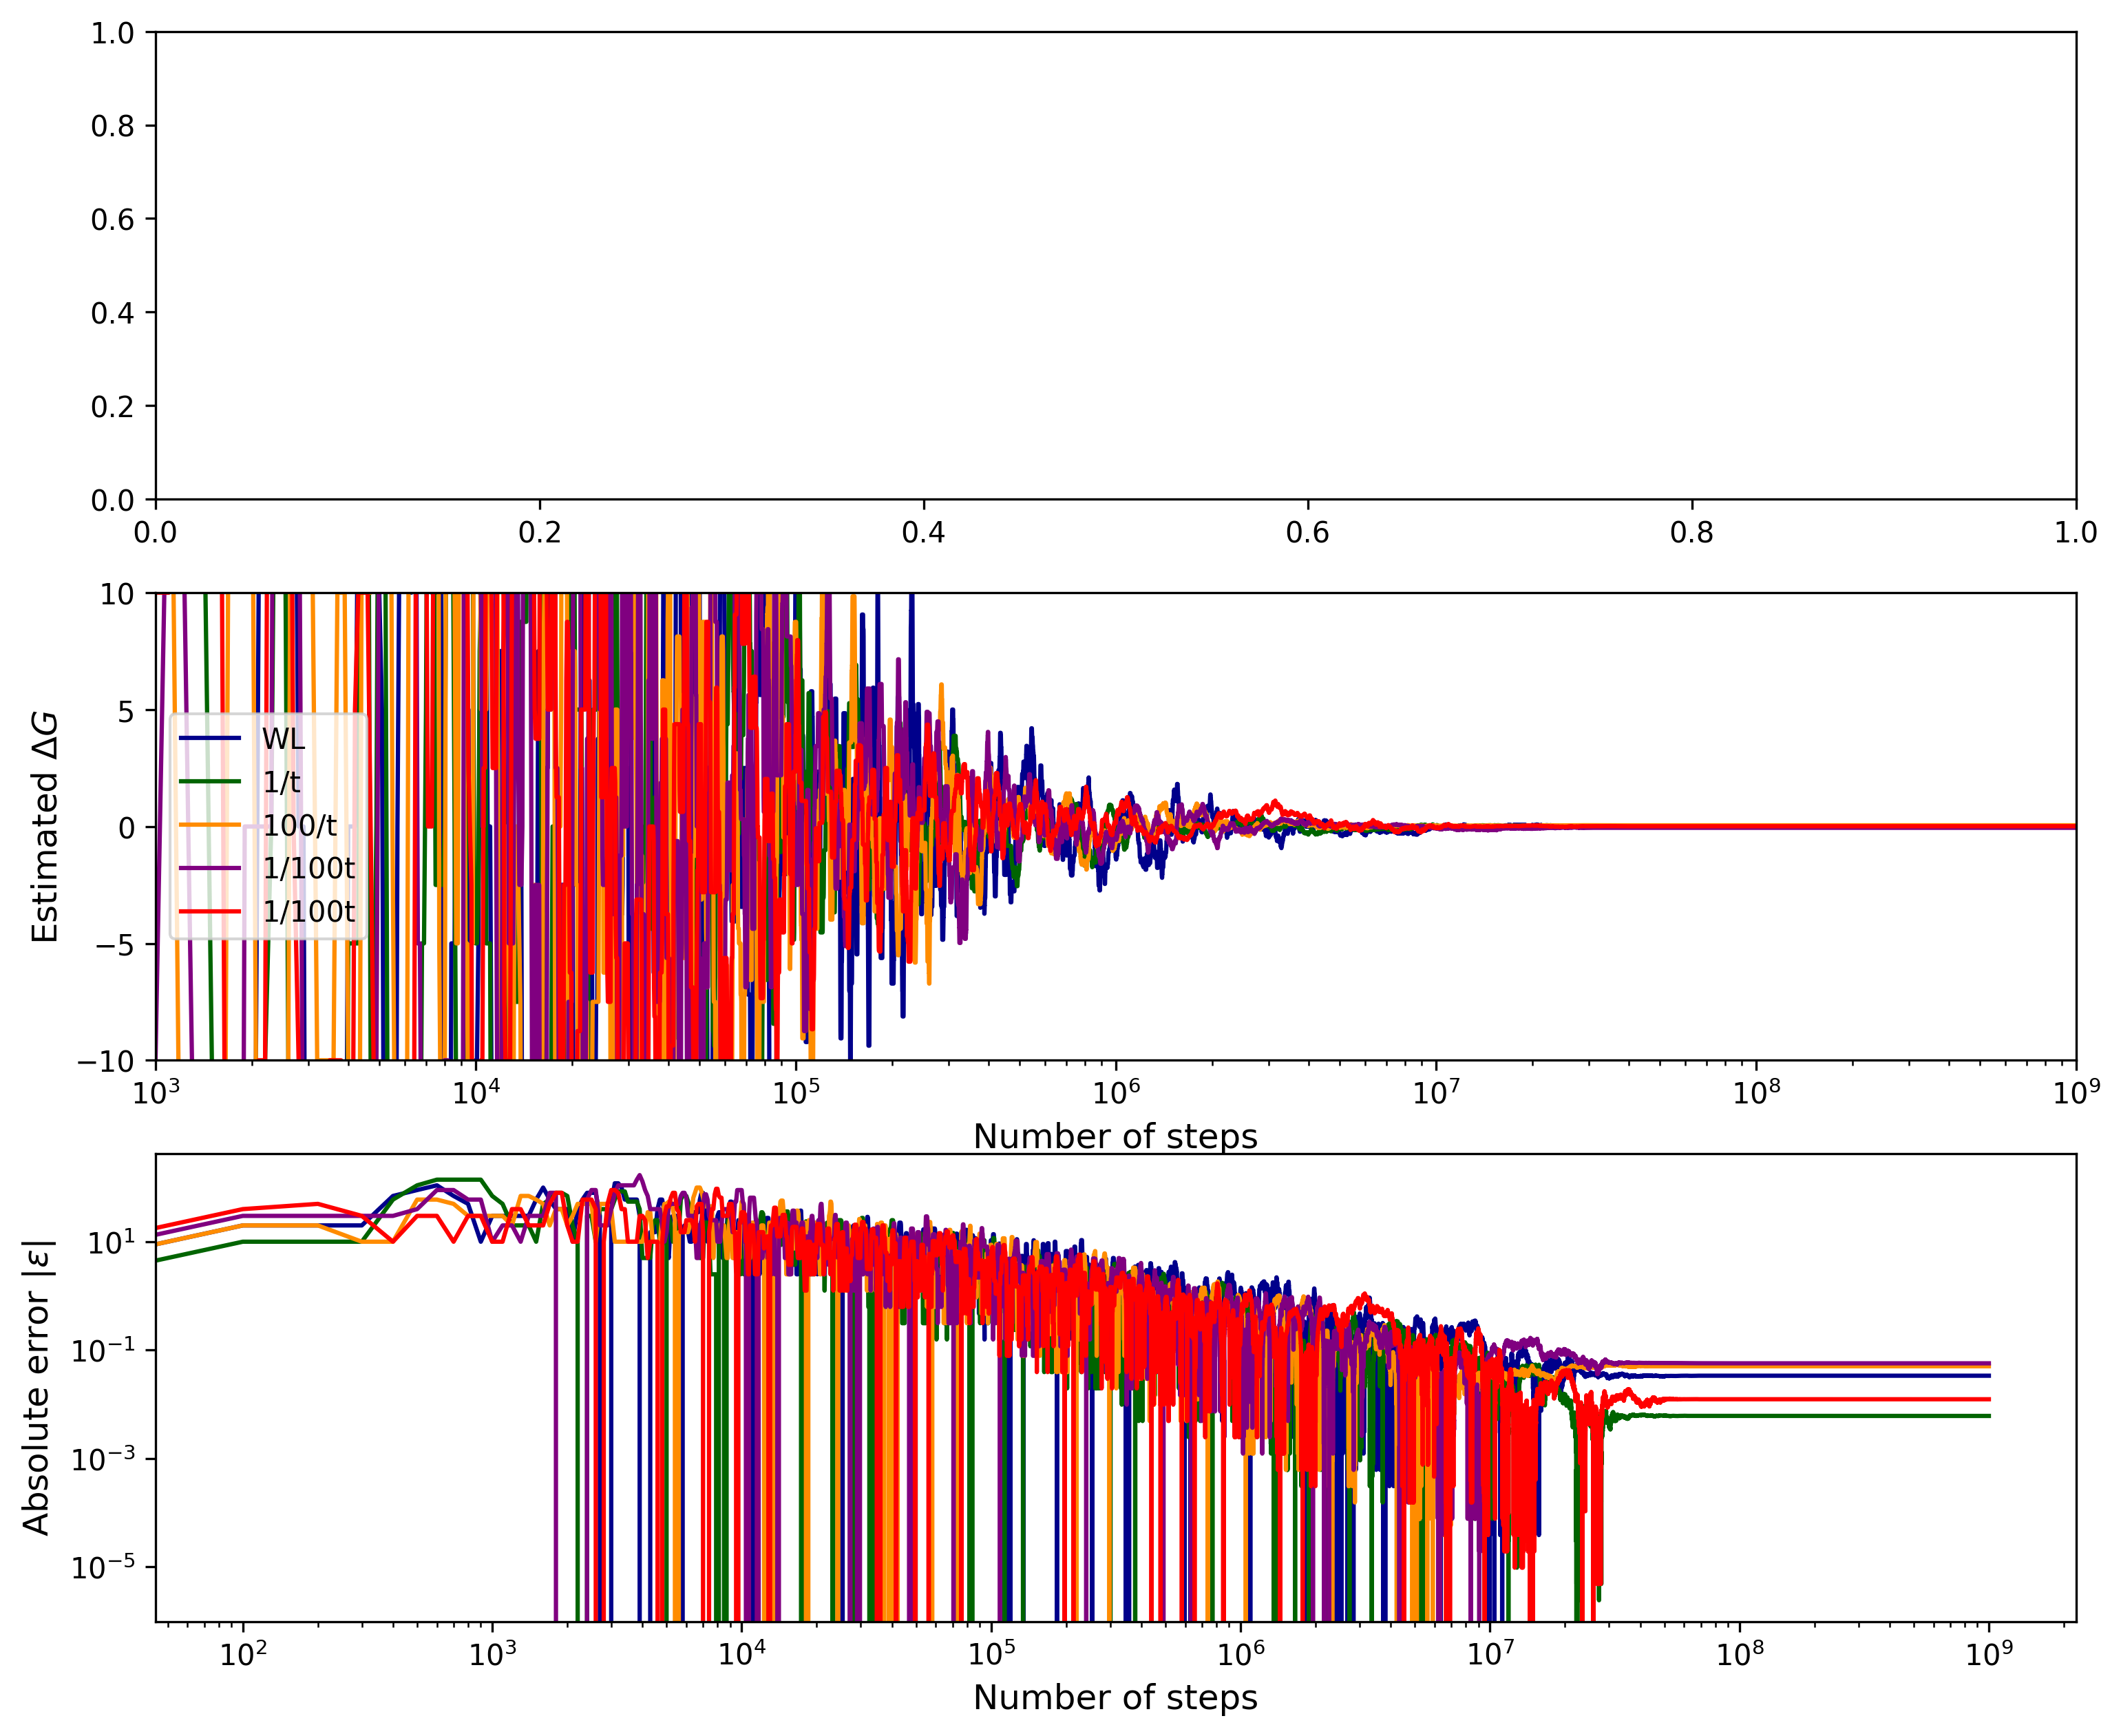

In [59]:
plot_comparison(nstep=int(1e9),c_1_over_t='no', init_step=0)

## plots for nsteps = 1e7

<>:44: SyntaxWarning: invalid escape sequence '\D'
<>:44: SyntaxWarning: invalid escape sequence '\D'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_93186/809990333.py:44: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('estimated $\Delta G$')


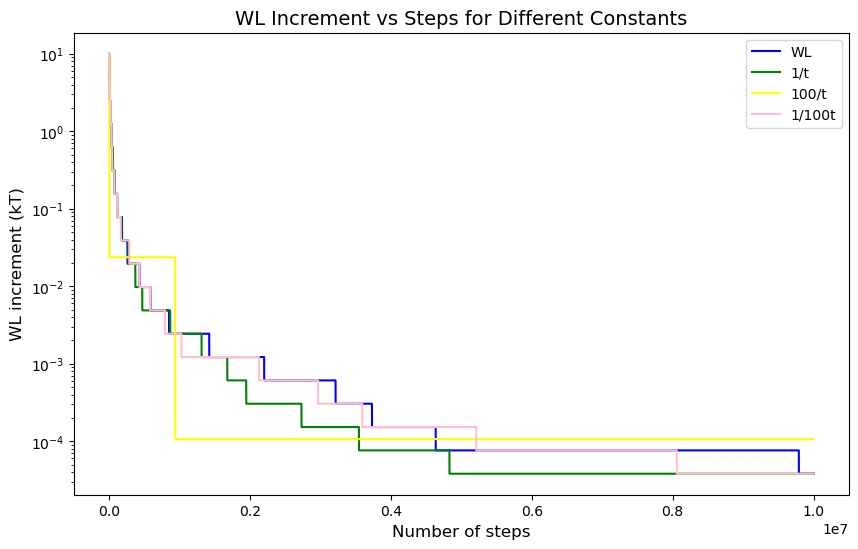

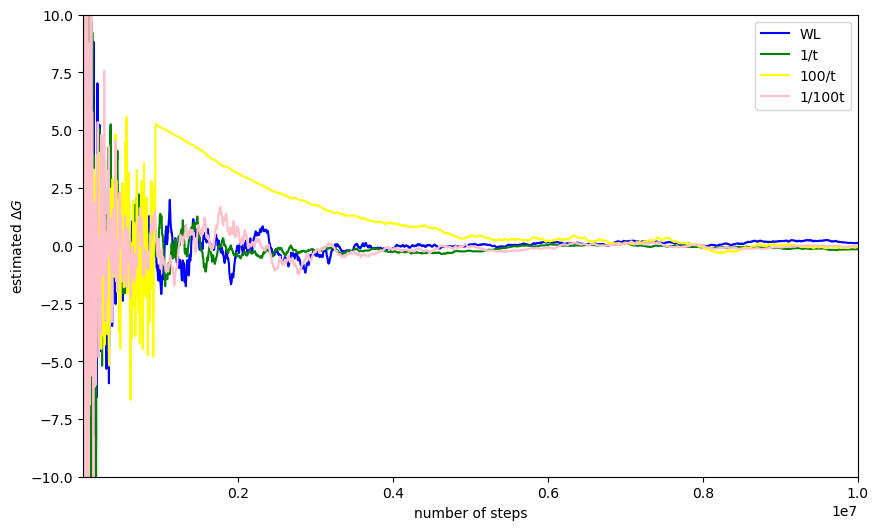

In [27]:
import numpy as np
from matplotlib import pyplot as plt
nstep = int(1e7)
c_1_over_t = 1
step_traj = np.load(f'{proj_path}/trajectories/step_traj_{nstep}steps_{c_1_over_t}constant.npy')
# Load data
wl_increment_traj_no_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_noconstant.npy') 
wl_increment_traj_1_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_1constant.npy')
wl_increment_traj_100_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_100constant.npy')
wl_increment_traj_0_01_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_0.01constant.npy')
# Plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.plot(step_traj, wl_increment_traj_no_c, label='WL', color='blue')
plt.plot(step_traj, wl_increment_traj_1_c, label='1/t', color='green')
plt.plot(step_traj, wl_increment_traj_100_c, label='100/t', color='yellow')
plt.plot(step_traj, wl_increment_traj_0_01_c, label='1/100t', color='pink')
# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xlabel('Number of steps', fontsize=12)
plt.ylabel('WL increment (kT)', fontsize=12)
plt.title('WL Increment vs Steps for Different Constants', fontsize=14)
plt.legend()
plt.savefig(f'{proj_path}/plots/wl_increment_vs_{nstep}steps_combined.png', dpi=300)
plt.show()

free_energy_traj_no_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_noconstant.npy') 
free_energy_traj_1_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_1constant.npy')
free_energy_traj_100_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_100constant.npy')
free_energy_traj_0_01_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_0.01constant.npy')

# Plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.plot(step_traj, free_energy_traj_no_c, label='WL', color='blue')
plt.plot(step_traj, free_energy_traj_1_c, label='1/t', color='green')
plt.plot(step_traj, free_energy_traj_100_c, label='100/t', color='yellow')
plt.plot(step_traj, free_energy_traj_0_01_c, label='1/100t', color='pink')

#plt.yscale('log')
plt.xlim(1e3,1e7)
plt.ylim(-10,10)
plt.xlabel('number of steps')
plt.ylabel('estimated $\Delta G$')
plt.legend()
plt.savefig(f'{proj_path}/plots/free_energy_vs_{nstep}steps_combined.png', dpi=300)
plt.show()

## plot for nsteps = 1e8

<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:42: SyntaxWarning: invalid escape sequence '\D'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_95455/1452673886.py:42: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('estimated $\Delta G$')


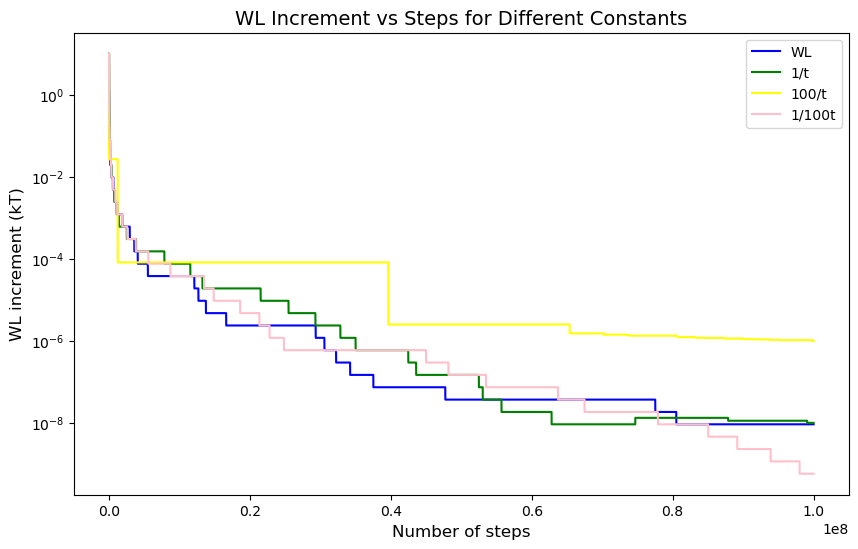

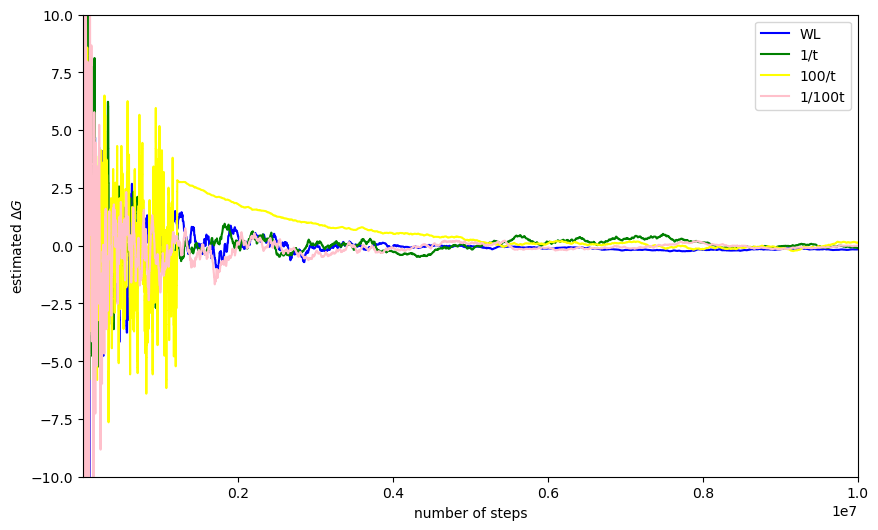

In [6]:
nstep = int(1e8)

c_1_over_t = 1
step_traj = np.load(f'{proj_path}/trajectories/step_traj_{nstep}steps_{c_1_over_t}constant.npy')
# Load data
wl_increment_traj_no_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_noconstant.npy') 
wl_increment_traj_1_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_1constant.npy')
wl_increment_traj_100_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_100constant.npy')
wl_increment_traj_0_01_c = np.load(f'{proj_path}/trajectories/wl_increment_traj_{nstep}steps_0.01constant.npy')
# Plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.plot(step_traj, wl_increment_traj_no_c, label='WL', color='blue')
plt.plot(step_traj, wl_increment_traj_1_c, label='1/t', color='green')
plt.plot(step_traj, wl_increment_traj_100_c, label='100/t', color='yellow')
plt.plot(step_traj, wl_increment_traj_0_01_c, label='1/100t', color='pink')
# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xlabel('Number of steps', fontsize=12)
plt.ylabel('WL increment (kT)', fontsize=12)
plt.title('WL Increment vs Steps for Different Constants', fontsize=14)
plt.legend()
plt.savefig(f'{proj_path}/plots/wl_increment_vs_{nstep}steps_combined.png', dpi=300)
plt.show()

free_energy_traj_no_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_noconstant.npy') 
free_energy_traj_1_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_1constant.npy')
free_energy_traj_100_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_100constant.npy')
free_energy_traj_0_01_c = np.load(f'{proj_path}/trajectories/free_energy_traj_{nstep}steps_0.01constant.npy')

# Plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.plot(step_traj, free_energy_traj_no_c, label='WL', color='blue')
plt.plot(step_traj, free_energy_traj_1_c, label='1/t', color='green')
plt.plot(step_traj, free_energy_traj_100_c, label='100/t', color='yellow')
plt.plot(step_traj, free_energy_traj_0_01_c, label='1/100t', color='pink')

#plt.yscale('log')
plt.xlim(1e3,1e7)
plt.ylim(-10,10)
plt.xlabel('number of steps')
plt.ylabel('estimated $\Delta G$')
plt.legend()
plt.savefig(f'{proj_path}/plots/free_energy_vs_{nstep}steps_combined.png', dpi=300)
plt.show()

In [7]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size for better clarity
plt.plot(step_traj, wl_increment_traj_no_c, label='WL', color='blue')
plt.plot(step_traj, wl_increment_traj_1_c, label='1/t', color='green')
plt.plot(step_traj, wl_increment_traj_100_c, label='100/t', color='yellow')
plt.plot(step_traj, wl_increment_traj_0_01_c, label='1/100t', color='pink')
# Log scale for y-axis
plt.yscale('log')
plt.xscale('log')
# Labels and title
plt.xlabel('Number of steps', fontsize=12)
plt.ylabel('WL increment (kT)', fontsize=12)
plt.title('WL Increment vs Steps for Different Constants', fontsize=14)
plt.legend()
plt.savefig(f'{proj_path}/plots/wl_increment_vs_{nstep}steps_combined.png', dpi=300)
plt.show()

: 

# code backlog

In [ ]:
def calculate_free_energy_sdt(free_energy_files,label):
    # Load the free energy arrays from files and stack them
    fe_data = np.array([np.load(f) for f in free_energy_files])  # Shape: (num_files, len_per_file)

    # Mean and std across clones
    mean = np.mean(fe_data, axis=0)
    std = np.std(fe_data, axis=0)

    # Calculate mean of free energy from step 1e8 to 1e9
    # 1e9 steps, saved every 100 steps = 10,000,000 data points
    # Step 1e8 = index 1,000,000 (1e8 / 100)
    mean_from_1e8_to_1e9 = np.mean(mean[1000000:]) if len(mean) >= 1000000 else np.mean(mean)


    # Save mean and std to files
    np.save(f'{proj_path}/trajectories/mean_free_energy_of_multiple_traces{label}.npy', mean)
    np.save(f'{proj_path}/trajectories/std_free_energy_of_multiple_traces{label}.npy', std)
    np.save(f'{proj_path}/trajectories/mean_free_energy_1e8_to_1e9_{label}.npy', mean_from_1e8_to_1e9)
'''
free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_noconstant_noswitch_wL_only{suffix}.npy'
    for suffix in ['','_2nd','_3rd','_4th','_5th','_6th','_7th', '_8th','_9th','_10th']]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1constant_switchlto_c_equal1_no_histogramflat{suffix}.npy'
    for suffix in ['_1st','_2nd','_3rd','_4th','_5th','_7th']]

free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_1.86264518648386c_switchlto_c_no_histogramflat_nsteps_limit_5e7_1st.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_0.93132259324193c_switchlto_c_no_histogramflat_nsteps_limit_5e7_2nd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_3rd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_119.20929193496704c_switchlto_c_no_histogramflat_nsteps_limit_5e7_4th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_5th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_6th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_59.60464596748352c_switchlto_c_no_histogramflat_nsteps_limit_5e7_7th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_14.90116149187088c_switchlto_c_no_histogramflat_nsteps_limit_5e7_8th.npy'
    ]
'''
free_energy_files = [
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_1st.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_2nd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_4882.8173828125c_switchlto_c_no_histogramflat_nsteps_limit_e6_3rd.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_4th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_5th.npy',
    f'{proj_path}/trajectories/free_energy_traj_0-{nstep}step_2441.40869140625c_switchlto_c_no_histogramflat_nsteps_limit_e6_6th.npy'
    ]

calculate_free_energy_sdt(free_energy_files,label='c_switchlto_c_no_histogramflat_nsteps_limit_e6')

In [7]:
def plot_comparison(nstep=int(1e7),c_1_over_t='no', init_step=0):   
    
    step_traj = np.load(f'{proj_path}/trajectories/step_traj_0-1000000000step_noconstant_noswitch_wL_only.npy')
    free_energy_traj_1st = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only.npy')
    free_energy_traj_2nd = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_2nd.npy') 
    free_energy_traj_3rd = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_3rd.npy')
    free_energy_traj_4th = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_4th.npy')
    free_energy_traj_5th = np.load(f'{proj_path}/trajectories/free_energy_traj_{init_step}-{nstep}step_{c_1_over_t}constant_noswitch_wL_only_5th.npy')
    
    # Create 3x2 subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), dpi=300)
   
    # Load and Plot wl incremeno
    #axs[0].plot(step_traj, wl_increment_traj_no_c, label='WL', color='darkblue')
    #axs[0].plot(step_traj, wl_increment_traj_1_c, label='1/t', color='darkgreen')
    #axs[0].plot(step_traj, wl_increment_traj_100_c, label='100/t', color='darkorange')
    #axs[0].plot(step_traj, wl_increment_traj_0_01_c, label='1/100t', color='purple')
    #axs[0].set_yscale('log') # Log scale for y-axis
    #axs[0].set_xscale('log')
    #axs[0].set_xlabel('Number of steps', fontsize=12)
    #axs[0].set_ylabel('WL increment (kT)', fontsize=12)
    #axs[0].legend()
    
    # Load and Plot free energy data
    axs[1].plot(step_traj, free_energy_traj_1st, label='WL', color='darkblue')
    axs[1].plot(step_traj, free_energy_traj_2nd, label='1/t', color='darkgreen')
    axs[1].plot(step_traj, free_energy_traj_3rd, label='100/t', color='darkorange')
    axs[1].plot(step_traj, free_energy_traj_4th, label='1/100t', color='purple')
    axs[1].plot(step_traj, free_energy_traj_5th, label='1/100t', color='red') 
    axs[1].set_xlim(1e3,nstep)
    axs[1].set_xscale('log')
    axs[1].set_ylim(-10,10)
    axs[1].set_yticks(np.arange(-10, 11, 5))  # Set y-axis ticks with interval of 5
    axs[1].set_xlabel('Number of steps', fontsize=12)
    axs[1].set_ylabel('Estimated $\Delta G$', fontsize=12)
    axs[1].legend()

    # plot absolute error
    axs[2].plot(step_traj, np.abs(free_energy_traj_1st), label='WL', color='darkblue')
    axs[2].plot(step_traj, np.abs(free_energy_traj_2nd), label='1/t', color='darkgreen')
    axs[2].plot(step_traj, np.abs(free_energy_traj_3rd), label='100/t', color='darkorange')
    axs[2].plot(step_traj, np.abs(free_energy_traj_4th), label='1/100t', color='purple')
    axs[2].plot(step_traj, np.abs(free_energy_traj_5th), label='1/100t', color='red')
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')
    axs[2].set_xlabel('Number of steps',fontsize=12)
    axs[2].set_ylabel('Absolute error $|\epsilon|$',fontsize=12)
    
    plt.savefig(f'{proj_path}/plots/compared_with_without_1overt.png', dpi=300, bbox_inches='tight')
    plt.show()    


def P_accept_vs_delta_f_ij(delta_u_ij, delta_f_ij_range = (-100., 100., 0.5)):
    """Computes the average metropolis acceptance probability
    
        P_acc = min[ 1, exp(-(delta_u_ij + delta_f_ij))]
        
    for the specified range of delta_f_ij.
        
    INPUT
    delta_u_ij         - np.array() of sampled delta_u_ij values
    
    OPTIONS
    delta_f_ij_range   - tuple of min, max, and step in units kT
    
    RETURNS
    Pacc               - np.array() of acceptance probabilities 
    delta_f_ij_values  - np.array() of values where Pacc was evaluated
    """
    
    delta_f_ij_min  = delta_f_ij_range[0]
    delta_f_ij_max  = delta_f_ij_range[1] 
    delta_f_ij_step = delta_f_ij_range[2]
    
    delta_f_ij_values = np.arange(delta_f_ij_min, delta_f_ij_max, delta_f_ij_step)
    Pacc = np.zeros(delta_f_ij_values.shape)
    
    for i in range(delta_f_ij_values.shape[0]):
        delta_f_ij = delta_f_ij_values[i]
        Pacc[i] = np.mean( np.fmin(np.ones(delta_u_ij.shape), np.exp(-1.0*(delta_u_ij-delta_f_ij))) )
    return Pacc, delta_f_ij_values    

# plot the distribution of the delta_energies 
def plot_delta_energy_distribution(nstep, n_ensembles,c_1_over_t='no'):
    dhdl_traj = np.load(f'{proj_path}/trajectories/dhdl_traj_{nstep}steps_{c_1_over_t}constant.npy')
    i_traj = np.load(f'{proj_path}/trajectories/i_traj_{nstep}steps_{c_1_over_t}constant.npy')
    
    plt.figure(figsize=(10,15))
    for j in range(n_ensembles-1):
        #######################
        # Forward transitions

        Ind_i = (i_traj == j)
        Ind_i[(int(len(i_traj)/2)):] = False # take the last half of the trajectory
        delta_u_ij = dhdl_traj[Ind_i, j+1]  # delta_u = (u_{i+1} - u_i) values
    
        delta_u_bins = np.arange(-50., 200., 1.)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        
        plt.subplot(n_ensembles-1, 2, 2*j+1)
        plt.step(bin_centers, counts)
        # plt.step(bin_centers_biased, counts_biased, 'r-')
        plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j,j+1))
        
        #######################
        # Back transitions
     
        Ind_j = (i_traj == j+1)
        Ind_j[(int(len(i_traj)/2)):] = False # take the last half of the trajectory
        delta_u_ji = dhdl_traj[Ind_j, j]  # delta_u = (u_{i+1} - u_i) values
    
        delta_u_bins = np.arange(-50., 200., 1.)
        counts, bin_edges = np.histogram(delta_u_ji, bins=delta_u_bins)
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
        
        if (0):
            #plt.subplot(n_ensembles-1, 2, 2*j+1)
            plt.step(bin_centers, counts)
            # plt.step(bin_centers_biased, counts_biased, 'r-')
            plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j+1,j))
    
    
        ############################################
        # Forward and back acceptance probabilities
    
        plt.subplot(n_ensembles-1, 2, 2*(j+1))
        Pacc, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ij)
        plt.plot(delta_f_ij_values, Pacc, 'b-', label='$p_{%d \\rightarrow %d}$'%(j,j+1))
        Pacc, delta_f_ij_values = P_accept_vs_delta_f_ij(delta_u_ji)
        plt.plot(-delta_f_ij_values, Pacc, 'r-', label='$p_{%d \\rightarrow %d}$'%(j+1,j))
        plt.ylim(0,1)
        plt.xlabel('$\\Delta \\tilde{f}_{ij}$ (kT)')
        plt.legend()
    plt.savefig(f'{proj_path}/plots/delta_free_energy_distribution_{nstep}steps.png', dpi=300)
    plt.tight_layout()

def replace_zeros_with_neighbor_average(arr, n_neighbors=3):
    """
    Replace zero values in an array with the average of up to n_neighbors non-zero values
    before and after each zero point.
    """
    arr = arr.copy()  # Avoid modifying the input array
    zero_indices = np.where(arr == 0)[0]  # Find indices where value is zero
    
    for idx in zero_indices:
        # Define the window: up to n_neighbors before and after
        start = max(0, idx - n_neighbors)
        end = min(len(arr), idx + n_neighbors + 1)
        
        # Get neighboring values
        neighbors = arr[start:end]
        # Exclude the zero value at idx and any other zeros
        neighbors = neighbors[(neighbors != 0) & (np.arange(start, end) != idx)]
        
        # If there are non-zero neighbors, compute their average
        if len(neighbors) > 0:
            avg = np.mean(neighbors)
            arr[idx] = avg
        else:
            # If no non-zero neighbors, leave the zero unchanged (or handle differently)
            print(f"Warning: No non-zero neighbors for index {idx}. Leaving unchanged.")
    
    return arr


<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:104: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:104: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1052511773.py:35: SyntaxWarning: invalid escape sequence '\D'
  axs[1].set_ylabel('Estimated $\Delta G$', fontsize=12)
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1052511773.py:47: SyntaxWarning: invalid escape sequence '\e'
  axs[2].set_ylabel('Absolute error $|\epsilon|$',fontsize=12)
/var/folders/91/kj7w10k95pj5ntfwj96s6nxc0000gn/T/ipykernel_62094/1052511773.py:104: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j,j+1))
/var/folders/91/kj7w10k95pj5nt

In [ ]:
# Wang-landau sampling

g = np.zeros(n_ensembles) # bias energies
h = np.zeros(n_ensembles) # histogram counts

wl_increment = 10.0    # in kT
wl_scaling  = 0.5     # (0.5 is a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007), 0.8 is MRS
flatness = 0.95       # if all histogram values are within flatness*100
                       # percent of the mean counts, decr

wl_increment_freq = 10  # frequency to update wl sampling
                         # wl_increment and reset histogram
    
use_1_over_t = False
switch_to_1_over_t = False  # update increment as c/t = c_1_over_t/(nsteps) when ...
c_1_over_t = 1000      # ...the wl_increment gets small enough (a la R. E. Belardinelli, and V. D. Pereyra, JCP 2007)

# random walk
x = 0.0   # initial position
dx = 1.0 # gaussian step size 
i = 0  # thermo index
#nsteps = int(1e7)
nsteps = 1000000

# status output
#print_every = 10000
print_every = 1000
# trajectory
traj_every = 1
x_traj = []
i_traj = []
step_traj = []
wl_increment_traj = []
free_energy_traj = []
dhdl_traj = []

# transition count matrix
T_counts = np.zeros( (n_ensembles, n_ensembles) )
energy = u_i(x, k_i[i], x_i[i], c_i[i])
for step in range(nsteps):
    # propose a MC move
    x_new = x + dx*np.random.randn()
    energy_new = u_i(x_new, k_i[i], x_i[i], c_i[i])
    print('x_new ',x_new) 
    # and accept it according to the metropolis criterion
    accept = False
    P_accept = min(1., np.exp(-(energy_new - energy)))
    A =np.random.rand() 
    if A < P_accept:
        accept = True
    
    if accept:
        x = x_new
        energy = energy_new
        print('random',A, 'P_accept',P_accept, 'accept a move to x_new:',x)
    
    # update the WL sampling
    if (step%wl_increment_freq == 1):
        g[i] += wl_increment
        h[i] += 1.0
        print('step', step,'update the WL sampling: g',g, '\n h',h)
        
        # reset the bias to i=0 reference
        g -= g[0]
        print('g',g)
        
        # attempt a move to a neighboring ensemble
        wl_accept = False
        if np.random.rand() < 0.5:
            j = i+1
            print('propose a move to neighbor j = i+1:', j)
        else:
            j = i-1
            print('propose a move to neighbor j = i-1:', j) 
        if (j >= 0) and (j < n_ensembles):
            P_wl_accept = min(1., np.exp(-(u_i(x, k_i[j], x_i[j], c_i[i]) + g[j] - u_i(x, k_i[i], x_i[i], c_i[i]) - g[i])))
            A = np.random.rand()
            if np.random.rand() < P_wl_accept:
                wl_accept = True    
        if wl_accept:
            T_counts[i,j] += 1.0
            print('a move is accepted, wl_accept: T_counts[]',T_counts)
            i = j
        else:
            T_counts[i,i] += 1.0
            print('a move is not accepted, when not wl_accept: T_counts[i,i]',T_counts[i,i])
        
        # check if the histogram is flat enough
        mean_counts = h.mean()
        which_are_flat_enough = (h > flatness*mean_counts)*(h < (2.0-flatness)*mean_counts)
        print('step ',step,'print_every ', print_every)
        if step%print_every == 1:
            print('h', h, 'mean_counts', mean_counts)
            print('which_are_flat_enough', which_are_flat_enough)
        
        if (switch_to_1_over_t == False) and (wl_increment < c_1_over_t/float(step)):
            print('#### Switching to 1/t method ( wl_increment =', wl_increment, ') ####')
            switch_to_1_over_t = True
            
        if np.sum( which_are_flat_enough.astype(int) ) == n_ensembles:
            if switch_to_1_over_t:
                wl_increment = c_1_over_t/float(step)
            else:
                wl_increment *= wl_scaling
            h = np.zeros(n_ensembles)

    # print a status report
    if step%print_every == 0:
        print('step', step, 'x', x, 'thermo index', i, 'wl_increment =', wl_increment, 'kT\n')
        print('# ensemble\thistogram\tg (kT)')
        for k in range(n_ensembles):
            outstr = '%8d\t%8d\t%3.4f'%(k, h[k], g[k])
            if k == i:
                outstr += ' <<'
            print(outstr)

    # store sample in trajectory 
    if step%traj_every == 0:
        x_traj.append(x)
        i_traj.append(i)
        step_traj.append(step)
        free_energy_traj.append(-1.0*g[-1])
        wl_increment_traj.append(wl_increment)

    # store delta energies of all thermo indices for every time step
    dhdl_traj.append( [u_i(x, k_i[j], x_i[j], c_i[i]) - u_i(x, k_i[i], x_i[i], c_i[i]) for j in range(n_ensembles)]  )

#save trajectory for latter use
np.save(f'{proj_path}/trajectories/x_traj_{nsteps}steps_{c_1_over_t}constant.npy',x_traj)
np.save(f'{proj_path}/trajectories/i_traj_{nsteps}steps_{c_1_over_t}constant.npy',i_traj)
np.save(f'{proj_path}/trajectories/step_traj_{nsteps}steps_{c_1_over_t}constant.npy',step_traj)
np.save(f'{proj_path}/trajectories/free_energy_traj_{nsteps}steps_{c_1_over_t}constant.npy',free_energy_traj)
np.save(f'{proj_path}/trajectories/wl_increment_traj_{nsteps}steps_{c_1_over_t}constant.npy',wl_increment_traj)
np.save(f'{proj_path}/trajectories/dhdl_traj_{nsteps}steps_{c_1_over_t}constant.npy',dhdl_traj)
np.save(f'{proj_path}/trajectories/dhdl_traj_{nsteps}steps_{c_1_over_t}constant.npy',T_counts)
